# Explanatory Analysis with ALDI++ (WEATHER)

In [6]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from scipy.stats import skew, kurtosis

In [3]:
# Path to the CSV file
csv_file_path = "/Users/agetman/Desktop/Twork/energyThesis/data/Fluvius_hourly_weather_data.csv"

# Load the CSV file into a DataFrame
weather_df = pd.read_csv(csv_file_path)

# Display information about the DataFrame
weather_df

,date,temperature_2m,relative_humidity_2m,precipitation,cloud_cover,wind_speed_10m
0,2021-12-31 22:00:00+00:00,12.15,90.853400,0.1,100.0,16.418526
1,2021-12-31 23:00:00+00:00,12.40,89.670780,0.0,100.0,17.429354
2,2022-01-01 00:00:00+00:00,12.65,85.893170,0.0,67.5,14.618837
3,2022-01-01 01:00:00+00:00,11.45,91.414560,0.0,90.0,15.546833
4,2022-01-01 02:00:00+00:00,10.90,94.492230,0.0,10.8,15.778516
...,...,...,...,...,...,...
8758,2022-12-31 20:00:00+00:00,16.45,49.850815,0.0,98.4,38.141315
8759,2022-12-31 21:00:00+00:00,16.30,51.737160,0.0,100.0,37.252610
8760,2022-12-31 22:00:00+00:00,15.90,51.950000,0.0,10.0,38.600000
8761,2022-12-31 23:00:00+00:00,15.10,54.500000,0.0,10.0,38.600000


## ALDI++ (Weather Data)

In [4]:
def preprocess_feature_to_24hr_vectors(weather_df, feature_col):
    """
    Convert hourly data for a single weather feature into 24-hour daily vectors without index-column conflicts.
    Handle missing values by dropping rows with missing hourly data.
    """
    # Parse the date into proper datetime format
    weather_df['date'] = pd.to_datetime(weather_df['date'])
    weather_df['hour'] = weather_df['date'].dt.hour
    weather_df['day'] = weather_df['date'].dt.date

    # Filter out rows from 2021 (keep only 2022 onwards)
    weather_df = weather_df[weather_df['day'] >= pd.to_datetime("2022-01-01").date()]

    # Pivot to create 24-hour vectors for the specified feature
    daily_vectors = weather_df.pivot_table(index='day', columns='hour', values=feature_col)

    # Drop rows (days) with missing values
    daily_vectors = daily_vectors.dropna(how="any")

    # Reset index, keeping `day` as a column (to avoid ambiguity)
    daily_vectors.reset_index(inplace=True)

    return daily_vectors  # Shape: [#days x 25 (day + 24 hours)]


def extract_features_from_24hr_vector(hourly_vector):
    """
    Extract features from a 24-hour vector of weather data,
    handling edge cases like vectors with no variability (e.g., all-zero precipitation).
    """
    # Check if all values in the vector are the same
    if np.all(hourly_vector == hourly_vector[0]):  # All values are identical
        return {
            'mean': hourly_vector[0],
            'std': 0,
            'min': hourly_vector[0],
            'max': hourly_vector[0],
            'range': 0,
            'skew': 0,  # No skewness for identical values
            'kurtosis': 0,  # No kurtosis for identical values
            'peak_hour': np.argmax(hourly_vector),
            'day_night_ratio': 0,  # No day-night difference if all values are the same
        }

    # For normal cases with variability
    return {
        'mean': np.mean(hourly_vector),
        'std': np.std(hourly_vector),
        'min': np.min(hourly_vector),
        'max': np.max(hourly_vector),
        'range': np.max(hourly_vector) - np.min(hourly_vector),
        'skew': skew(hourly_vector),
        'kurtosis': kurtosis(hourly_vector),
        'peak_hour': np.argmax(hourly_vector),
        'day_night_ratio': np.sum(hourly_vector[8:20]) / (np.sum(hourly_vector[0:8]) + 1e-6),  # Avoid div-by-0
    }


def run_aldi_for_single_feature(df_24hr, tsne_perplexity=30, dbscan_eps=2, dbscan_min_samples=3):
    """
    Run ALDI++ pipeline for a single feature's 24-hour vectors + feature extraction.
    """
    # Set 'day' as the index for easier processing
    df_24hr.set_index('day', inplace=True)

    # Drop rows with missing hourly data
    df_24hr = df_24hr.dropna()

    # Extract statistical features for each day's 24-hour vector
    feature_rows = []
    for _, row in df_24hr.iterrows():
        hourly_vector = row.values
        extracted_features = extract_features_from_24hr_vector(hourly_vector)
        extracted_features['day'] = row.name  # Keep the 'day' for reference
        feature_rows.append(extracted_features)

    features_df = pd.DataFrame(feature_rows)
    features_df.set_index('day', inplace=True)

    # Normalize both 24-hour vectors and extracted features
    scaler = StandardScaler()
    X_24hr_scaled = scaler.fit_transform(df_24hr)
    X_features_scaled = scaler.fit_transform(features_df)

    # Combine normalized raw vectors and extracted features
    X_combined = np.hstack([X_24hr_scaled, X_features_scaled])

    # Dimension reduction using t-SNE
    tsne = TSNE(n_components=2, perplexity=tsne_perplexity, random_state=0)
    X_2d = tsne.fit_transform(X_combined)

    # Outlier detection using DBSCAN
    db = DBSCAN(eps=dbscan_eps, min_samples=dbscan_min_samples)
    labels = db.fit_predict(X_2d)

    # Identify outlier days (labeled as -1)
    outlier_days = features_df.index[labels == -1].tolist()

    return outlier_days, labels, X_2d, features_df  # Include feature DataFrame for reference


def run_aldi_on_all_features_with_extraction(weather_df, feature_cols, tsne_perplexity=30, dbscan_eps=2, dbscan_min_samples=3):
    """
    Run ALDI++ separately for each weather feature with feature extraction and collect outlier days.
    """
    all_outlier_days = {}

    for feature in tqdm(feature_cols):
        print(f"\nRunning ALDI++ for feature: {feature}...")

        # Preprocess the feature into 24-hour vectors
        df_24hr = preprocess_feature_to_24hr_vectors(weather_df, feature)

        # Run ALDI++ on this feature's 24-hour vectors with feature extraction
        outlier_days, labels, X_2d, features_df = run_aldi_for_single_feature(
            df_24hr, tsne_perplexity, dbscan_eps, dbscan_min_samples
        )

        # Collect results
        all_outlier_days[feature] = {
            'outlier_days': outlier_days,
            'labels': labels,
            'tsne_coords': X_2d,
            'features_df': features_df,
            'df_24hr': df_24hr,  # Include for reference
        }

    return all_outlier_days


In [7]:
# Define the weather features to analyze separately
feature_cols = [
    'temperature_2m',
    'relative_humidity_2m',
    'precipitation',
    'wind_speed_10m',
    'cloud_cover',
]

# Run ALDI++ on each feature with feature extraction
results = run_aldi_on_all_features_with_extraction(weather_df, feature_cols)
results

  0%|          | 0/5 [00:00<?, ?it/s]


Running ALDI++ for feature: temperature_2m...


 20%|██        | 1/5 [00:00<00:03,  1.29it/s]


Running ALDI++ for feature: relative_humidity_2m...


 40%|████      | 2/5 [00:01<00:02,  1.37it/s]


Running ALDI++ for feature: precipitation...


 60%|██████    | 3/5 [00:02<00:01,  1.45it/s]


Running ALDI++ for feature: wind_speed_10m...


 80%|████████  | 4/5 [00:02<00:00,  1.41it/s]


Running ALDI++ for feature: cloud_cover...


100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


{'temperature_2m': {'outlier_days': [datetime.date(2022, 2, 4),
   datetime.date(2022, 3, 13),
   datetime.date(2022, 10, 10),
   datetime.date(2022, 11, 1)],
  'labels': array([ 0,  0,  0,  1,  0,  0,  0,  0,  1,  0,  0,  0,  0,  2,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,
         -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  1,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  2,  2,  0,  0,  2,  2,  0,  0,  0,  0,  2,
          0,  0,  0, -1,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 

## Visualize t-SNE results


Outliers for feature 'temperature_2m': [datetime.date(2022, 2, 4), datetime.date(2022, 3, 13), datetime.date(2022, 10, 10), datetime.date(2022, 11, 1)]

Outliers for feature 'relative_humidity_2m': [datetime.date(2022, 2, 18), datetime.date(2022, 5, 3), datetime.date(2022, 6, 29), datetime.date(2022, 8, 29), datetime.date(2022, 9, 10), datetime.date(2022, 9, 29), datetime.date(2022, 10, 2), datetime.date(2022, 12, 31)]

Outliers for feature 'precipitation': []

Outliers for feature 'wind_speed_10m': [datetime.date(2022, 2, 7), datetime.date(2022, 6, 2), datetime.date(2022, 6, 4), datetime.date(2022, 6, 19), datetime.date(2022, 9, 18), datetime.date(2022, 9, 30), datetime.date(2022, 11, 16), datetime.date(2022, 11, 27), datetime.date(2022, 12, 27)]

Outliers for feature 'cloud_cover': [datetime.date(2022, 1, 1), datetime.date(2022, 1, 2), datetime.date(2022, 1, 5), datetime.date(2022, 2, 10), datetime.date(2022, 2, 11), datetime.date(2022, 2, 25), datetime.date(2022, 4, 7), datetime.da

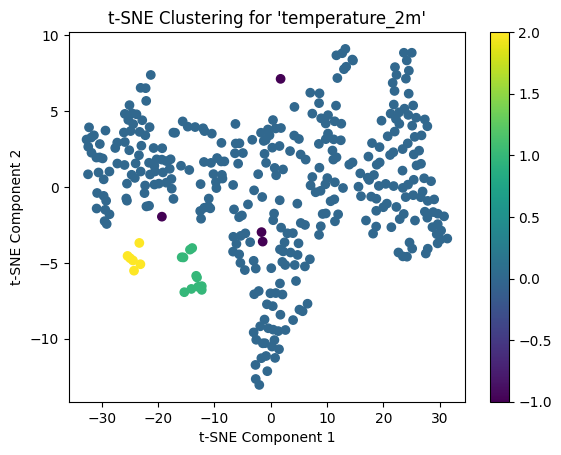

In [8]:
# Display outlier days for each feature
for feature, result in results.items():
    print(f"\nOutliers for feature '{feature}':", result['outlier_days'])

# Visualize t-SNE for one of the features
feature_to_plot = 'temperature_2m'
tsne_coords = results[feature_to_plot]['tsne_coords']
labels = results[feature_to_plot]['labels']

plt.scatter(tsne_coords[:, 0], tsne_coords[:, 1], c=labels, cmap='viridis')
plt.colorbar()
plt.title(f"t-SNE Clustering for '{feature_to_plot}'")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()


In [9]:
# Initialize an empty dictionary to store the outlier information
outlier_data = {}

# Iterate through results and populate the dataset
for feature, result in results.items():
    # Create a column for this feature (1 if the day is an outlier, 0 otherwise)
    outlier_days = result['outlier_days']
    outlier_data[feature] = outlier_days  # Store outlier days for each feature

# Convert the outlier data dictionary into a DataFrame
outlier_dataset = pd.DataFrame()

# Populate the DataFrame such that each date is an index and features are columns
all_outlier_days = set()  # To track all unique days across features

# Collect all unique outlier days
for feature, days in outlier_data.items():
    all_outlier_days.update(days)

# Ordered list of unique outlier days
all_outlier_days = sorted(all_outlier_days)

# Build the DataFrame
outlier_dataset['day'] = all_outlier_days

# For each feature, flag whether the day was an outlier or not with 1/0
for feature in results.keys():
    outlier_dataset[feature] = outlier_dataset['day'].apply(lambda x: 1 if x in outlier_data[feature] else 0)

# Set 'day' as index for better organization
outlier_dataset.set_index('day', inplace=True)

outlier_dataset


,temperature_2m,relative_humidity_2m,precipitation,wind_speed_10m,cloud_cover
day,,,,,
2022-01-01,0,0,0,0,1
2022-01-02,0,0,0,0,1
2022-01-05,0,0,0,0,1
2022-02-04,1,0,0,0,0
2022-02-07,0,0,0,1,0
2022-02-10,0,0,0,0,1
2022-02-11,0,0,0,0,1
2022-02-18,0,1,0,0,0
2022-02-25,0,0,0,0,1


In [10]:
# Add the 'Weather_Outlier_Day' column with all values set to 1
outlier_dataset['Weather_Outlier_Day'] = 1
outlier_dataset

,temperature_2m,relative_humidity_2m,precipitation,wind_speed_10m,cloud_cover,Weather_Outlier_Day
day,,,,,,
2022-01-01,0,0,0,0,1,1
2022-01-02,0,0,0,0,1,1
2022-01-05,0,0,0,0,1,1
2022-02-04,1,0,0,0,0,1
2022-02-07,0,0,0,1,0,1
2022-02-10,0,0,0,0,1,1
2022-02-11,0,0,0,0,1,1
2022-02-18,0,1,0,0,0,1
2022-02-25,0,0,0,0,1,1


In [12]:
# Extracting the mean of the weather features and overlapping them to weather outlier
weather_df

,date,temperature_2m,relative_humidity_2m,precipitation,cloud_cover,wind_speed_10m,hour,day
0,2021-12-31 22:00:00+00:00,12.15,90.853400,0.1,100.0,16.418526,22,2021-12-31
1,2021-12-31 23:00:00+00:00,12.40,89.670780,0.0,100.0,17.429354,23,2021-12-31
2,2022-01-01 00:00:00+00:00,12.65,85.893170,0.0,67.5,14.618837,0,2022-01-01
3,2022-01-01 01:00:00+00:00,11.45,91.414560,0.0,90.0,15.546833,1,2022-01-01
4,2022-01-01 02:00:00+00:00,10.90,94.492230,0.0,10.8,15.778516,2,2022-01-01
...,...,...,...,...,...,...,...,...
8758,2022-12-31 20:00:00+00:00,16.45,49.850815,0.0,98.4,38.141315,20,2022-12-31
8759,2022-12-31 21:00:00+00:00,16.30,51.737160,0.0,100.0,37.252610,21,2022-12-31
8760,2022-12-31 22:00:00+00:00,15.90,51.950000,0.0,10.0,38.600000,22,2022-12-31
8761,2022-12-31 23:00:00+00:00,15.10,54.500000,0.0,10.0,38.600000,23,2022-12-31


In [19]:
# Group by date part only (without time)
daily_weather = weather_df.groupby(weather_df['day'])[[
    'temperature_2m', 'relative_humidity_2m', 'precipitation', 'cloud_cover', 'wind_speed_10m'
]].mean().reset_index()

#daily_weather.rename(columns={'day':'date'},inplace=True)
daily_weather

,day,temperature_2m,relative_humidity_2m,precipitation,cloud_cover,wind_speed_10m
0,2021-12-31,12.275000,90.262090,0.050000,100.000000,16.923940
1,2022-01-01,11.950000,85.319515,0.008333,57.195836,16.741252
2,2022-01-02,11.545833,83.305570,0.312500,68.804169,25.140911
3,2022-01-03,8.816667,87.984144,0.179167,70.883335,22.997987
4,2022-01-04,6.627083,90.103062,0.229167,97.316668,14.128030
...,...,...,...,...,...,...
362,2022-12-28,9.079167,86.765895,0.212500,97.870833,30.359464
363,2022-12-29,8.875000,82.845296,0.050000,66.087500,29.935795
364,2022-12-30,8.895833,88.150897,0.225000,76.891667,26.497690
365,2022-12-31,14.897917,76.681709,0.587500,86.441667,33.631527


In [22]:
# List of indicator columns to rename (assuming all columns except 'day' or 'Weather_Outlier_Day')
indicator_columns = [
    col for col in outlier_dataset.columns if col not in ['Weather_Outlier_Day']
]

# Append '_i' suffix to indicator columns
outlier_dataset_renamed = outlier_dataset.rename(
    columns={col: col + '_i' for col in indicator_columns}
)

# Reset index to turn 'day' into a variable
outlier_dataset_renamed = outlier_dataset_renamed.reset_index()

# Merge with 'daily_weather' on 'day'
merged_dataset = outlier_dataset_renamed.merge(daily_weather, on='day', how='left')
merged_dataset

,day,temperature_2m_i,relative_humidity_2m_i,precipitation_i,wind_speed_10m_i,cloud_cover_i,Weather_Outlier_Day,temperature_2m,relative_humidity_2m,precipitation,cloud_cover,wind_speed_10m
0,2022-01-01,0,0,0,0,1,1,11.950000,85.319515,0.008333,57.195836,16.741252
1,2022-01-02,0,0,0,0,1,1,11.545833,83.305570,0.312500,68.804169,25.140911
2,2022-01-05,0,0,0,0,1,1,4.137500,79.075873,0.166667,55.583333,21.068452
3,2022-02-04,1,0,0,0,0,1,6.210417,84.229656,0.108333,68.787500,23.311227
4,2022-02-07,0,0,0,1,0,1,5.245833,71.389592,0.045833,42.562500,19.087572
5,2022-02-10,0,0,0,0,1,1,5.527083,91.913268,0.120833,76.883335,11.351362
6,2022-02-11,0,0,0,0,1,1,3.708333,79.253139,0.012500,20.575000,14.284724
7,2022-02-18,0,1,0,0,0,1,8.768750,73.633133,0.137500,64.300002,32.985426
8,2022-02-25,0,0,0,0,1,1,4.325000,72.653121,0.075000,20.937500,19.655213
9,2022-03-13,1,0,0,0,0,1,11.518750,65.225489,0.000000,79.620834,20.110068


In [11]:
file_path = "/Users/agetman/Desktop/Twork/energyThesis/data/from_V1/df_with_outliers.pkl"

# Load the pickle file into df
df = pd.read_pickle(file_path)
df

,EAN_ID,Date_StartHour,Date,Volume_Consumption_kWh,Volume_Injection_kWh,Heat_Pump_Indicator,Electric_Vehicle_Indicator,PV_Installation_Indicator,Contract_Category,Day,...,Day_of_Week_Num,Is_Weekend,Day_Type,date,temperature_2m,relative_humidity_2m,precipitation,cloud_cover,wind_speed_10m,Outlier_Day
0,1,2022-01-01 00:00:00+00:00,2022-01-01,3.471,0.0,0,1,0,Residentieel,1,...,5,1,Holiday,2022-01-01 00:00:00+00:00,12.65,85.893170,0.0,67.5,14.618837,0
1,1,2022-01-01 01:00:00+00:00,2022-01-01,2.409,0.0,0,1,0,Residentieel,1,...,5,1,Holiday,2022-01-01 01:00:00+00:00,11.45,91.414560,0.0,90.0,15.546833,0
2,1,2022-01-01 02:00:00+00:00,2022-01-01,0.616,0.0,0,1,0,Residentieel,1,...,5,1,Holiday,2022-01-01 02:00:00+00:00,10.90,94.492230,0.0,10.8,15.778516,0
3,1,2022-01-01 03:00:00+00:00,2022-01-01,0.658,0.0,0,1,0,Residentieel,1,...,5,1,Holiday,2022-01-01 03:00:00+00:00,10.45,95.109090,0.0,61.2,15.294704,0
4,1,2022-01-01 04:00:00+00:00,2022-01-01,0.449,0.0,0,1,0,Residentieel,1,...,5,1,Holiday,2022-01-01 04:00:00+00:00,10.95,94.494340,0.0,100.0,15.294704,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11387995,1300,2022-12-31 19:00:00+00:00,2022-12-31,1.966,0.0,0,1,1,Residentieel,31,...,5,1,Weekend,2022-12-31 19:00:00+00:00,16.35,51.750557,0.0,100.0,37.641953,0
11387996,1300,2022-12-31 20:00:00+00:00,2022-12-31,3.948,0.0,0,1,1,Residentieel,31,...,5,1,Weekend,2022-12-31 20:00:00+00:00,16.45,49.850815,0.0,98.4,38.141315,0
11387997,1300,2022-12-31 21:00:00+00:00,2022-12-31,1.120,0.0,0,1,1,Residentieel,31,...,5,1,Weekend,2022-12-31 21:00:00+00:00,16.30,51.737160,0.0,100.0,37.252610,0
11387998,1300,2022-12-31 22:00:00+00:00,2022-12-31,1.212,0.0,0,1,1,Residentieel,31,...,5,1,Weekend,2022-12-31 22:00:00+00:00,15.90,51.950000,0.0,10.0,38.600000,0


In [23]:
# Define the aggregation rules
aggregation_rules = {
    'Volume_Consumption_kWh': 'sum',
    'Heat_Pump_Indicator': 'first',
    'Electric_Vehicle_Indicator': 'first',
    'PV_Installation_Indicator': 'first',
    'Month': 'first',
    'Day_Type': 'first',
    'Outlier_Day': 'first',
    'Day_of_Week_Name': 'first',
    'School_Holiday_Name': 'first',
    'Holiday_Name': 'first'
}

# Perform the grouping and aggregation
grouped_df = df.groupby(['EAN_ID', 'Date']).agg(aggregation_rules).reset_index()
grouped_df

,EAN_ID,Date,Volume_Consumption_kWh,Heat_Pump_Indicator,Electric_Vehicle_Indicator,PV_Installation_Indicator,Month,Day_Type,Outlier_Day,Day_of_Week_Name,School_Holiday_Name,Holiday_Name
0,1,2022-01-01,38.319,0,1,0,1,Holiday,0,Saturday,Christmas holiday,New Year's Day
1,1,2022-01-02,28.035,0,1,0,1,Weekend,0,Sunday,Christmas holiday,No Holiday
2,1,2022-01-03,32.127,0,1,0,1,Weekday,0,Monday,Christmas holiday,No Holiday
3,1,2022-01-04,33.375,0,1,0,1,Weekday,0,Tuesday,Christmas holiday,No Holiday
4,1,2022-01-05,28.703,0,1,0,1,Weekday,0,Wednesday,Christmas holiday,No Holiday
...,...,...,...,...,...,...,...,...,...,...,...,...
474495,1300,2022-12-27,14.692,0,1,1,12,Weekday,0,Tuesday,Christmas holiday,No Holiday
474496,1300,2022-12-28,17.499,0,1,1,12,Weekday,0,Wednesday,Christmas holiday,No Holiday
474497,1300,2022-12-29,22.014,0,1,1,12,Weekday,0,Thursday,Christmas holiday,No Holiday
474498,1300,2022-12-30,19.767,0,1,1,12,Weekday,0,Friday,Christmas holiday,No Holiday


In [31]:
# Define the aggregation rules with Volume_Consumption_kWh as mean
aggregation_rules_daily = {
    'Volume_Consumption_kWh': 'mean',
    'Month': 'first',
    'Day_Type': 'first',
    'Outlier_Day': 'first',
    'Day_of_Week_Name': 'first',
    'School_Holiday_Name': 'first',
    'Holiday_Name': 'first'
}

# Group by 'date' only, and apply the aggregation
daily_grouped_df = grouped_df.groupby('Date').agg(aggregation_rules_daily).reset_index()
daily_grouped_df

,Date,Volume_Consumption_kWh,Month,Day_Type,Outlier_Day,Day_of_Week_Name,School_Holiday_Name,Holiday_Name
0,2022-01-01,14.695911,1,Holiday,0,Saturday,Christmas holiday,New Year's Day
1,2022-01-02,16.230306,1,Weekend,0,Sunday,Christmas holiday,No Holiday
2,2022-01-03,17.818315,1,Weekday,0,Monday,Christmas holiday,No Holiday
3,2022-01-04,18.560304,1,Weekday,0,Tuesday,Christmas holiday,No Holiday
4,2022-01-05,20.288118,1,Weekday,0,Wednesday,Christmas holiday,No Holiday
...,...,...,...,...,...,...,...,...
360,2022-12-27,17.252141,12,Weekday,0,Tuesday,Christmas holiday,No Holiday
361,2022-12-28,17.329728,12,Weekday,0,Wednesday,Christmas holiday,No Holiday
362,2022-12-29,17.124140,12,Weekday,0,Thursday,Christmas holiday,No Holiday
363,2022-12-30,17.720005,12,Weekday,0,Friday,Christmas holiday,No Holiday


In [32]:
# Convert 'Date' in merged_dataset to datetime
merged_dataset['Date'] = pd.to_datetime(merged_dataset['Date'])

# Also ensure 'date' in daily_grouped_df is datetime, if not already
daily_grouped_df['Date'] = pd.to_datetime(daily_grouped_df['Date'])

# Now perform the merge
final_merged = merged_dataset.merge(
    daily_grouped_df,
    left_on='Date',
    right_on='Date',
    how='inner'
)

# Optional: drop the 'date' column if you don't need it
final_merged


,Date,temperature_2m_i,relative_humidity_2m_i,precipitation_i,wind_speed_10m_i,cloud_cover_i,Weather_Outlier_Day,temperature_2m,relative_humidity_2m,precipitation,cloud_cover,wind_speed_10m,Volume_Consumption_kWh,Month,Day_Type,Outlier_Day,Day_of_Week_Name,School_Holiday_Name,Holiday_Name
0,2022-01-01,0,0,0,0,1,1,11.950000,85.319515,0.008333,57.195836,16.741252,14.695911,1,Holiday,0,Saturday,Christmas holiday,New Year's Day
1,2022-01-02,0,0,0,0,1,1,11.545833,83.305570,0.312500,68.804169,25.140911,16.230306,1,Weekend,0,Sunday,Christmas holiday,No Holiday
2,2022-01-05,0,0,0,0,1,1,4.137500,79.075873,0.166667,55.583333,21.068452,20.288118,1,Weekday,0,Wednesday,Christmas holiday,No Holiday
3,2022-02-04,1,0,0,0,0,1,6.210417,84.229656,0.108333,68.787500,23.311227,18.619516,2,Weekday,0,Friday,No School Holiday,No Holiday
4,2022-02-07,0,0,0,1,0,1,5.245833,71.389592,0.045833,42.562500,19.087572,16.438990,2,Weekday,0,Monday,No School Holiday,No Holiday
5,2022-02-10,0,0,0,0,1,1,5.527083,91.913268,0.120833,76.883335,11.351362,17.872778,2,Weekday,0,Thursday,No School Holiday,No Holiday
6,2022-02-11,0,0,0,0,1,1,3.708333,79.253139,0.012500,20.575000,14.284724,16.786723,2,Weekday,0,Friday,No School Holiday,No Holiday
7,2022-02-18,0,1,0,0,0,1,8.768750,73.633133,0.137500,64.300002,32.985426,17.018807,2,Weekday,0,Friday,Carnival holiday,No Holiday
8,2022-02-25,0,0,0,0,1,1,4.325000,72.653121,0.075000,20.937500,19.655213,16.720560,2,Weekday,0,Friday,No School Holiday,No Holiday
9,2022-03-13,1,0,0,0,0,1,11.518750,65.225489,0.000000,79.620834,20.110068,12.752728,3,Weekend,0,Sunday,No School Holiday,No Holiday


In [33]:
# Rename 'Outlier_Day' to 'Energy_Outlier_Day'
final_merged = final_merged.rename(columns={'Outlier_Day': 'Energy_Outlier_Day'})
final_merged

,Date,temperature_2m_i,relative_humidity_2m_i,precipitation_i,wind_speed_10m_i,cloud_cover_i,Weather_Outlier_Day,temperature_2m,relative_humidity_2m,precipitation,cloud_cover,wind_speed_10m,Volume_Consumption_kWh,Month,Day_Type,Energy_Outlier_Day,Day_of_Week_Name,School_Holiday_Name,Holiday_Name
0,2022-01-01,0,0,0,0,1,1,11.950000,85.319515,0.008333,57.195836,16.741252,14.695911,1,Holiday,0,Saturday,Christmas holiday,New Year's Day
1,2022-01-02,0,0,0,0,1,1,11.545833,83.305570,0.312500,68.804169,25.140911,16.230306,1,Weekend,0,Sunday,Christmas holiday,No Holiday
2,2022-01-05,0,0,0,0,1,1,4.137500,79.075873,0.166667,55.583333,21.068452,20.288118,1,Weekday,0,Wednesday,Christmas holiday,No Holiday
3,2022-02-04,1,0,0,0,0,1,6.210417,84.229656,0.108333,68.787500,23.311227,18.619516,2,Weekday,0,Friday,No School Holiday,No Holiday
4,2022-02-07,0,0,0,1,0,1,5.245833,71.389592,0.045833,42.562500,19.087572,16.438990,2,Weekday,0,Monday,No School Holiday,No Holiday
5,2022-02-10,0,0,0,0,1,1,5.527083,91.913268,0.120833,76.883335,11.351362,17.872778,2,Weekday,0,Thursday,No School Holiday,No Holiday
6,2022-02-11,0,0,0,0,1,1,3.708333,79.253139,0.012500,20.575000,14.284724,16.786723,2,Weekday,0,Friday,No School Holiday,No Holiday
7,2022-02-18,0,1,0,0,0,1,8.768750,73.633133,0.137500,64.300002,32.985426,17.018807,2,Weekday,0,Friday,Carnival holiday,No Holiday
8,2022-02-25,0,0,0,0,1,1,4.325000,72.653121,0.075000,20.937500,19.655213,16.720560,2,Weekday,0,Friday,No School Holiday,No Holiday
9,2022-03-13,1,0,0,0,0,1,11.518750,65.225489,0.000000,79.620834,20.110068,12.752728,3,Weekend,0,Sunday,No School Holiday,No Holiday


## Replicate General Graphs

### National Holiday vs WOD

In [34]:
holiday_outlier_counts = final_merged.groupby('Holiday_Name')['Weather_Outlier_Day'].sum()  # Total outlier days per holiday
holiday_outlier_counts

Holiday_Name
All Saints' Day     1
Ascension Day       1
New Year's Day      1
No Holiday         48
Name: Weather_Outlier_Day, dtype: int64

In [40]:
# Select only 'Date' and 'Weather_Outlier_Day' from final_merged
weather_outlier_df = final_merged[['Date', 'Weather_Outlier_Day']].drop_duplicates()

# Merge into daily_grouped_df on 'date'/'Date'
daily_grouped_df2 = grouped_df.merge(
    weather_outlier_df,
    left_on='Date',          # assuming daily_grouped_df has 'date'
    right_on='Date',
    how='left'               # left join to keep all daily_grouped_df records
)

# Ensure 'Weather_Outlier_Day' exists in the DataFrame
# and convert to integer, filling NaNs with 0
daily_grouped_df2['Weather_Outlier_Day'] = daily_grouped_df2['Weather_Outlier_Day'].fillna(0)

# Convert float to int to get rid of decimal (use astype)
daily_grouped_df2['Weather_Outlier_Day'] = daily_grouped_df2['Weather_Outlier_Day'].astype(int)

daily_grouped_df2

,EAN_ID,Date,Volume_Consumption_kWh,Heat_Pump_Indicator,Electric_Vehicle_Indicator,PV_Installation_Indicator,Month,Day_Type,Outlier_Day,Day_of_Week_Name,School_Holiday_Name,Holiday_Name,Weather_Outlier_Day
0,1,2022-01-01,38.319,0,1,0,1,Holiday,0,Saturday,Christmas holiday,New Year's Day,1
1,1,2022-01-02,28.035,0,1,0,1,Weekend,0,Sunday,Christmas holiday,No Holiday,1
2,1,2022-01-03,32.127,0,1,0,1,Weekday,0,Monday,Christmas holiday,No Holiday,0
3,1,2022-01-04,33.375,0,1,0,1,Weekday,0,Tuesday,Christmas holiday,No Holiday,0
4,1,2022-01-05,28.703,0,1,0,1,Weekday,0,Wednesday,Christmas holiday,No Holiday,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
474495,1300,2022-12-27,14.692,0,1,1,12,Weekday,0,Tuesday,Christmas holiday,No Holiday,1
474496,1300,2022-12-28,17.499,0,1,1,12,Weekday,0,Wednesday,Christmas holiday,No Holiday,0
474497,1300,2022-12-29,22.014,0,1,1,12,Weekday,0,Thursday,Christmas holiday,No Holiday,0
474498,1300,2022-12-30,19.767,0,1,1,12,Weekday,0,Friday,Christmas holiday,No Holiday,0


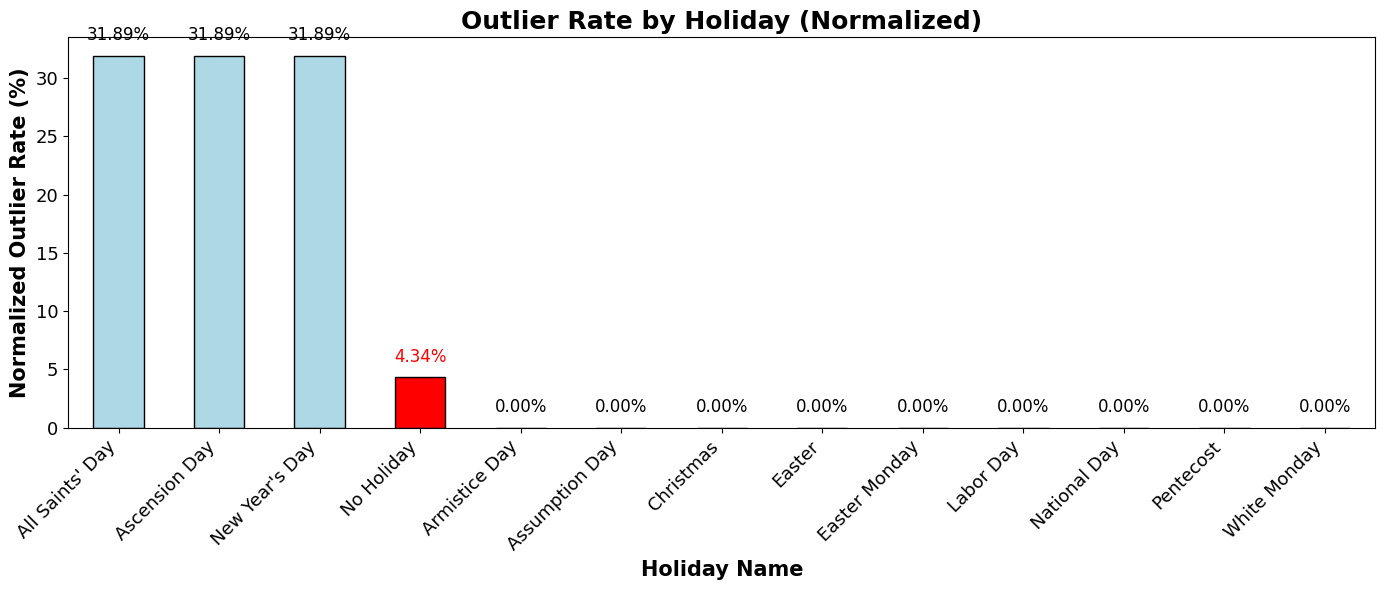

In [49]:
import matplotlib.pyplot as plt

# Calculate total days per holiday
total_days_by_holiday = daily_grouped_df2.groupby('Holiday_Name')['Date'].nunique()

# Calculate outliers per holiday
outlier_counts_holiday = daily_grouped_df2.groupby('Holiday_Name')['Weather_Outlier_Day'].sum()

# Normalize outlier counts
normalized_holiday_outliers = outlier_counts_holiday / total_days_by_holiday

# Convert to percentage
holiday_outlier_percentage_norm = (normalized_holiday_outliers / normalized_holiday_outliers.sum()) * 100

# Sort for visualization
holiday_outlier_percentage_norm = holiday_outlier_percentage_norm.sort_values(ascending=False)

# Assign colors, highlight "No Holiday" in red
colors_holiday = ['lightblue' if 'No Holiday' not in category else 'red' for category in holiday_outlier_percentage_norm.index]

# Plot
plt.figure(figsize=(14, 6))
bars_holiday = holiday_outlier_percentage_norm.plot(kind='bar', color=colors_holiday, edgecolor='black')
plt.xlabel('Holiday Name', fontsize=15, fontweight='bold')
plt.ylabel('Normalized Outlier Rate (%)', fontsize=15, fontweight='bold')
plt.title('Outlier Rate by Holiday (Normalized)', fontsize=18, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=13)
plt.yticks(fontsize=13)

# Add percentage labels on top of each bar, with "No Holiday" in red
for i, category in enumerate(holiday_outlier_percentage_norm.index):
    height = holiday_outlier_percentage_norm.iloc[i]
    color = 'red' if 'No Holiday' in category else 'black'
    plt.text(i, height + 1, f'{height:.2f}%', ha='center', va='bottom', fontsize=12, color=color)

plt.tight_layout()
plt.show()


In [43]:
# Step 1: Filter only outlier days
df_outlier_days = daily_grouped_df2[daily_grouped_df2['Weather_Outlier_Day'] == 1].copy()

# Step 2: Assign only the allowed DER combinations (all others set to None)
def der_combo_restricted(row):
    hp = row['Heat_Pump_Indicator']
    ev = row['Electric_Vehicle_Indicator']
    pv = row['PV_Installation_Indicator']

    if (pv == 1) and (hp == 0) and (ev == 0):
        return "Solar Only"
    elif (pv == 0) and (hp == 0) and (ev == 0):
        return "No Solar"
    elif (pv == 1) and (hp == 1) and (ev == 0):
        return "Solar + Heat Pump"
    elif (pv == 1) and (hp == 0) and (ev == 1):
        return "Solar + EV"
    elif (pv == 0) and (hp == 0) and (ev == 1):
        return "No Solar + EV"
    else:
        return None  # Exclude all other combinations

df_outlier_days['DER_Combination'] = df_outlier_days.apply(der_combo_restricted, axis=1)

# Step 3: Keep only the allowed DER combinations for plotting
df_plot = df_outlier_days[df_outlier_days['DER_Combination'].notna()].copy()
df_plot

,EAN_ID,Date,Volume_Consumption_kWh,Heat_Pump_Indicator,Electric_Vehicle_Indicator,PV_Installation_Indicator,Month,Day_Type,Outlier_Day,Day_of_Week_Name,School_Holiday_Name,Holiday_Name,Weather_Outlier_Day,DER_Combination
0,1,2022-01-01,38.319,0,1,0,1,Holiday,0,Saturday,Christmas holiday,New Year's Day,1,No Solar + EV
1,1,2022-01-02,28.035,0,1,0,1,Weekend,0,Sunday,Christmas holiday,No Holiday,1,No Solar + EV
4,1,2022-01-05,28.703,0,1,0,1,Weekday,0,Wednesday,Christmas holiday,No Holiday,1,No Solar + EV
34,1,2022-02-04,83.160,0,1,0,2,Weekday,0,Friday,No School Holiday,No Holiday,1,No Solar + EV
37,1,2022-02-07,68.189,0,1,0,2,Weekday,0,Monday,No School Holiday,No Holiday,1,No Solar + EV
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
474465,1300,2022-11-27,15.711,0,1,1,11,Weekend,0,Sunday,No School Holiday,No Holiday,1,Solar + EV
474480,1300,2022-12-12,15.445,0,1,1,12,Weekday,0,Monday,No School Holiday,No Holiday,1,Solar + EV
474484,1300,2022-12-16,15.937,0,1,1,12,Weekday,0,Friday,No School Holiday,No Holiday,1,Solar + EV
474495,1300,2022-12-27,14.692,0,1,1,12,Weekday,0,Tuesday,Christmas holiday,No Holiday,1,Solar + EV


/var/folders/f9/kb29rl2j2ds719xv7tc90db00000gp/T/ipykernel_27917/3263247924.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10', len(allowed_der_combos))


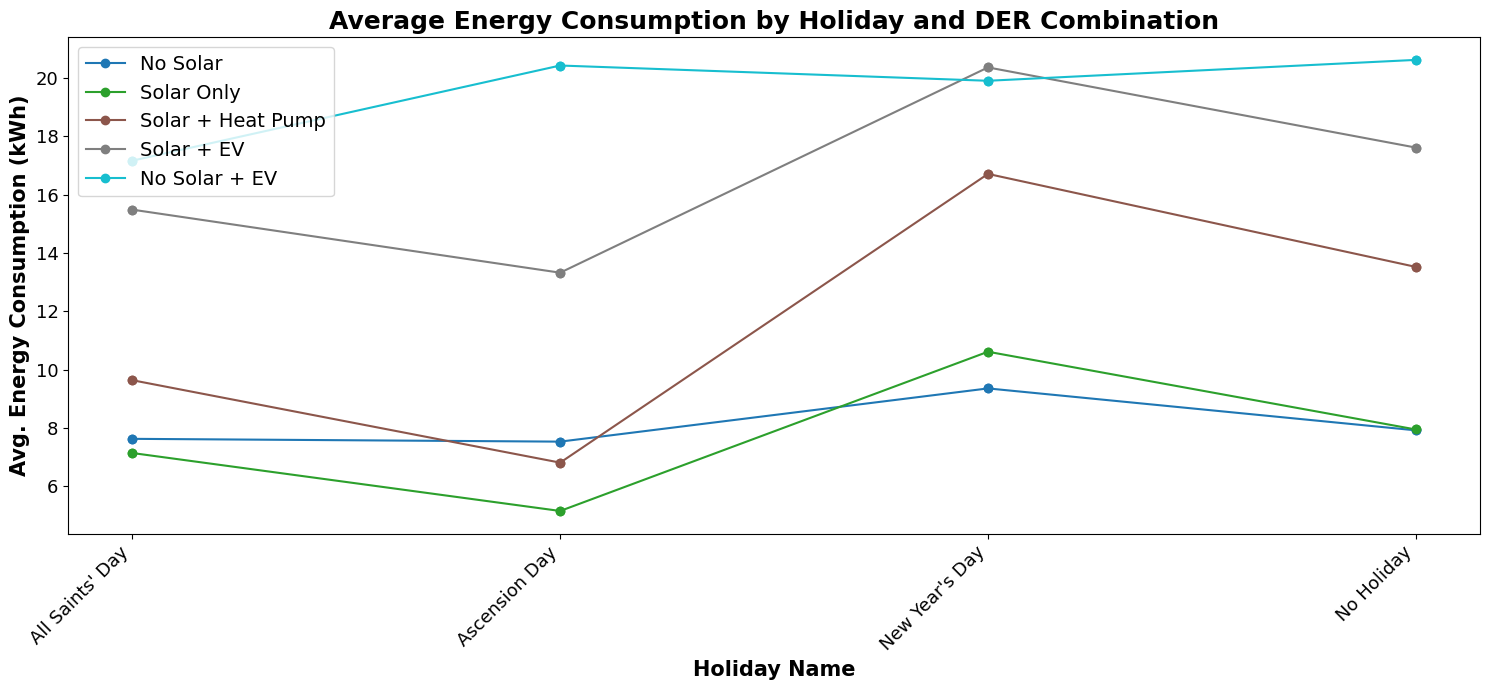

In [45]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Summarize: group by Holiday_Name and DER_Combination
summary_holiday = (
    df_plot.groupby(['Holiday_Name', 'DER_Combination'])
    .agg(
        Outlier_Days=('Weather_Outlier_Day', 'sum'),
        Avg_Energy_Consumption=('Volume_Consumption_kWh', 'mean')
    )
    .reset_index()
)

# Define the DER combinations you want to include in the plot
desired_der_combos = [
    "No Solar",
    "Solar Only",
    "Solar + Heat Pump",
    "Solar + EV",
    "No Solar + EV"
]
# Only use those present in your dataset
allowed_der_combos = [c for c in desired_der_combos if c in summary_holiday['DER_Combination'].unique()]

# Pivot for plotting
pivot_holiday = summary_holiday.pivot(
    index='Holiday_Name',
    columns='DER_Combination',
    values='Avg_Energy_Consumption'
).fillna(0)

pivot_holiday = pivot_holiday[allowed_der_combos]

# Optional: Order holidays as you wish, or default order in data
holiday_order = list(pivot_holiday.index)

colors = cm.get_cmap('tab10', len(allowed_der_combos))

plt.figure(figsize=(15, 7))

for idx, der in enumerate(allowed_der_combos):
    yvals = pivot_holiday.loc[holiday_order, der].values
    plt.plot(
        holiday_order,
        yvals,
        marker='o',
        linestyle='-',
        label=der,
        color=colors(idx)
    )
    # Optional: add point markers
    for i, val in enumerate(yvals):
        if val > 0:
            plt.scatter(i, val, color=colors(idx), zorder=3)

plt.xlabel('Holiday Name', fontsize=15, fontweight='bold')
plt.ylabel('Avg. Energy Consumption (kWh)', fontsize=15, fontweight='bold')
plt.title('Average Energy Consumption by Holiday and DER Combination', fontsize=18, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=13)
plt.yticks(fontsize=13)
plt.legend(
    loc='upper left',  # Try 'upper left', 'lower left', etc. as needed
    fontsize=14,
    title_fontsize=15,
    frameon=True  # (optional) to make legend background easier to read
)
plt.tight_layout()
plt.show()


## School Holiday vs WOD

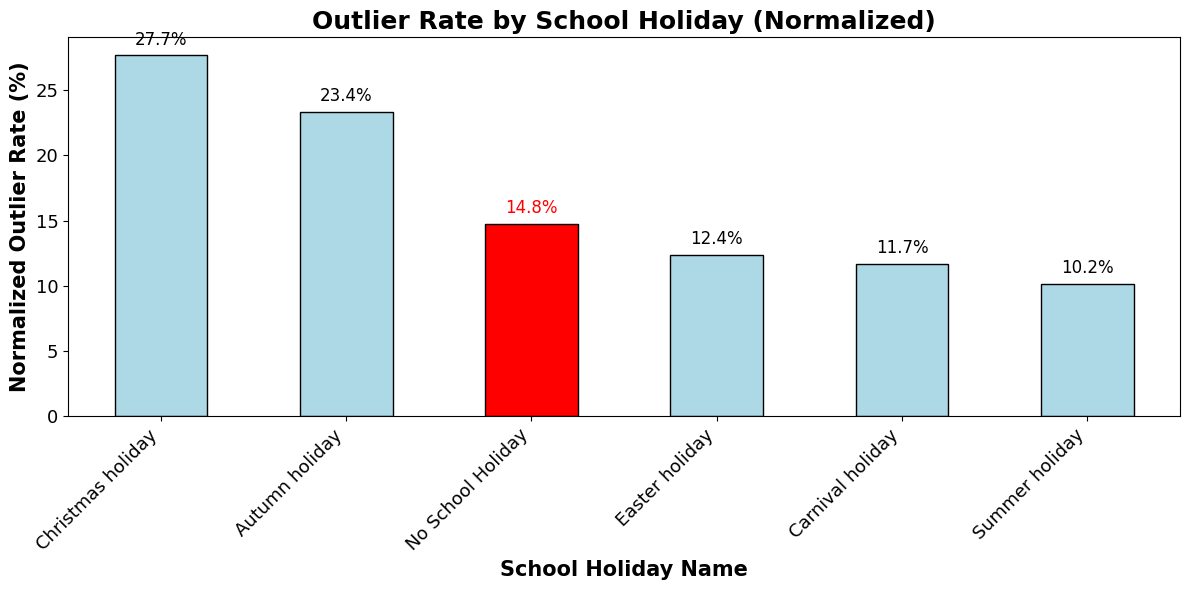

In [47]:
import matplotlib.pyplot as plt

# Count total days for each School_Holiday_Name
total_days_per_school_holiday = daily_grouped_df2.groupby('School_Holiday_Name')['Date'].nunique()

# Count total outlier days per School_Holiday_Name
holiday_outlier_counts = daily_grouped_df2.groupby('School_Holiday_Name')['Weather_Outlier_Day'].sum()

# Normalize by total days for each School Holiday
normalized_outliers = holiday_outlier_counts / total_days_per_school_holiday

# Calculate percentage of outlier days relative to total outliers
outlier_percentage = (normalized_outliers / normalized_outliers.sum()) * 100

# Sort for clarity
outlier_percentage = outlier_percentage.sort_values(ascending=False)

# Assign colors: red for "No School Holiday", lightblue otherwise
colors_school = ['red' if 'No School Holiday' in category else 'lightblue' for category in outlier_percentage.index]

plt.figure(figsize=(12, 6))
bars = outlier_percentage.plot(kind='bar', color=colors_school, edgecolor='black')

# Bigger, bold axes and title
plt.xlabel('School Holiday Name', fontsize=15, fontweight='bold')
plt.ylabel('Normalized Outlier Rate (%)', fontsize=15, fontweight='bold')
plt.title('Outlier Rate by School Holiday (Normalized)', fontsize=18, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=13)
plt.yticks(fontsize=13)

# Add percentage labels above each bar with color logic
for i, bar in enumerate(bars.patches):
    height = bar.get_height()
    # Red color for "No School Holiday", black otherwise
    label_color = 'red' if 'No School Holiday' in outlier_percentage.index[i] else 'black'
    plt.text(
        bar.get_x() + bar.get_width() / 2, height + 0.5, f'{height:.1f}%',
        ha='center', va='bottom', fontsize=12, color=label_color
    )

plt.tight_layout()
plt.show()


/var/folders/f9/kb29rl2j2ds719xv7tc90db00000gp/T/ipykernel_27917/344429837.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10', len(allowed_der_combos))


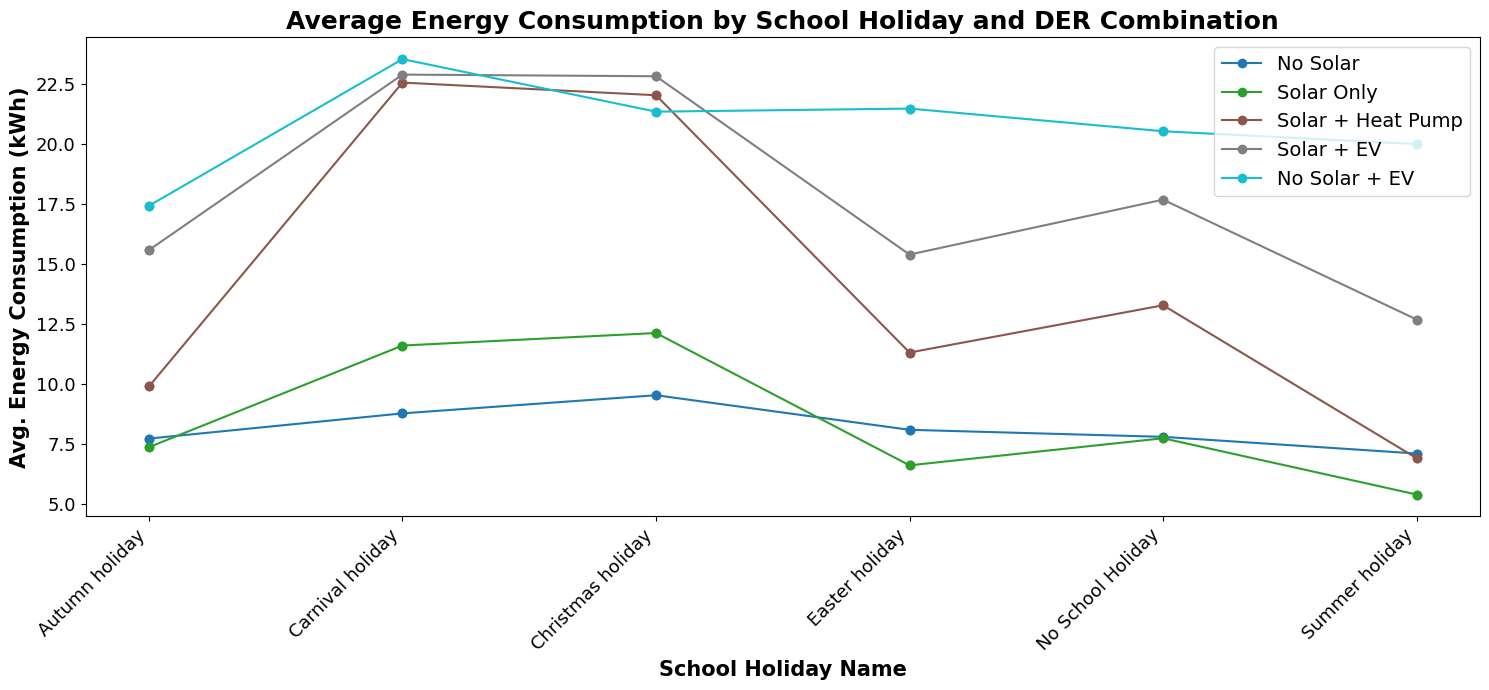

In [50]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Summarize: group by School_Holiday_Name and DER_Combination
summary_school = (
    df_plot.groupby(['School_Holiday_Name', 'DER_Combination'])
    .agg(
        Outlier_Days=('Weather_Outlier_Day', 'sum'),
        Avg_Energy_Consumption=('Volume_Consumption_kWh', 'mean')
    )
    .reset_index()
)

# List DER combinations to plot, filtered for those present in your data
desired_der_combos = [
    "No Solar",
    "Solar Only",
    "Solar + Heat Pump",
    "Solar + EV",
    "No Solar + EV"
]
allowed_der_combos = [c for c in desired_der_combos if c in summary_school['DER_Combination'].unique()]

# Pivot for plotting
pivot_school = summary_school.pivot(
    index='School_Holiday_Name',
    columns='DER_Combination',
    values='Avg_Energy_Consumption'
).fillna(0)

pivot_school = pivot_school[allowed_der_combos]

# Order holidays, or just plot as they appear
school_holiday_order = list(pivot_school.index)

colors = cm.get_cmap('tab10', len(allowed_der_combos))

plt.figure(figsize=(15, 7))

for idx, der in enumerate(allowed_der_combos):
    yvals = pivot_school.loc[school_holiday_order, der].values
    plt.plot(
        school_holiday_order,
        yvals,
        marker='o',
        linestyle='-',
        label=der,
        color=colors(idx)
    )
    # Optional: add point markers
    for i, val in enumerate(yvals):
        if val > 0:
            plt.scatter(i, val, color=colors(idx), zorder=3)

plt.xlabel('School Holiday Name', fontsize=15, fontweight='bold')
plt.ylabel('Avg. Energy Consumption (kWh)', fontsize=15, fontweight='bold')
plt.title('Average Energy Consumption by School Holiday and DER Combination', fontsize=18, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=13)
plt.yticks(fontsize=13)

# Legend INSIDE the plot
plt.legend(
    loc='upper right',  # Try 'upper left', 'lower right', 'center right', etc. to fit your plot
    fontsize=14,
    title_fontsize=15,
    frameon=True
)

plt.tight_layout()
plt.show()


## Months vs WOD

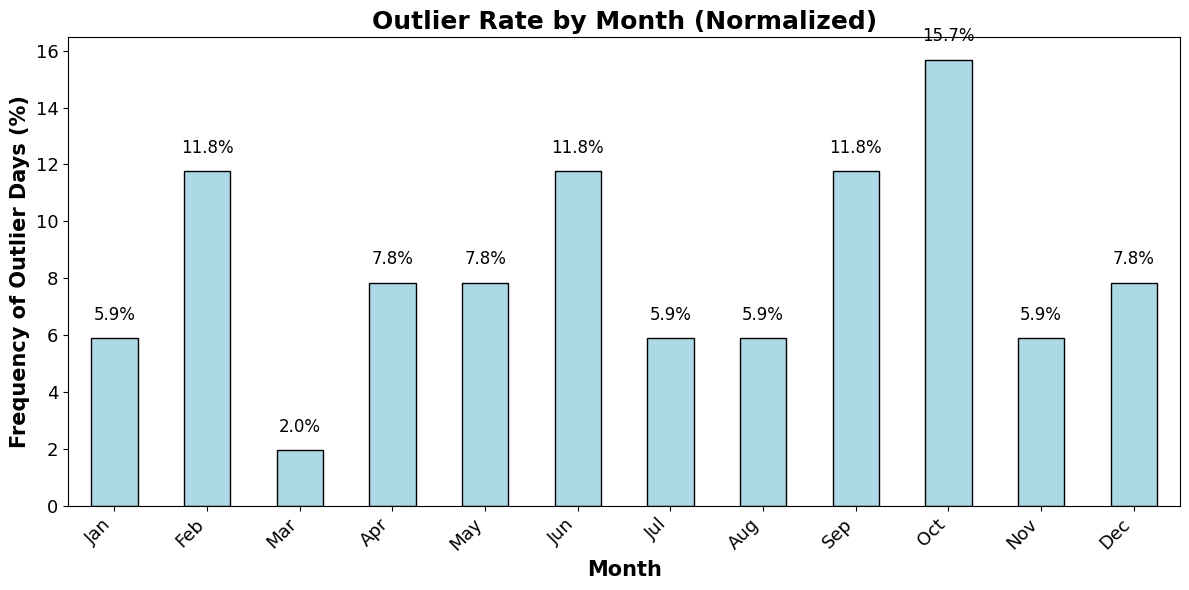

In [51]:
import matplotlib.pyplot as plt

# Month number to abbreviation
month_map = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 
             7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}

# Group and calculate outlier percentages by month
holiday_outlier_counts = daily_grouped_df2.groupby('Month')['Weather_Outlier_Day'].sum()
holiday_outlier_percentage = (holiday_outlier_counts / holiday_outlier_counts.sum()) * 100
holiday_outlier_percentage = holiday_outlier_percentage.sort_index()  # keep Jan-Dec order

# Map to abbreviations for plotting and reset index for bar labels
holiday_outlier_percentage.index = holiday_outlier_percentage.index.map(month_map)

plt.figure(figsize=(12, 6))
bars = holiday_outlier_percentage.plot(kind='bar', color='lightblue', edgecolor='black')

plt.xlabel('Month', fontsize=15, fontweight='bold')
plt.ylabel('Frequency of Outlier Days (%)', fontsize=15, fontweight='bold')
plt.title('Outlier Rate by Month (Normalized)', fontsize=18, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=13)
plt.yticks(fontsize=13)

for bar in bars.patches:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.5, f'{height:.1f}%',
             ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()


/var/folders/f9/kb29rl2j2ds719xv7tc90db00000gp/T/ipykernel_27917/1329425088.py:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10', len(allowed_der_combos))


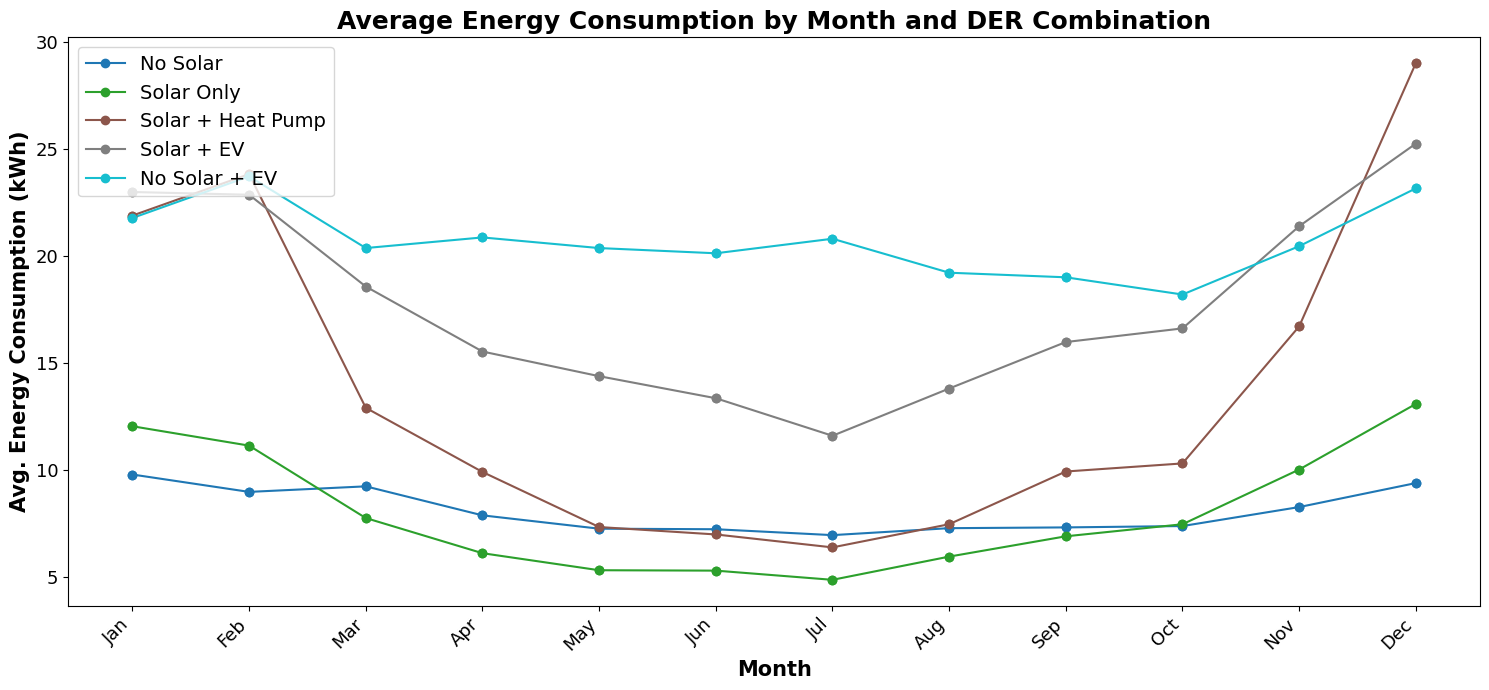

In [52]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import calendar

# Summarize: group by Month and DER_Combination
summary_month = (
    df_plot.groupby(['Month', 'DER_Combination'])
    .agg(
        Outlier_Days=('Weather_Outlier_Day', 'sum'),
        Avg_Energy_Consumption=('Volume_Consumption_kWh', 'mean')
    )
    .reset_index()
)

# List DER combinations to plot, filtered for those present in your data
desired_der_combos = [
    "No Solar",
    "Solar Only",
    "Solar + Heat Pump",
    "Solar + EV",
    "No Solar + EV"
]
allowed_der_combos = [c for c in desired_der_combos if c in summary_month['DER_Combination'].unique()]

# Pivot for plotting
pivot_month = summary_month.pivot(
    index='Month',
    columns='DER_Combination',
    values='Avg_Energy_Consumption'
).fillna(0)

pivot_month = pivot_month[allowed_der_combos]

# X-axis: month as number, and then as string abbreviation
month_nums = list(pivot_month.index)
month_labels = [calendar.month_abbr[m] for m in month_nums]

colors = cm.get_cmap('tab10', len(allowed_der_combos))

plt.figure(figsize=(15, 7))

for idx, der in enumerate(allowed_der_combos):
    yvals = pivot_month[der].values
    plt.plot(
        month_nums,
        yvals,
        marker='o',
        linestyle='-',
        label=der,
        color=colors(idx)
    )
    # Optional: add point markers
    for i, val in enumerate(yvals):
        if val > 0:
            plt.scatter(month_nums[i], val, color=colors(idx), zorder=3)

plt.xlabel('Month', fontsize=15, fontweight='bold')
plt.ylabel('Avg. Energy Consumption (kWh)', fontsize=15, fontweight='bold')
plt.title('Average Energy Consumption by Month and DER Combination', fontsize=18, fontweight='bold')
plt.xticks(ticks=month_nums, labels=month_labels, rotation=45, ha='right', fontsize=13)
plt.yticks(fontsize=13)
plt.legend(
    # bbox_to_anchor=(1.01, 1),
    loc='upper left',
    fontsize=14,
    title_fontsize=15
)
plt.tight_layout()
plt.show()


## Day of the week vs WOD

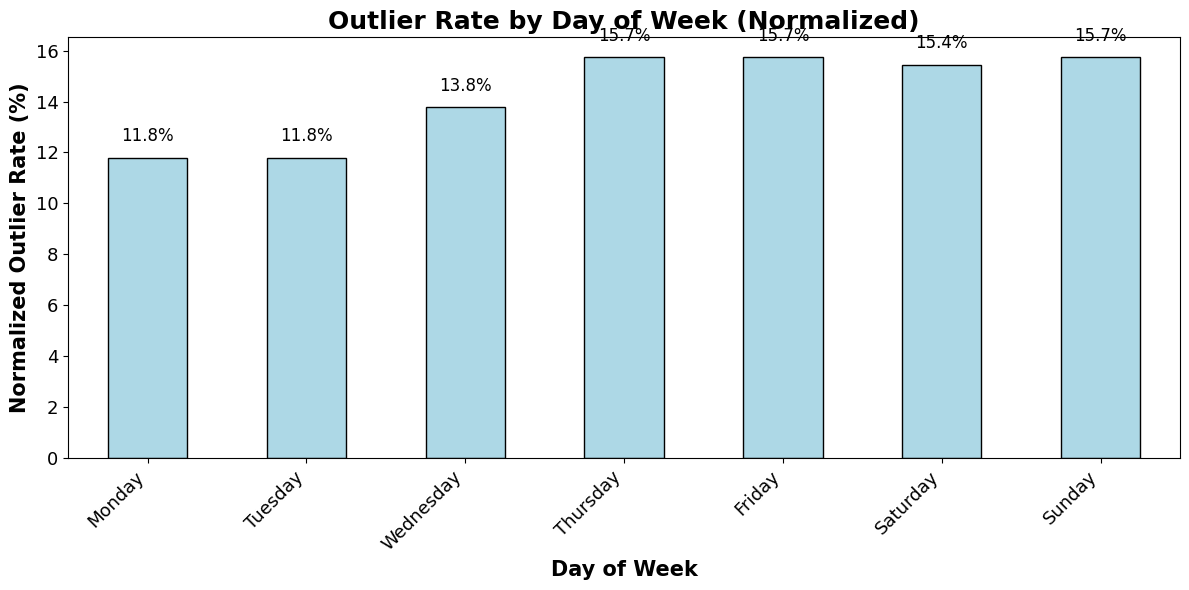

In [53]:
import matplotlib.pyplot as plt

# Standard order of days for x-axis
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Count total days for each day of the week
total_days_per_day_of_week = daily_grouped_df2.groupby('Day_of_Week_Name')['Date'].nunique()

# Count total outlier days per day of the week
holiday_outlier_counts = daily_grouped_df2.groupby('Day_of_Week_Name')['Weather_Outlier_Day'].sum()

# Normalize by total days for each day of the week
normalized_outliers = holiday_outlier_counts / total_days_per_day_of_week

# Calculate percentage of outliers relative to total normalized outliers
outlier_percentage = (normalized_outliers / normalized_outliers.sum()) * 100

# Reorder for correct weekday order (will drop days not in data)
outlier_percentage = outlier_percentage.reindex(day_order)

# Plot
plt.figure(figsize=(12, 6))
bars = outlier_percentage.plot(kind='bar', color='lightblue', edgecolor='black')

# Bigger, bolder axes and ticks
plt.xlabel('Day of Week', fontsize=15, fontweight='bold')
plt.ylabel('Normalized Outlier Rate (%)', fontsize=15, fontweight='bold')
plt.title('Outlier Rate by Day of Week (Normalized)', fontsize=18, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=13)
plt.yticks(fontsize=13)

# Add percentage labels above each bar
for bar in bars.patches:
    height = bar.get_height()
    if not pd.isna(height):
        plt.text(bar.get_x() + bar.get_width() / 2, height + 0.5, f'{height:.1f}%', 
                 ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()


/var/folders/f9/kb29rl2j2ds719xv7tc90db00000gp/T/ipykernel_27917/3121731879.py:40: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10', len(allowed_der_combos))


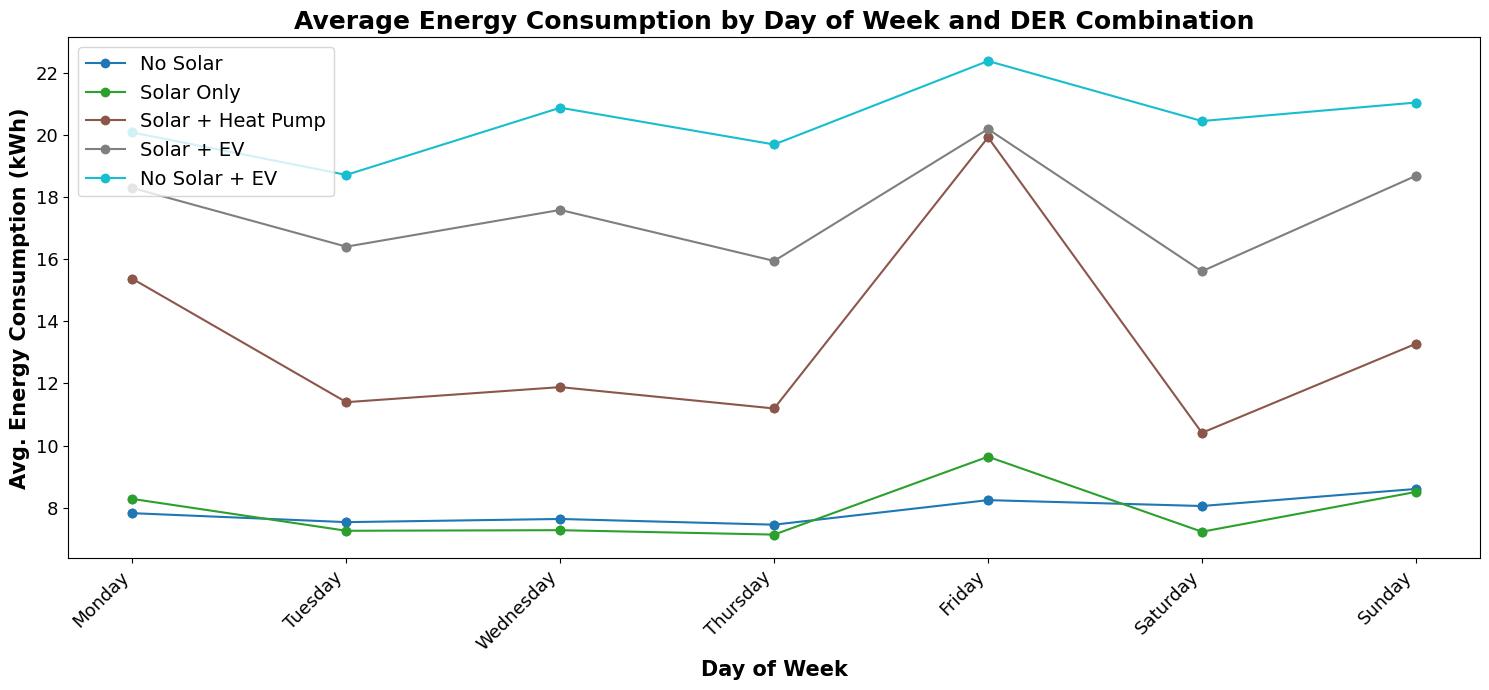

In [54]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Summarize: group by Day_of_Week_Name and DER_Combination
summary_weekday = (
    df_plot.groupby(['Day_of_Week_Name', 'DER_Combination'])
    .agg(
        Outlier_Days=('Weather_Outlier_Day', 'sum'),
        Avg_Energy_Consumption=('Volume_Consumption_kWh', 'mean')
    )
    .reset_index()
)

# Define DER combinations for the plot
desired_der_combos = [
    "No Solar",
    "Solar Only",
    "Solar + Heat Pump",
    "Solar + EV",
    "No Solar + EV"
]
# Only use those present in your dataset
allowed_der_combos = [c for c in desired_der_combos if c in summary_weekday['DER_Combination'].unique()]

# Pivot for plotting
pivot_weekday = summary_weekday.pivot(
    index='Day_of_Week_Name',
    columns='DER_Combination',
    values='Avg_Energy_Consumption'
).fillna(0)

pivot_weekday = pivot_weekday[allowed_der_combos]

# Order days of the week (customize if needed)
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
existing_order = [d for d in weekday_order if d in pivot_weekday.index]
others = [d for d in pivot_weekday.index if d not in weekday_order]
plot_order = existing_order + others

colors = cm.get_cmap('tab10', len(allowed_der_combos))

plt.figure(figsize=(15, 7))

for idx, der in enumerate(allowed_der_combos):
    yvals = pivot_weekday.loc[plot_order, der].values
    plt.plot(
        plot_order,
        yvals,
        marker='o',
        linestyle='-',
        label=der,
        color=colors(idx)
    )
    # Optional: add point markers
    for i, val in enumerate(yvals):
        if val > 0:
            plt.scatter(i, val, color=colors(idx), zorder=3)

plt.xlabel('Day of Week', fontsize=15, fontweight='bold')
plt.ylabel('Avg. Energy Consumption (kWh)', fontsize=15, fontweight='bold')
plt.title('Average Energy Consumption by Day of Week and DER Combination', fontsize=18, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=13)
plt.yticks(fontsize=13)
plt.legend(
    loc='upper left',
    fontsize=14,
    title_fontsize=15
)
plt.tight_layout()
plt.show()


## Day Type vs WOD

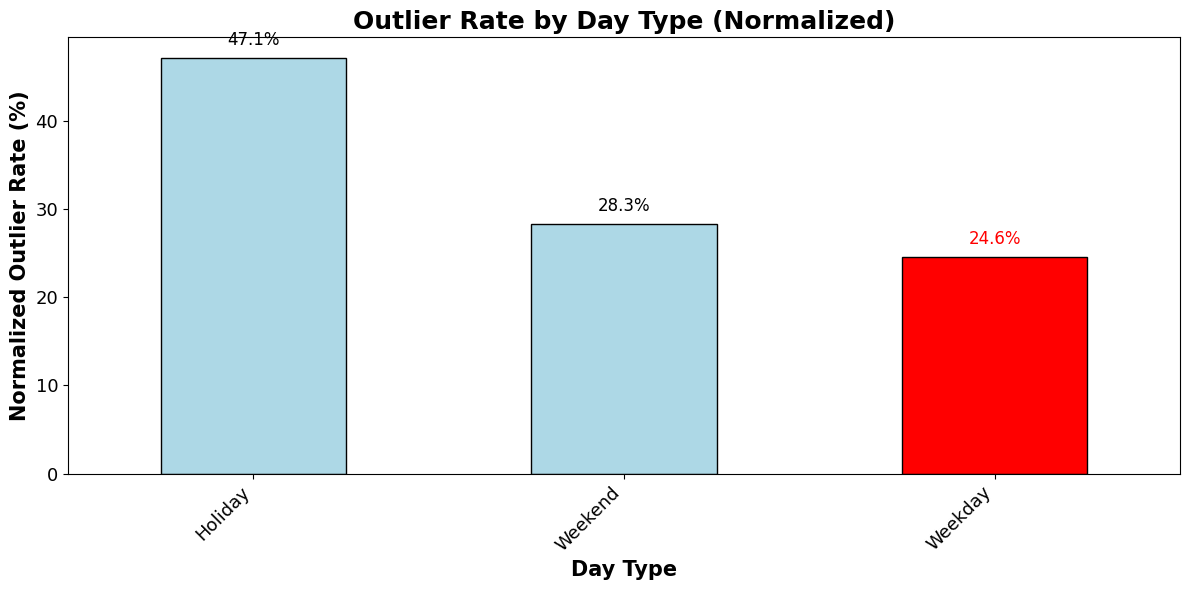

In [55]:
import matplotlib.pyplot as plt

# Count total days for each Day_Type
total_days_per_day_type = daily_grouped_df2.groupby('Day_Type')['Date'].nunique()

# Count total outlier days per Day_Type
holiday_outlier_counts = daily_grouped_df2.groupby('Day_Type')['Weather_Outlier_Day'].sum()

# Normalize by total days for each Day_Type
normalized_outliers = holiday_outlier_counts / total_days_per_day_type

# Calculate percentage of outliers relative to total outliers
outlier_percentage = (normalized_outliers / normalized_outliers.sum()) * 100

# Sort for better readability
outlier_percentage = outlier_percentage.sort_values(ascending=False)

# Assign colors, highlight "Weekday" in red
colors = ['red' if 'Weekday' in category else 'lightblue' for category in outlier_percentage.index]

# Plot
plt.figure(figsize=(12, 6))
bars = outlier_percentage.plot(kind='bar', color=colors, edgecolor='black')

# Bigger/bolder labels and title
plt.xlabel('Day Type', fontsize=15, fontweight='bold')
plt.ylabel('Normalized Outlier Rate (%)', fontsize=15, fontweight='bold')
plt.title('Outlier Rate by Day Type (Normalized)', fontsize=18, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=13)
plt.yticks(fontsize=13)

# Add percentage labels above each bar, red if Weekday
for i, category in enumerate(outlier_percentage.index):
    height = outlier_percentage.iloc[i]
    color = 'red' if 'Weekday' in category else 'black'
    plt.text(i, height + 1, f'{height:.1f}%', ha='center', va='bottom', fontsize=12, color=color)

plt.tight_layout()
plt.show()


/var/folders/f9/kb29rl2j2ds719xv7tc90db00000gp/T/ipykernel_27917/2724028087.py:40: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10', len(allowed_der_combos))


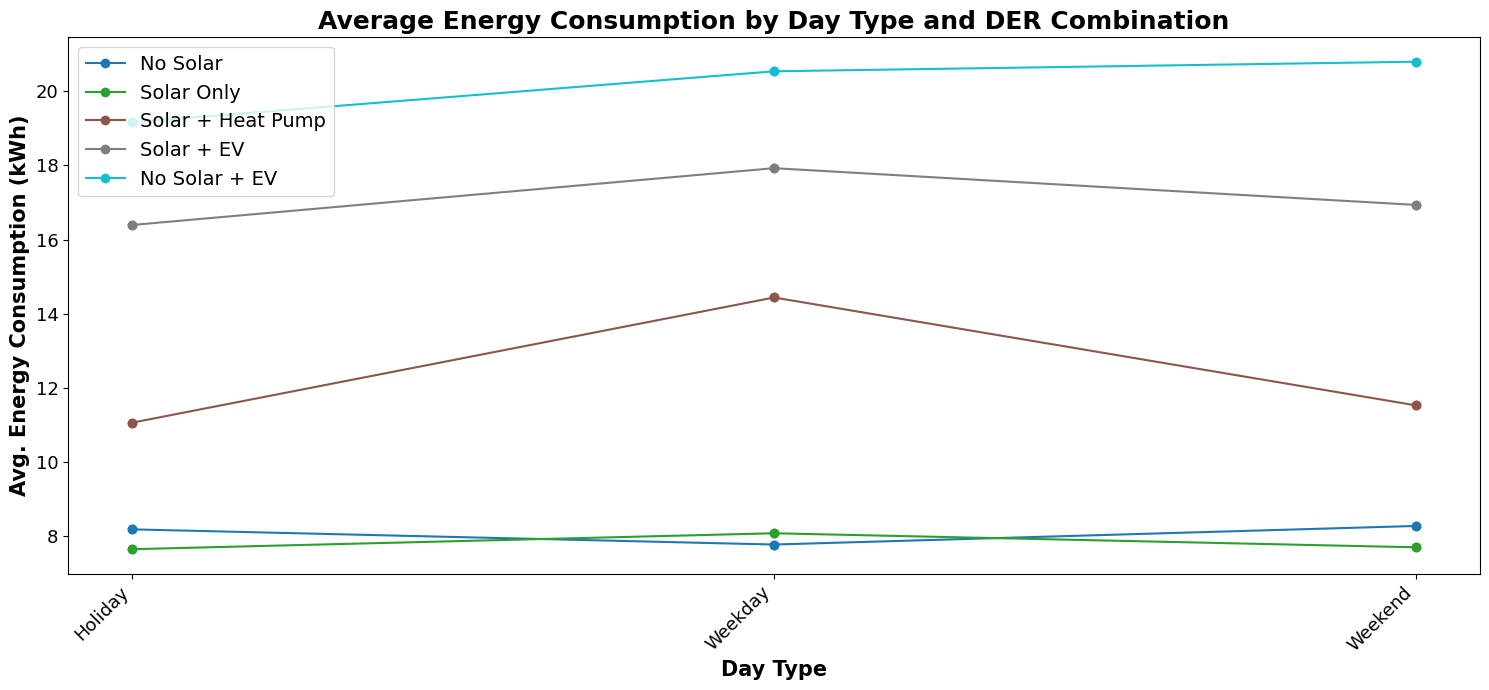

In [56]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Summarize: group by Day_Type and DER_Combination
summary_daytype = (
    df_plot.groupby(['Day_Type', 'DER_Combination'])
    .agg(
        Outlier_Days=('Weather_Outlier_Day', 'sum'),
        Avg_Energy_Consumption=('Volume_Consumption_kWh', 'mean')
    )
    .reset_index()
)

# Define your DER combinations to plot (update as needed)
desired_der_combos = [
    "No Solar",
    "Solar Only",
    "Solar + Heat Pump",
    "Solar + EV",
    "No Solar + EV"
]
# Filter for only those present in your data
allowed_der_combos = [c for c in desired_der_combos if c in summary_daytype['DER_Combination'].unique()]

# Pivot for plotting
pivot_daytype = summary_daytype.pivot(
    index='Day_Type',
    columns='DER_Combination',
    values='Avg_Energy_Consumption'
).fillna(0)

pivot_daytype = pivot_daytype[allowed_der_combos]

# Optional: Order Day_Type for x-axis. Adjust 'daytype_order' if you have custom day types.
daytype_order = ['Workday', 'Holiday', 'School Holiday']  # customize as needed
existing_order = [d for d in daytype_order if d in pivot_daytype.index]
others = [d for d in pivot_daytype.index if d not in daytype_order]
plot_order = existing_order + others

colors = cm.get_cmap('tab10', len(allowed_der_combos))

plt.figure(figsize=(15, 7))

for idx, der in enumerate(allowed_der_combos):
    yvals = pivot_daytype.loc[plot_order, der].values
    plt.plot(
        plot_order,
        yvals,
        marker='o',
        linestyle='-',
        label=der,
        color=colors(idx)
    )
    # Optional: add point markers
    for i, val in enumerate(yvals):
        if val > 0:
            plt.scatter(i, val, color=colors(idx), zorder=3)

plt.xlabel('Day Type', fontsize=15, fontweight='bold')
plt.ylabel('Avg. Energy Consumption (kWh)', fontsize=15, fontweight='bold')
plt.title('Average Energy Consumption by Day Type and DER Combination', fontsize=18, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=13)
plt.yticks(fontsize=13)
plt.legend(
    # bbox_to_anchor=(1.01, 1),
    loc='upper left',
    fontsize=14,
    title_fontsize=15
)
plt.tight_layout()
plt.show()


## Temp_Category vs WOD

In [81]:
grouped_df

,EAN_ID,Date,Volume_Consumption_kWh,Heat_Pump_Indicator,Electric_Vehicle_Indicator,PV_Installation_Indicator,Month,Day_Type,Outlier_Day,Day_of_Week_Name,School_Holiday_Name,Holiday_Name
0,1,2022-01-01,38.319,0,1,0,1,Holiday,0,Saturday,Christmas holiday,New Year's Day
1,1,2022-01-02,28.035,0,1,0,1,Weekend,0,Sunday,Christmas holiday,No Holiday
2,1,2022-01-03,32.127,0,1,0,1,Weekday,0,Monday,Christmas holiday,No Holiday
3,1,2022-01-04,33.375,0,1,0,1,Weekday,0,Tuesday,Christmas holiday,No Holiday
4,1,2022-01-05,28.703,0,1,0,1,Weekday,0,Wednesday,Christmas holiday,No Holiday
...,...,...,...,...,...,...,...,...,...,...,...,...
474495,1300,2022-12-27,14.692,0,1,1,12,Weekday,0,Tuesday,Christmas holiday,No Holiday
474496,1300,2022-12-28,17.499,0,1,1,12,Weekday,0,Wednesday,Christmas holiday,No Holiday
474497,1300,2022-12-29,22.014,0,1,1,12,Weekday,0,Thursday,Christmas holiday,No Holiday
474498,1300,2022-12-30,19.767,0,1,1,12,Weekday,0,Friday,Christmas holiday,No Holiday


In [82]:
grouped_df3=grouped_df

In [87]:
# Step 2: Assign only the allowed DER combinations (all others set to None)
def der_combo_restricted(row):
    hp = row['Heat_Pump_Indicator']
    ev = row['Electric_Vehicle_Indicator']
    pv = row['PV_Installation_Indicator']

    if (pv == 1) and (hp == 0) and (ev == 0):
        return "Solar Only"
    elif (pv == 0) and (hp == 0) and (ev == 0):
        return "No Solar"
    elif (pv == 1) and (hp == 1) and (ev == 0):
        return "Solar + Heat Pump"
    elif (pv == 1) and (hp == 0) and (ev == 1):
        return "Solar + EV"
    elif (pv == 0) and (hp == 0) and (ev == 1):
        return "No Solar + EV"
    else:
        return None  # Exclude all other combinations

grouped_df3['DER_Combination'] = grouped_df3.apply(der_combo_restricted, axis=1)
grouped_df3


,EAN_ID,Date,Volume_Consumption_kWh,Heat_Pump_Indicator,Electric_Vehicle_Indicator,PV_Installation_Indicator,Month,Day_Type,Outlier_Day,Day_of_Week_Name,School_Holiday_Name,Holiday_Name,DER_Combination
0,1,2022-01-01,38.319,0,1,0,1,Holiday,0,Saturday,Christmas holiday,New Year's Day,No Solar + EV
1,1,2022-01-02,28.035,0,1,0,1,Weekend,0,Sunday,Christmas holiday,No Holiday,No Solar + EV
2,1,2022-01-03,32.127,0,1,0,1,Weekday,0,Monday,Christmas holiday,No Holiday,No Solar + EV
3,1,2022-01-04,33.375,0,1,0,1,Weekday,0,Tuesday,Christmas holiday,No Holiday,No Solar + EV
4,1,2022-01-05,28.703,0,1,0,1,Weekday,0,Wednesday,Christmas holiday,No Holiday,No Solar + EV
...,...,...,...,...,...,...,...,...,...,...,...,...,...
474495,1300,2022-12-27,14.692,0,1,1,12,Weekday,0,Tuesday,Christmas holiday,No Holiday,Solar + EV
474496,1300,2022-12-28,17.499,0,1,1,12,Weekday,0,Wednesday,Christmas holiday,No Holiday,Solar + EV
474497,1300,2022-12-29,22.014,0,1,1,12,Weekday,0,Thursday,Christmas holiday,No Holiday,Solar + EV
474498,1300,2022-12-30,19.767,0,1,1,12,Weekday,0,Friday,Christmas holiday,No Holiday,Solar + EV


In [89]:
grouped_df3['DER_Combination']

0         No Solar + EV
1         No Solar + EV
2         No Solar + EV
3         No Solar + EV
4         No Solar + EV
              ...      
474495       Solar + EV
474496       Solar + EV
474497       Solar + EV
474498       Solar + EV
474499       Solar + EV
Name: DER_Combination, Length: 474500, dtype: object

In [90]:
agg_date_DER = grouped_df3.groupby(['Date','DER_Combination']).agg(
    Volume_Consumption_kWh=('Volume_Consumption_kWh', 'mean')
).reset_index()
agg_date_DER

,Date,DER_Combination,Volume_Consumption_kWh
0,2022-01-01,No Solar,9.352903
1,2022-01-01,No Solar + EV,19.909509
2,2022-01-01,Solar + EV,20.368167
3,2022-01-01,Solar + Heat Pump,16.713376
4,2022-01-01,Solar Only,10.611333
...,...,...,...
1820,2022-12-31,No Solar,9.599803
1821,2022-12-31,No Solar + EV,21.592910
1822,2022-12-31,Solar + EV,22.380114
1823,2022-12-31,Solar + Heat Pump,19.849117


In [93]:
# Pivot the DataFrame
pivot_df = agg_date_DER.pivot(index='Date', columns='DER_Combination', values='Volume_Consumption_kWh')

# To flatten MultiIndex columns after pivot, optionally rename columns
pivot_df.columns = ['DER_Combination_' + col.replace(' ', '_') for col in pivot_df.columns]

# Reset index if desired
pivot_df.reset_index(inplace=True)
pivot_df

,Date,DER_Combination_No_Solar,DER_Combination_No_Solar_+_EV,DER_Combination_Solar_+_EV,DER_Combination_Solar_+_Heat_Pump,DER_Combination_Solar_Only
0,2022-01-01,9.352903,19.909509,20.368167,16.713376,10.611333
1,2022-01-02,9.963760,21.413888,21.719530,19.608249,11.901827
2,2022-01-03,9.963240,21.858157,23.135399,23.189713,13.638293
3,2022-01-04,9.779130,20.981410,24.600714,25.662388,13.391947
4,2022-01-05,10.047632,24.013961,26.891650,29.351898,13.619346
...,...,...,...,...,...,...
360,2022-12-27,8.773823,19.893590,22.848297,24.729779,11.776183
361,2022-12-28,8.674031,21.518720,23.416597,23.245479,12.586473
362,2022-12-29,8.951282,20.276990,23.341680,22.534159,12.618490
363,2022-12-30,9.030593,21.003230,23.082770,24.339739,13.332510


In [197]:
final_merged

,Date,temperature_2m_i,relative_humidity_2m_i,precipitation_i,wind_speed_10m_i,cloud_cover_i,Weather_Outlier_Day,temperature_2m,relative_humidity_2m,precipitation,...,Day_Type,Energy_Outlier_Day,Day_of_Week_Name,School_Holiday_Name,Holiday_Name,Temp_Category,Precip_Category,Humidity_Category,Windspeed_Category,Cloudcover_Category
0,2022-01-01,0,0,0,0,1,1,11.950000,85.319515,0.008333,...,Holiday,0,Saturday,Christmas holiday,New Year's Day,Mild,No Rain,High,Strong,Mostly Cloudy
1,2022-01-02,0,0,0,0,1,1,11.545833,83.305570,0.312500,...,Weekend,0,Sunday,Christmas holiday,No Holiday,Mild,Light Rain,High,Strong,Mostly Cloudy
2,2022-01-05,0,0,0,0,1,1,4.137500,79.075873,0.166667,...,Weekday,0,Wednesday,Christmas holiday,No Holiday,Cold,Light Rain,High,Strong,Mostly Cloudy
3,2022-02-04,1,0,0,0,0,1,6.210417,84.229656,0.108333,...,Weekday,0,Friday,No School Holiday,No Holiday,Cold,Light Rain,High,Strong,Mostly Cloudy
4,2022-02-07,0,0,0,1,0,1,5.245833,71.389592,0.045833,...,Weekday,0,Monday,No School Holiday,No Holiday,Cold,No Rain,Moderate,Strong,Partly Cloudy
5,2022-02-10,0,0,0,0,1,1,5.527083,91.913268,0.120833,...,Weekday,0,Thursday,No School Holiday,No Holiday,Cold,Light Rain,Very High,Moderate,Overcast
6,2022-02-11,0,0,0,0,1,1,3.708333,79.253139,0.012500,...,Weekday,0,Friday,No School Holiday,No Holiday,Cold,No Rain,High,Fresh,Clear
7,2022-02-18,0,1,0,0,0,1,8.768750,73.633133,0.137500,...,Weekday,0,Friday,Carnival holiday,No Holiday,Mild,Light Rain,Moderate,Strong,Mostly Cloudy
8,2022-02-25,0,0,0,0,1,1,4.325000,72.653121,0.075000,...,Weekday,0,Friday,No School Holiday,No Holiday,Cold,No Rain,Moderate,Strong,Clear
9,2022-03-13,1,0,0,0,0,1,11.518750,65.225489,0.000000,...,Weekend,0,Sunday,No School Holiday,No Holiday,Mild,No Rain,Low,Strong,Overcast


In [198]:
# Ensure 'Date' columns are of the same type
final_merged['Date'] = pd.to_datetime(final_merged['Date'])
pivot_df['Date'] = pd.to_datetime(pivot_df['Date'])

# Merge on 'Date'
final_merged_with_ders = final_merged.merge(pivot_df, on='Date')
final_merged_with_ders

,Date,temperature_2m_i,relative_humidity_2m_i,precipitation_i,wind_speed_10m_i,cloud_cover_i,Weather_Outlier_Day,temperature_2m,relative_humidity_2m,precipitation,...,Temp_Category,Precip_Category,Humidity_Category,Windspeed_Category,Cloudcover_Category,DER_Combination_No_Solar,DER_Combination_No_Solar_+_EV,DER_Combination_Solar_+_EV,DER_Combination_Solar_+_Heat_Pump,DER_Combination_Solar_Only
0,2022-01-01,0,0,0,0,1,1,11.950000,85.319515,0.008333,...,Mild,No Rain,High,Strong,Mostly Cloudy,9.352903,19.909509,20.368167,16.713376,10.611333
1,2022-01-02,0,0,0,0,1,1,11.545833,83.305570,0.312500,...,Mild,Light Rain,High,Strong,Mostly Cloudy,9.963760,21.413888,21.719530,19.608249,11.901827
2,2022-01-05,0,0,0,0,1,1,4.137500,79.075873,0.166667,...,Cold,Light Rain,High,Strong,Mostly Cloudy,10.047632,24.013961,26.891650,29.351898,13.619346
3,2022-02-04,1,0,0,0,0,1,6.210417,84.229656,0.108333,...,Cold,Light Rain,High,Strong,Mostly Cloudy,9.114580,24.495833,25.177513,26.058920,12.168277
4,2022-02-07,0,0,0,1,0,1,5.245833,71.389592,0.045833,...,Cold,No Rain,Moderate,Strong,Partly Cloudy,9.037841,22.703072,22.475864,21.787913,10.366313
5,2022-02-10,0,0,0,0,1,1,5.527083,91.913268,0.120833,...,Cold,Light Rain,Very High,Moderate,Overcast,9.052799,23.083090,23.295824,25.378102,12.027619
6,2022-02-11,0,0,0,0,1,1,3.708333,79.253139,0.012500,...,Cold,No Rain,High,Fresh,Clear,8.974003,22.963283,21.816280,23.670425,10.627330
7,2022-02-18,0,1,0,0,0,1,8.768750,73.633133,0.137500,...,Mild,Light Rain,Moderate,Strong,Mostly Cloudy,8.791240,23.555875,22.910391,22.576679,11.617897
8,2022-02-25,0,0,0,0,1,1,4.325000,72.653121,0.075000,...,Cold,No Rain,Moderate,Strong,Clear,8.885959,25.539252,21.513149,23.518395,10.025172
9,2022-03-13,1,0,0,0,0,1,11.518750,65.225489,0.000000,...,Mild,No Rain,Low,Strong,Overcast,9.235460,20.373651,18.574683,12.906337,7.754123


/var/folders/f9/kb29rl2j2ds719xv7tc90db00000gp/T/ipykernel_27917/2336052106.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp_summary = final_merged.groupby('Temp_Category').agg(


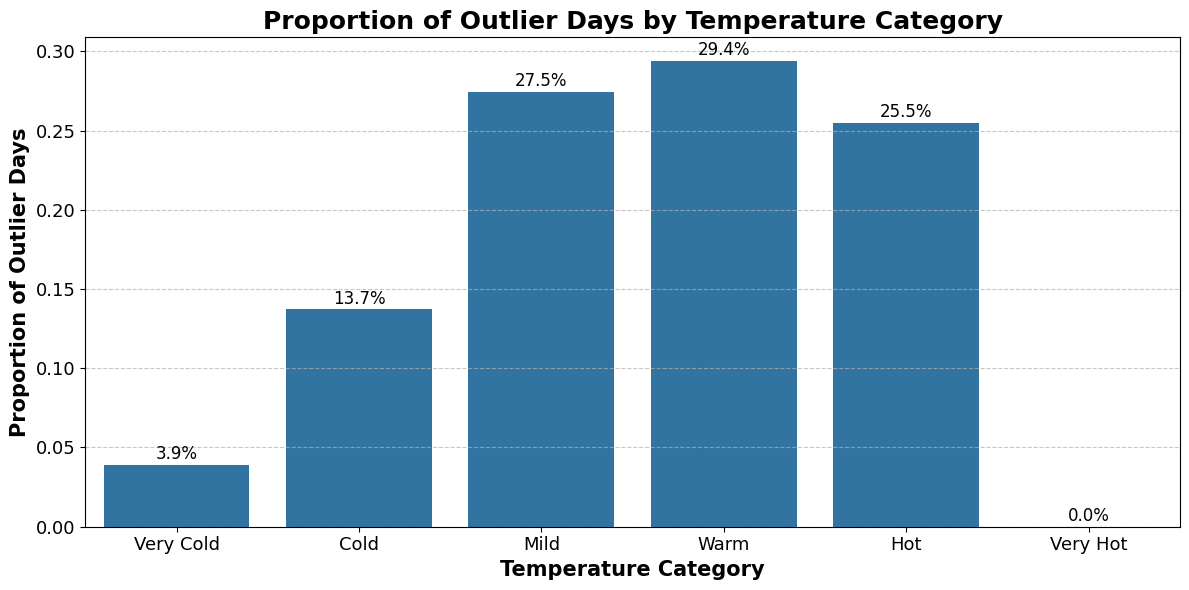

In [114]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assumed: final_merged contains 'temperature_2m' and 'Weather_Outlier_Day' == 1 for outliers only

# Define temperature bins and labels
bins = [-float('inf'), 0, 7, 12, 17, 25, float('inf')]
labels = ['Very Cold', 'Cold', 'Mild', 'Warm', 'Hot', 'Very Hot']

# Assign categories to each outlier record
final_merged['Temp_Category'] = pd.cut(final_merged['temperature_2m'], bins=bins, labels=labels)

# Count number of outliers per category
temp_summary = final_merged.groupby('Temp_Category').agg(
    Outlier_Count=('Weather_Outlier_Day', 'size')
).reset_index()

# Calculate proportion of outlier days in each category
total_outliers = temp_summary['Outlier_Count'].sum()
temp_summary['Proportion_Outlier'] = temp_summary['Outlier_Count'] / total_outliers

# Plot the proportion of outlier days by temperature category
plt.figure(figsize=(12, 6))
sns.barplot(x='Temp_Category', y='Proportion_Outlier', data=temp_summary)

plt.title("Proportion of Outlier Days by Temperature Category", fontsize=18, fontweight='bold')
plt.ylabel("Proportion of Outlier Days", fontsize=15, fontweight='bold')
plt.xlabel("Temperature Category", fontsize=15, fontweight='bold')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid(True, which='major', axis='y', linestyle='--', alpha=0.7)

# Add percentage labels above each bar
for index, row in temp_summary.iterrows():
    plt.text(index, row['Proportion_Outlier'] + 0.001, f"{row['Proportion_Outlier']:.1%}",
             ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()


In [122]:
# 2. Calculate total outliers and mean energy per Temp_Category
summary_temp = (
    final_merged_with_ders.groupby(['Temp_Category'])
    .agg(
        Outlier_Days=('Weather_Outlier_Day', 'sum'),
        DER_Combination_No_Solar=('DER_Combination_No_Solar', 'mean'),
        DER_Combination_Solar_Only=('DER_Combination_Solar_Only', 'mean'),
        DER_Combination_Solar_plus_Heat_Pump=('DER_Combination_Solar_+_Heat_Pump', 'mean'),
        DER_Combination_No_Solar_plus_EV=('DER_Combination_No_Solar_+_EV', 'mean'),
        DER_Combination_Solar_plus_EV=('DER_Combination_Solar_+_EV', 'mean')
    )
    .reset_index()
)
summary_temp

/var/folders/f9/kb29rl2j2ds719xv7tc90db00000gp/T/ipykernel_27917/3167947735.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  final_merged_with_ders.groupby(['Temp_Category'])


,Temp_Category,Outlier_Days,DER_Combination_No_Solar,DER_Combination_Solar_Only,DER_Combination_Solar_plus_Heat_Pump,DER_Combination_No_Solar_plus_EV,DER_Combination_Solar_plus_EV
0,Very Cold,2,9.590403,13.890002,35.740784,25.582135,27.895657
1,Cold,7,9.126663,11.515749,24.927919,23.241726,23.431225
2,Mild,14,8.186770,8.458141,14.135652,20.617870,18.672973
3,Warm,15,7.631398,6.921661,9.629567,19.241072,15.867344
4,Hot,13,7.094986,5.657617,7.223478,19.726632,13.504748
5,Very Hot,0,NaN,NaN,NaN,NaN,NaN


/var/folders/f9/kb29rl2j2ds719xv7tc90db00000gp/T/ipykernel_27917/2730921737.py:40: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10', len(existing_cols))


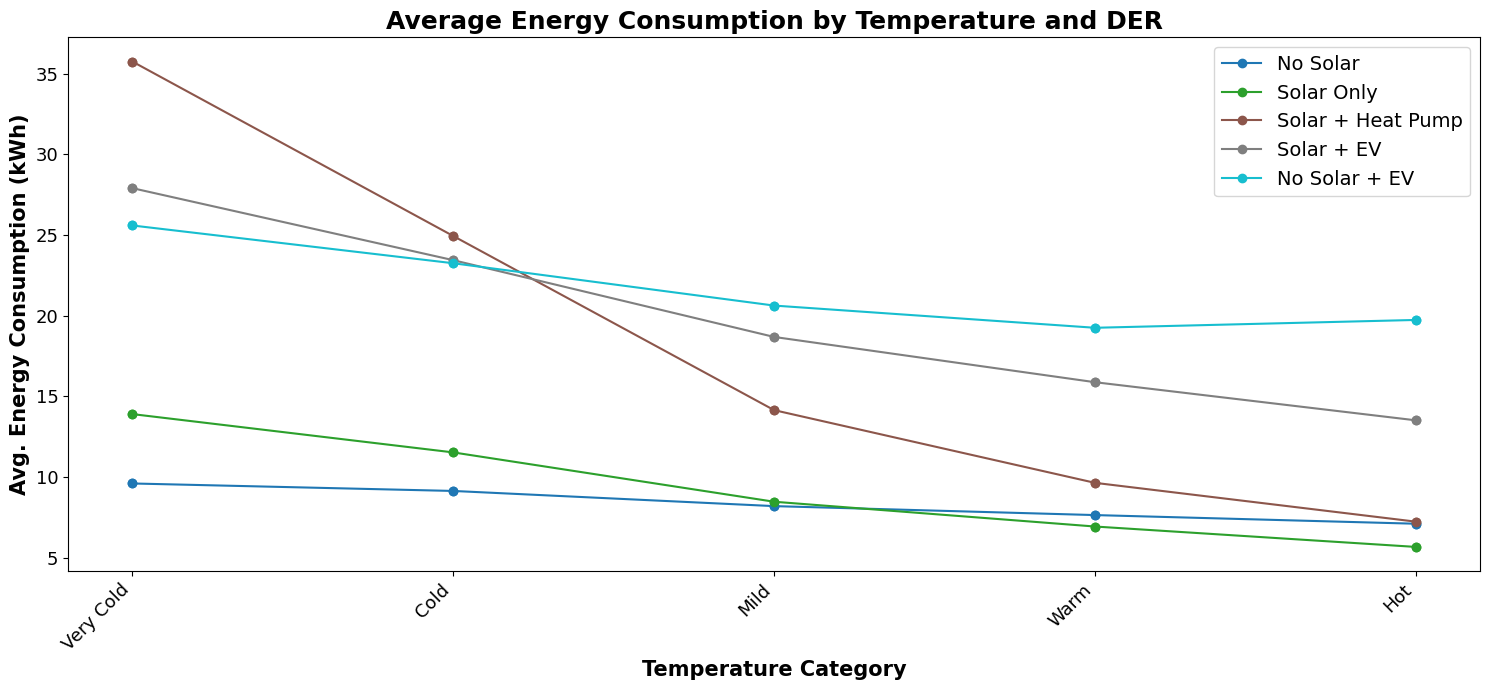

In [129]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# 1. Assign temperature categories in final_merged_with_ders
# Define temperature bins and labels
bins = [-float('inf'), 0, 7, 12, 17, 25, float('inf')]
labels = ['Very Cold', 'Cold', 'Mild', 'Warm', 'Hot', 'Very Hot']

final_merged_with_ders['Temp_Category'] = pd.cut(final_merged_with_ders['temperature_2m'], bins=bins, labels=labels)

# List of allowed DER combos, ensure they match column names in summary_temp
allowed_der_combos = [
    "DER_Combination_No_Solar",
    "DER_Combination_Solar_Only",
    "DER_Combination_Solar_plus_Heat_Pump",
    "DER_Combination_Solar_plus_EV",
    "DER_Combination_No_Solar_plus_EV"
]

# Filter columns (check if they exist)
existing_cols = [col for col in allowed_der_combos if col in summary_temp.columns]
summary_filtered = summary_temp[existing_cols]

# Define the order of temperature categories for plotting
temp_order = ['Very Cold', 'Cold', 'Mild', 'Warm', 'Hot', 'Very Hot']
existing_order = [cat for cat in temp_order if cat in summary_temp['Temp_Category'].values]
others = [cat for cat in summary_temp['Temp_Category'].values if cat not in temp_order]
plot_order = existing_order + others

labels_list = [
    "No Solar",
    "Solar Only",
    "Solar + Heat Pump",
    "Solar + EV",
    "No Solar + EV"
]

# Plot
colors = cm.get_cmap('tab10', len(existing_cols))
plt.figure(figsize=(15, 7))
for idx, der in enumerate(existing_cols):
    if der in summary_temp.columns:
        yvals = summary_temp.set_index('Temp_Category').loc[plot_order][der].values
        plt.plot(
            plot_order,
            yvals,
            marker='o',
            linestyle='-',
            label=labels_list[idx],
            color=colors(idx)
        )
        for i, val in enumerate(yvals):
            if val > 0:
                plt.scatter(plot_order[i], val, color=colors(idx), zorder=3)



plt.xlabel('Temperature Category', fontsize=15, fontweight='bold')
plt.ylabel('Avg. Energy Consumption (kWh)', fontsize=15, fontweight='bold')
plt.title('Average Energy Consumption by Temperature and DER', fontsize=18, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=13)
plt.yticks(fontsize=13)
plt.legend(loc='upper right', fontsize=14)
plt.tight_layout()
plt.show()


## Precip_Category vs WOD

/var/folders/f9/kb29rl2j2ds719xv7tc90db00000gp/T/ipykernel_27917/3741802237.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  precip_summary = final_merged.groupby('Precip_Category').agg(


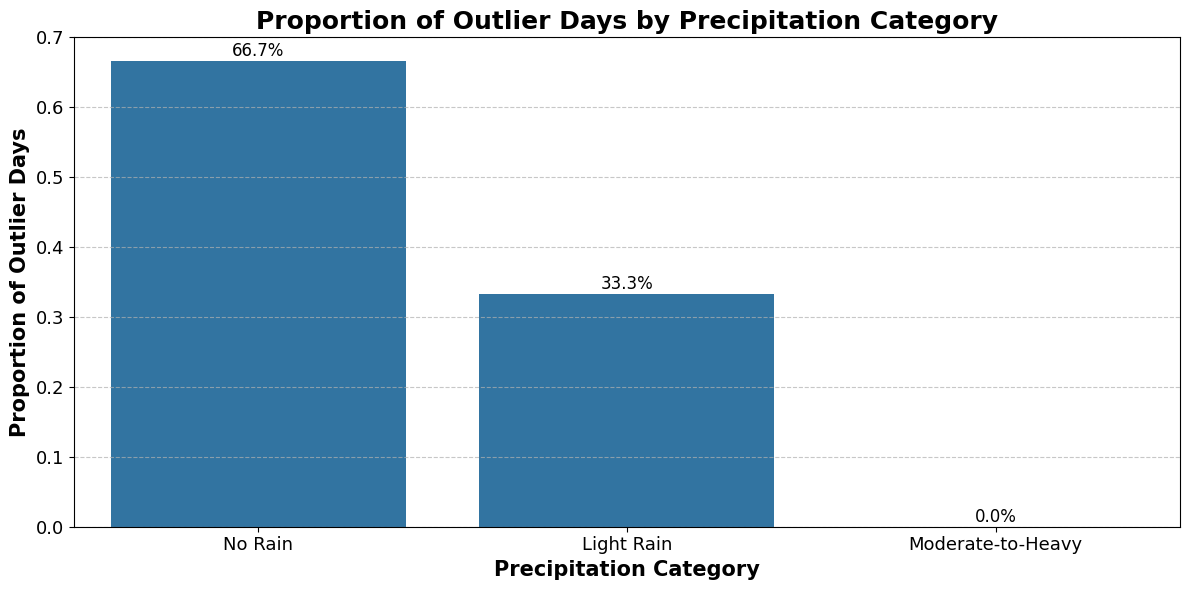

In [193]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define precipitation bins and labels
precip_bins = [float('-inf'), 0.075, 1.375, float('inf')]
precip_labels = ['No Rain', 'Light Rain', 'Moderate-to-Heavy']

# Assign categories to each outlier record
# Ensure 'precipitation' exists in your dataset
final_merged['Precip_Category'] = pd.cut(final_merged['precipitation'], bins=precip_bins, labels=precip_labels)

# Count number of outliers per precipitation category
precip_summary = final_merged.groupby('Precip_Category').agg(
    Outlier_Count=('Weather_Outlier_Day', 'size')
).reset_index()

# Calculate proportion of outlier days in each precip category
total_outliers_precip = precip_summary['Outlier_Count'].sum()
precip_summary['Proportion_Outlier'] = precip_summary['Outlier_Count'] / total_outliers_precip

# Plot the proportion
plt.figure(figsize=(12, 6))
sns.barplot(x='Precip_Category', y='Proportion_Outlier', data=precip_summary)

plt.title("Proportion of Outlier Days by Precipitation Category", fontsize=18, fontweight='bold')
plt.ylabel("Proportion of Outlier Days", fontsize=15, fontweight='bold')
plt.xlabel("Precipitation Category", fontsize=15, fontweight='bold')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid(True, which='major', axis='y', linestyle='--', alpha=0.7)

# Add percentage labels above each bar
for index, row in precip_summary.iterrows():
    plt.text(index, row['Proportion_Outlier'] + 0.001, f"{row['Proportion_Outlier']:.1%}",
             ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()


In [194]:
precip_summary

,Precip_Category,Outlier_Count,Proportion_Outlier
0,No Rain,34,0.666667
1,Light Rain,17,0.333333
2,Moderate-to-Heavy,0,0.000000


In [195]:
# Count number of outliers per precipitation category
precip_summary = final_merged_with_ders.groupby('Precip_Category').agg(
        Outlier_Days=('Weather_Outlier_Day', 'sum'),
        DER_Combination_No_Solar=('DER_Combination_No_Solar', 'mean'),
        DER_Combination_Solar_Only=('DER_Combination_Solar_Only', 'mean'),
        DER_Combination_Solar_plus_Heat_Pump=('DER_Combination_Solar_+_Heat_Pump', 'mean'),
        DER_Combination_No_Solar_plus_EV=('DER_Combination_No_Solar_+_EV', 'mean'),
        DER_Combination_Solar_plus_EV=('DER_Combination_Solar_+_EV', 'mean')
    ).reset_index()
precip_summary

/var/folders/f9/kb29rl2j2ds719xv7tc90db00000gp/T/ipykernel_27917/4117607834.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  precip_summary = final_merged_with_ders.groupby('Precip_Category').agg(


,Precip_Category,Outlier_Days,DER_Combination_No_Solar,DER_Combination_Solar_Only,DER_Combination_Solar_plus_Heat_Pump,DER_Combination_No_Solar_plus_EV,DER_Combination_Solar_plus_EV
0,No Rain,16,7.806923,7.757773,12.95928,19.892925,17.024145
1,Light Rain,17,8.407342,9.539276,16.34336,21.255751,20.062871
2,Moderate-to-Heavy,0,NaN,NaN,NaN,NaN,NaN


/var/folders/f9/kb29rl2j2ds719xv7tc90db00000gp/T/ipykernel_27917/989823275.py:39: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10', len(existing_cols))


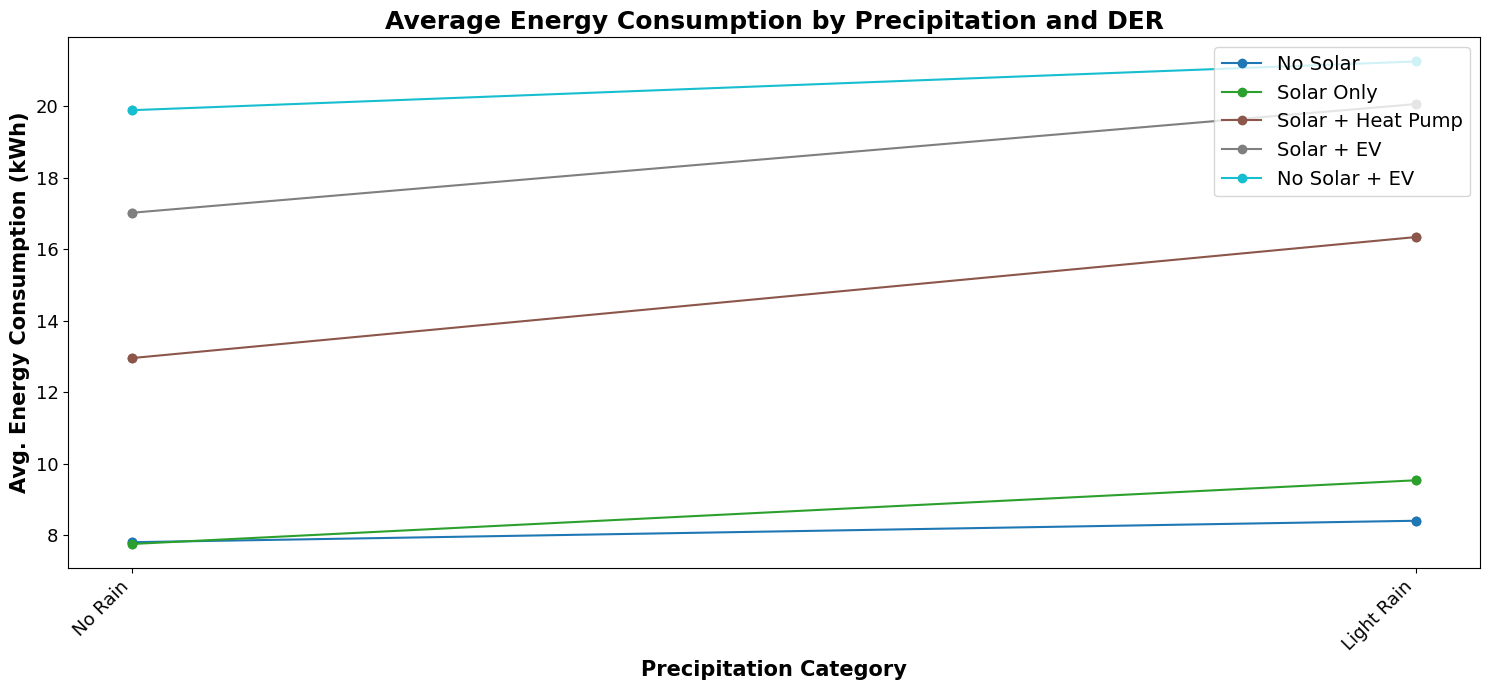

In [196]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# 1. Assign temperature categories in final_merged_with_ders
# Define precipitation bins and labels
precip_bins = [0, 0.075, 1.375, float('inf')]
precip_labels = ['No Rain', 'Light Rain', 'Moderate-to-Heavy']
final_merged_with_ders['Temp_Category'] = pd.cut(final_merged_with_ders['precipitation'], bins=precip_bins, labels=precip_labels)

#List of allowed DER combos, ensure they match column names in summary_temp
allowed_der_combos = [
    "DER_Combination_No_Solar",
    "DER_Combination_Solar_Only",
    "DER_Combination_Solar_plus_Heat_Pump",
    "DER_Combination_Solar_plus_EV",
    "DER_Combination_No_Solar_plus_EV"
]

# Filter columns (check if they exist)
existing_cols = [col for col in allowed_der_combos if col in precip_summary.columns]
summary_filtered = precip_summary[existing_cols]

# Define the order of temperature categories for plotting
temp_order = ['No Rain', 'Light Rain', 'Moderate-to-Heavy']
existing_order = [cat for cat in temp_order if cat in precip_summary['Precip_Category'].values]
others = [cat for cat in precip_summary['Precip_Category'].values if cat not in temp_order]
plot_order = existing_order + others

labels_list = [
    "No Solar",
    "Solar Only",
    "Solar + Heat Pump",
    "Solar + EV",
    "No Solar + EV"
]

# Plot
colors = cm.get_cmap('tab10', len(existing_cols))
plt.figure(figsize=(15, 7))
for idx, der in enumerate(existing_cols):
    if der in precip_summary.columns:
        yvals = precip_summary.set_index('Precip_Category').loc[plot_order][der].values
        plt.plot(
            plot_order,
            yvals,
            marker='o',
            linestyle='-',
            label=labels_list[idx],
            color=colors(idx)
        )
        for i, val in enumerate(yvals):
            if val > 0:
                plt.scatter(plot_order[i], val, color=colors(idx), zorder=3)



plt.xlabel('Precipitation Category', fontsize=15, fontweight='bold')
plt.ylabel('Avg. Energy Consumption (kWh)', fontsize=15, fontweight='bold')
plt.title('Average Energy Consumption by Precipitation and DER', fontsize=18, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=13)
plt.yticks(fontsize=13)
plt.legend(loc='upper right', fontsize=14)
plt.tight_layout()
plt.show()


## Humidity_Category vs WOD

/var/folders/f9/kb29rl2j2ds719xv7tc90db00000gp/T/ipykernel_27917/2778670824.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  humidity_summary = final_merged.groupby('Humidity_Category').agg(


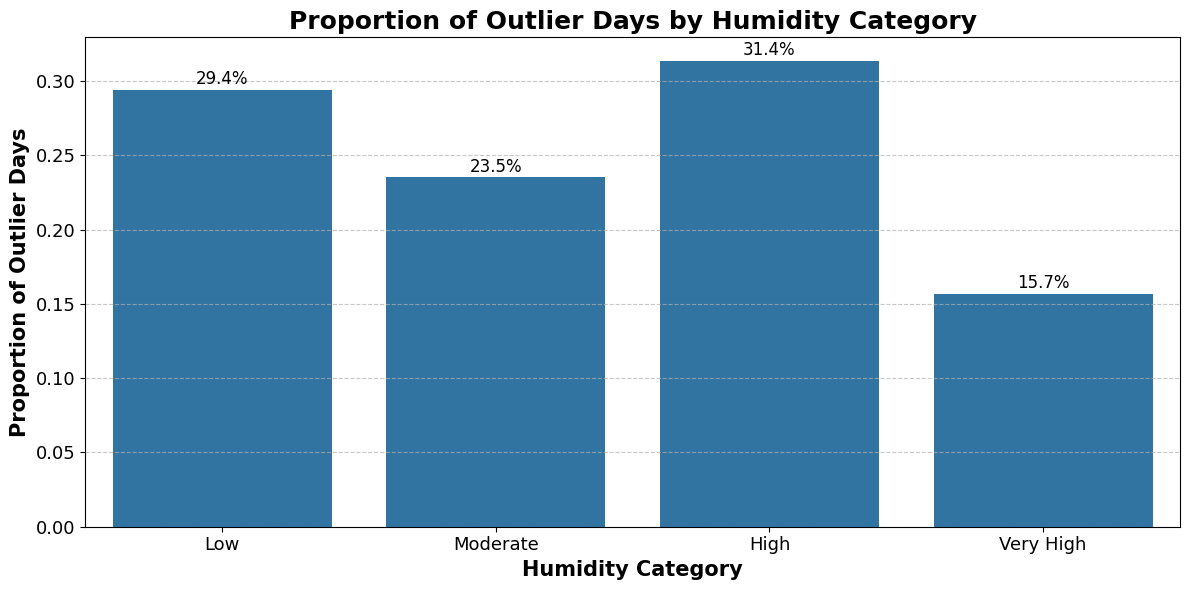

In [75]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define humidity bins and labels
humidity_bins = [33.2, 65.8, 75.5, 85.9, 100]
humidity_labels = ['Low', 'Moderate', 'High', 'Very High']

# Assign categories to each outlier record
# Ensure 'relative_humidity_2m' exists in your dataset
final_merged['Humidity_Category'] = pd.cut(final_merged['relative_humidity_2m'],
                                           bins=humidity_bins,
                                           labels=humidity_labels,
                                           include_lowest=False)

# Count number of outliers per humidity category
humidity_summary = final_merged.groupby('Humidity_Category').agg(
    Outlier_Count=('Weather_Outlier_Day', 'size')
).reset_index()

# Calculate proportion of outlier days in each humidity category
total_outliers_humidity = humidity_summary['Outlier_Count'].sum()
humidity_summary['Proportion_Outlier'] = humidity_summary['Outlier_Count'] / total_outliers_humidity

# Plot the proportion
plt.figure(figsize=(12, 6))
sns.barplot(x='Humidity_Category', y='Proportion_Outlier', data=humidity_summary)

plt.title("Proportion of Outlier Days by Humidity Category", fontsize=18, fontweight='bold')
plt.ylabel("Proportion of Outlier Days", fontsize=15, fontweight='bold')
plt.xlabel("Humidity Category", fontsize=15, fontweight='bold')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid(True, which='major', axis='y', linestyle='--', alpha=0.7)

# Add percentage labels above each bar
for index, row in humidity_summary.iterrows():
    plt.text(index, row['Proportion_Outlier'] + 0.001, f"{row['Proportion_Outlier']:.1%}",
             ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()


In [130]:
# Count number of outliers per precipitation category
precip_summary = final_merged_with_ders.groupby('Humidity_Category').agg(
        Outlier_Days=('Weather_Outlier_Day', 'sum'),
        DER_Combination_No_Solar=('DER_Combination_No_Solar', 'mean'),
        DER_Combination_Solar_Only=('DER_Combination_Solar_Only', 'mean'),
        DER_Combination_Solar_plus_Heat_Pump=('DER_Combination_Solar_+_Heat_Pump', 'mean'),
        DER_Combination_No_Solar_plus_EV=('DER_Combination_No_Solar_+_EV', 'mean'),
        DER_Combination_Solar_plus_EV=('DER_Combination_Solar_+_EV', 'mean')
    ).reset_index()
precip_summary

/var/folders/f9/kb29rl2j2ds719xv7tc90db00000gp/T/ipykernel_27917/128105781.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  precip_summary = final_merged_with_ders.groupby('Humidity_Category').agg(


,Humidity_Category,Outlier_Days,DER_Combination_No_Solar,DER_Combination_Solar_Only,DER_Combination_Solar_plus_Heat_Pump,DER_Combination_No_Solar_plus_EV,DER_Combination_Solar_plus_EV
0,Low,15,7.387602,5.531012,7.560504,20.149585,13.817857
1,Moderate,12,7.803391,7.265072,12.276004,20.731403,16.724871
2,High,16,8.327017,9.666097,16.614530,20.418719,19.874207
3,Very High,8,8.337627,9.921819,19.459095,21.231089,21.106223


/var/folders/f9/kb29rl2j2ds719xv7tc90db00000gp/T/ipykernel_27917/2166724828.py:39: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10', len(existing_cols))


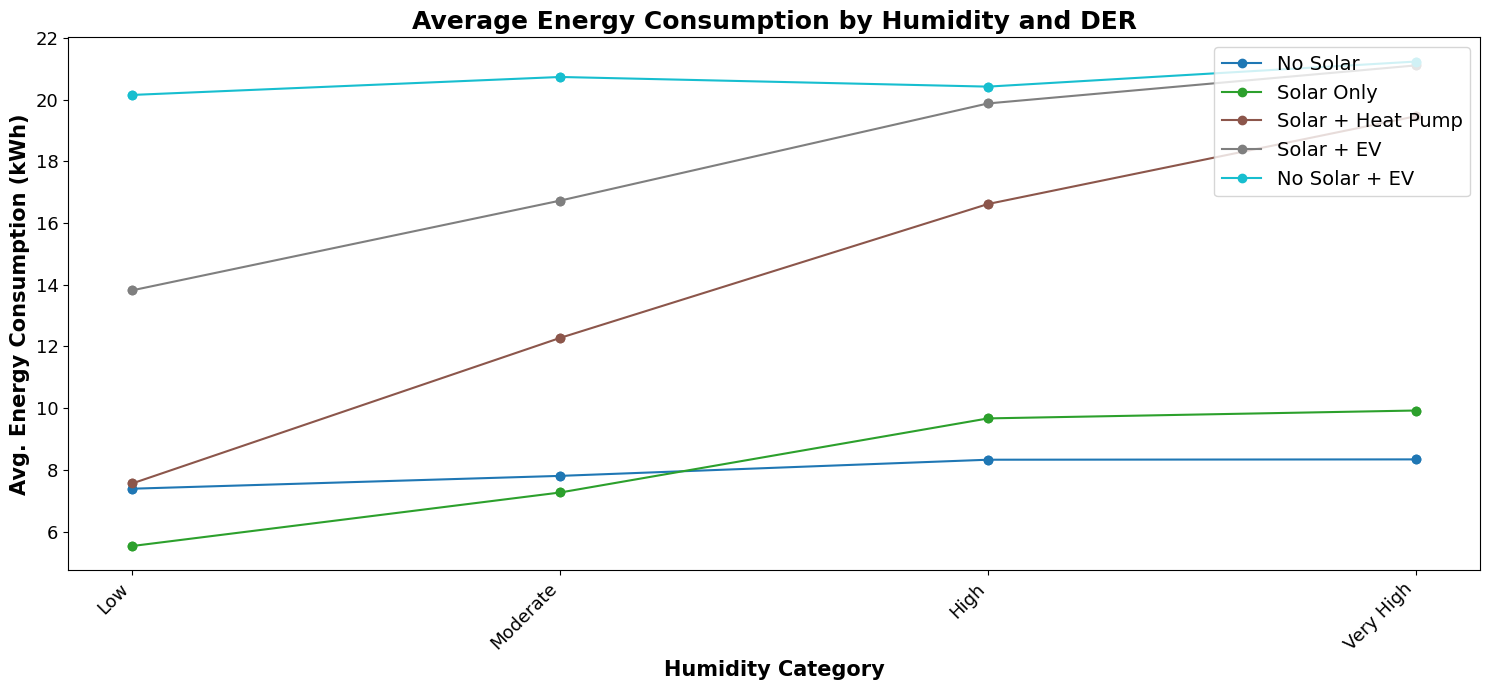

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# 1. Assign temperature categories in final_merged_with_ders
# Define precipitation bins and labels
humidity_bins = [33.2, 65.8, 75.5, 85.9, 100]
humidity_labels = ['Low', 'Moderate', 'High', 'Very High']
final_merged_with_ders['Humidity_Category'] = pd.cut(final_merged_with_ders['relative_humidity_2m'], bins=humidity_bins, labels=humidity_labels)

#List of allowed DER combos, ensure they match column names in summary_temp
allowed_der_combos = [
    "DER_Combination_No_Solar",
    "DER_Combination_Solar_Only",
    "DER_Combination_Solar_plus_Heat_Pump",
    "DER_Combination_Solar_plus_EV",
    "DER_Combination_No_Solar_plus_EV"
]

# Filter columns (check if they exist)
existing_cols = [col for col in allowed_der_combos if col in precip_summary.columns]
summary_filtered = precip_summary[existing_cols]

# Define the order of temperature categories for plotting
temp_order = ['Low', 'Moderate', 'High', 'Very High']
existing_order = [cat for cat in temp_order if cat in precip_summary['Humidity_Category'].values]
others = [cat for cat in precip_summary['Humidity_Category'].values if cat not in temp_order]
plot_order = existing_order + others

labels_list = [
    "No Solar",
    "Solar Only",
    "Solar + Heat Pump",
    "Solar + EV",
    "No Solar + EV"
]

# Plot
colors = cm.get_cmap('tab10', len(existing_cols))
plt.figure(figsize=(15, 7))
for idx, der in enumerate(existing_cols):
    if der in precip_summary.columns:
        yvals = precip_summary.set_index('Humidity_Category').loc[plot_order][der].values
        plt.plot(
            plot_order,
            yvals,
            marker='o',
            linestyle='-',
            label=labels_list[idx],
            color=colors(idx)
        )
        for i, val in enumerate(yvals):
            if val > 0:
                plt.scatter(plot_order[i], val, color=colors(idx), zorder=3)



plt.xlabel('Humidity Category', fontsize=15, fontweight='bold')
plt.ylabel('Avg. Energy Consumption (kWh)', fontsize=15, fontweight='bold')
plt.title('Average Energy Consumption by Humidity and DER', fontsize=18, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=13)
plt.yticks(fontsize=13)
plt.legend(loc='upper right', fontsize=14)
plt.tight_layout()
plt.show()


## Windspeed_Category vs WOD

/var/folders/f9/kb29rl2j2ds719xv7tc90db00000gp/T/ipykernel_27917/1987033909.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  windspeed_summary = final_merged.groupby('Windspeed_Category').agg(


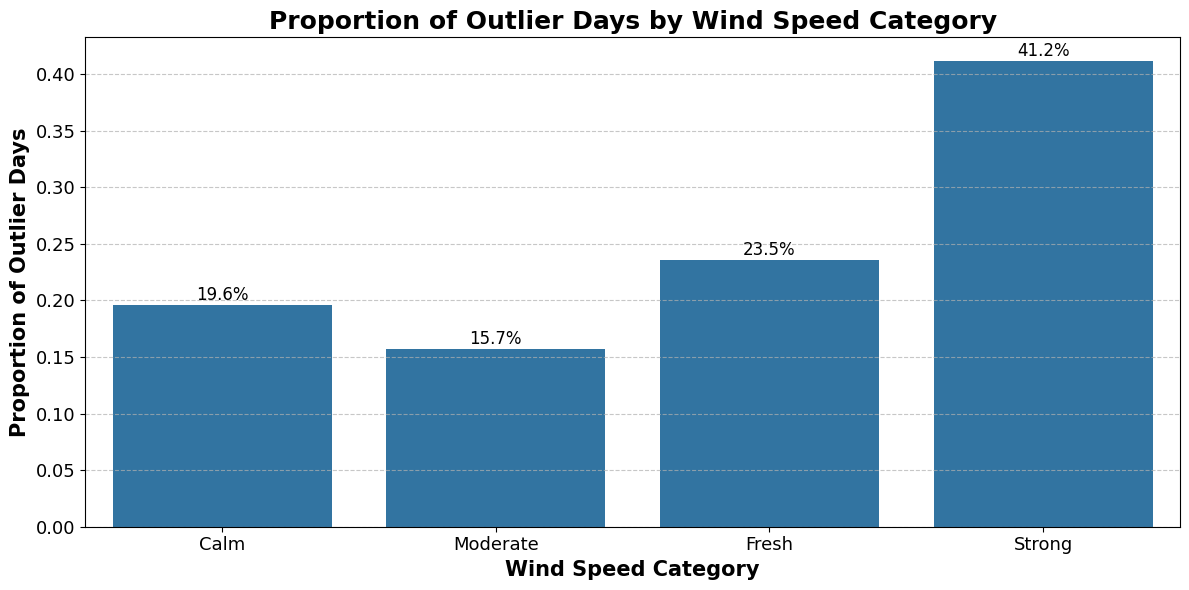

In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define wind speed bins and labels
windspeed_bins = [0, 9.84, 12.93, 16.66, 36]
windspeed_labels = ['Calm', 'Moderate', 'Fresh', 'Strong']

# Assign wind speed categories
# Ensure 'wind_speed_10m' exists in your dataset
final_merged['Windspeed_Category'] = pd.cut(final_merged['wind_speed_10m'],
                                            bins=windspeed_bins,
                                            labels=windspeed_labels,
                                            include_lowest=True)

# Count number of outliers per windspeed category
windspeed_summary = final_merged.groupby('Windspeed_Category').agg(
    Outlier_Count=('Weather_Outlier_Day', 'size')
).reset_index()

# Calculate proportion of outliers in each category
total_outliers_windspeed = windspeed_summary['Outlier_Count'].sum()
windspeed_summary['Proportion_Outlier'] = windspeed_summary['Outlier_Count'] / total_outliers_windspeed

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x='Windspeed_Category', y='Proportion_Outlier', data=windspeed_summary)

plt.title("Proportion of Outlier Days by Wind Speed Category", fontsize=18, fontweight='bold')
plt.ylabel("Proportion of Outlier Days", fontsize=15, fontweight='bold')
plt.xlabel("Wind Speed Category", fontsize=15, fontweight='bold')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid(True, which='major', axis='y', linestyle='--', alpha=0.7)

# Add percentage labels above each bar
for index, row in windspeed_summary.iterrows():
    plt.text(index, row['Proportion_Outlier'] + 0.001, f"{row['Proportion_Outlier']:.1%}",
             ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()


In [140]:
# Count number of outliers per precipitation category
precip_summary = final_merged_with_ders.groupby('Windspeed_Category').agg(
        Outlier_Days=('Weather_Outlier_Day', 'sum'),
        DER_Combination_No_Solar=('DER_Combination_No_Solar', 'mean'),
        DER_Combination_Solar_Only=('DER_Combination_Solar_Only', 'mean'),
        DER_Combination_Solar_plus_Heat_Pump=('DER_Combination_Solar_+_Heat_Pump', 'mean'),
        DER_Combination_No_Solar_plus_EV=('DER_Combination_No_Solar_+_EV', 'mean'),
        DER_Combination_Solar_plus_EV=('DER_Combination_Solar_+_EV', 'mean')
    ).reset_index()
precip_summary

/var/folders/f9/kb29rl2j2ds719xv7tc90db00000gp/T/ipykernel_27917/2925829121.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  precip_summary = final_merged_with_ders.groupby('Windspeed_Category').agg(


,Windspeed_Category,Outlier_Days,DER_Combination_No_Solar,DER_Combination_Solar_Only,DER_Combination_Solar_plus_Heat_Pump,DER_Combination_No_Solar_plus_EV,DER_Combination_Solar_plus_EV
0,Calm,10,7.702427,7.490573,13.422760,21.101615,16.859474
1,Moderate,8,7.445259,6.696286,10.706016,20.160305,15.649520
2,Fresh,12,7.383915,6.892566,10.388897,19.154916,15.900169
3,Strong,21,8.533080,9.190063,16.080112,21.210059,19.533832


/var/folders/f9/kb29rl2j2ds719xv7tc90db00000gp/T/ipykernel_27917/1966358502.py:39: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10', len(existing_cols))


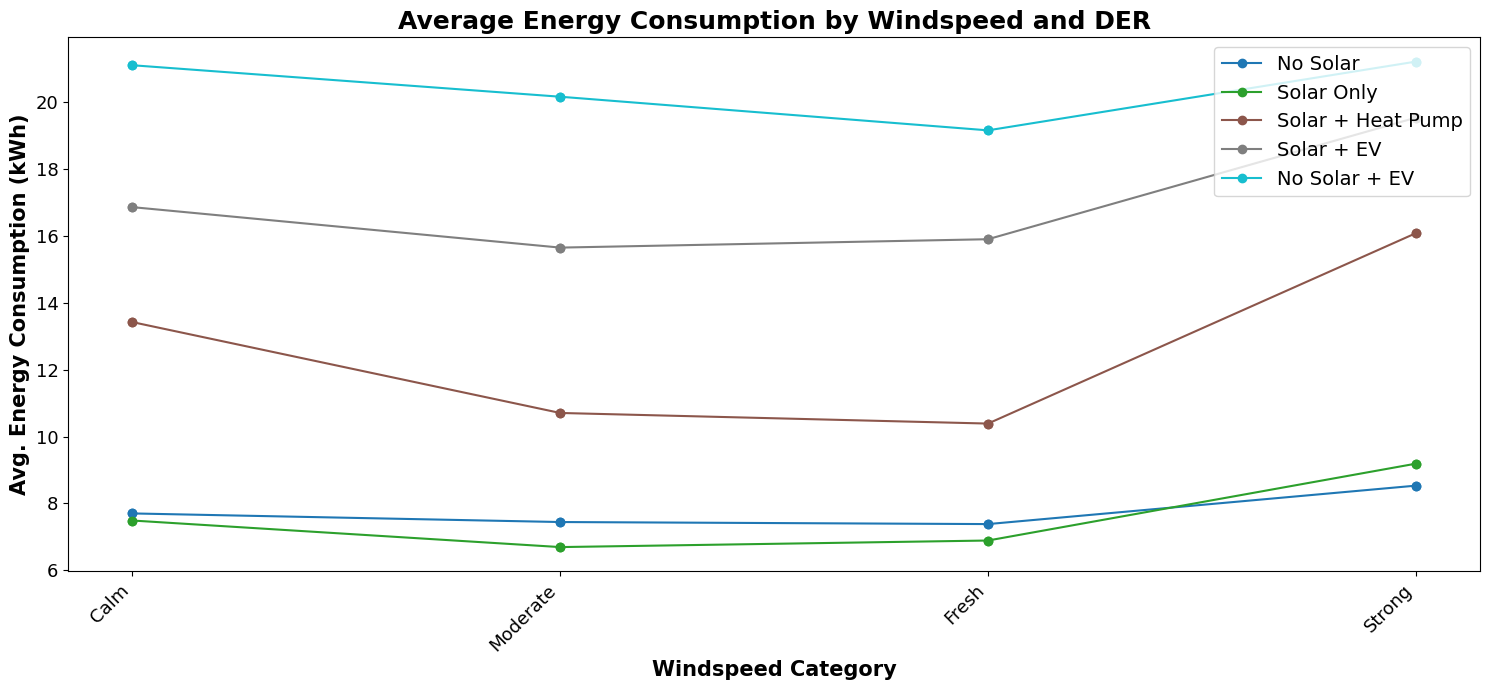

In [141]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# 1. Assign temperature categories in final_merged_with_ders
# Define precipitation bins and labels
windspeed_bins = [0, 9.84, 12.93, 16.66, 36]
windspeed_labels = ['Calm', 'Moderate', 'Fresh', 'Strong']
final_merged_with_ders['Windspeed_Category'] = pd.cut(final_merged_with_ders['relative_humidity_2m'], bins=windspeed_bins, labels=windspeed_labels)

#List of allowed DER combos, ensure they match column names in summary_temp
allowed_der_combos = [
    "DER_Combination_No_Solar",
    "DER_Combination_Solar_Only",
    "DER_Combination_Solar_plus_Heat_Pump",
    "DER_Combination_Solar_plus_EV",
    "DER_Combination_No_Solar_plus_EV"
]

# Filter columns (check if they exist)
existing_cols = [col for col in allowed_der_combos if col in precip_summary.columns]
summary_filtered = precip_summary[existing_cols]

# Define the order of temperature categories for plotting
temp_order = ['Calm', 'Moderate', 'Fresh', 'Strong']
existing_order = [cat for cat in temp_order if cat in precip_summary['Windspeed_Category'].values]
others = [cat for cat in precip_summary['Windspeed_Category'].values if cat not in temp_order]
plot_order = existing_order + others

labels_list = [
    "No Solar",
    "Solar Only",
    "Solar + Heat Pump",
    "Solar + EV",
    "No Solar + EV"
]

# Plot
colors = cm.get_cmap('tab10', len(existing_cols))
plt.figure(figsize=(15, 7))
for idx, der in enumerate(existing_cols):
    if der in precip_summary.columns:
        yvals = precip_summary.set_index('Windspeed_Category').loc[plot_order][der].values
        plt.plot(
            plot_order,
            yvals,
            marker='o',
            linestyle='-',
            label=labels_list[idx],
            color=colors(idx)
        )
        for i, val in enumerate(yvals):
            if val > 0:
                plt.scatter(plot_order[i], val, color=colors(idx), zorder=3)



plt.xlabel('Windspeed Category', fontsize=15, fontweight='bold')
plt.ylabel('Avg. Energy Consumption (kWh)', fontsize=15, fontweight='bold')
plt.title('Average Energy Consumption by Windspeed and DER', fontsize=18, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=13)
plt.yticks(fontsize=13)
plt.legend(loc='upper right', fontsize=14)
plt.tight_layout()
plt.show()


## Cloudcover_Category vs WOD

/var/folders/f9/kb29rl2j2ds719xv7tc90db00000gp/T/ipykernel_27917/1935305772.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cloudcover_summary = final_merged.groupby('Cloudcover_Category').agg(


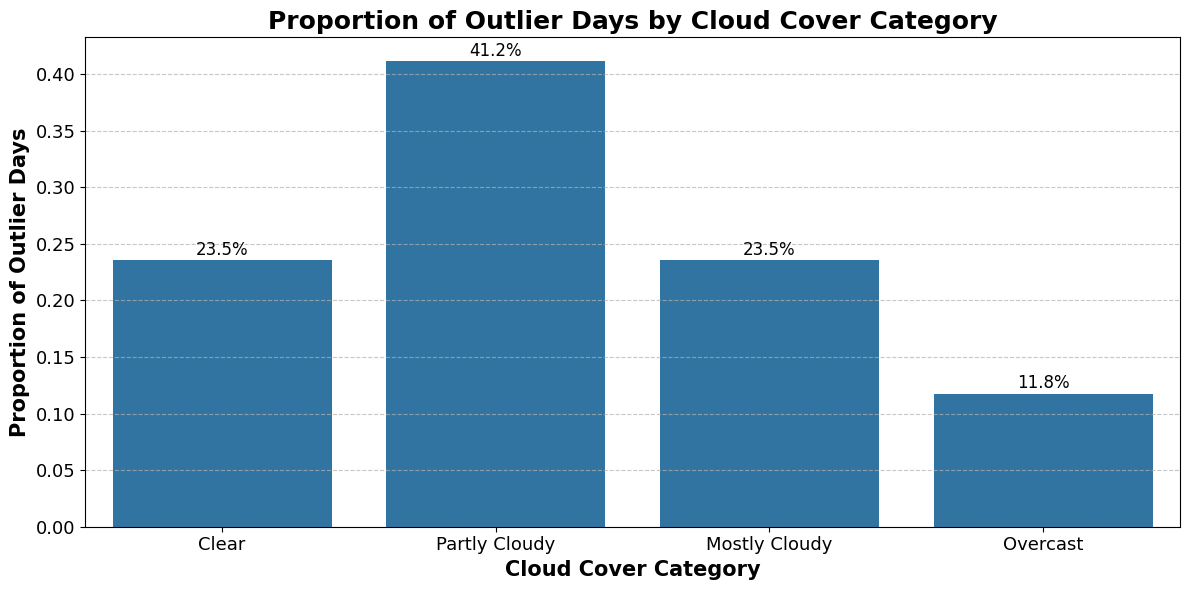

In [77]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define cloud cover bins and labels
cloudcover_bins = [0, 31.31, 50.93, 69.6, 100]
cloudcover_labels = ['Clear', 'Partly Cloudy', 'Mostly Cloudy', 'Overcast']

# Assign cloud cover categories
# Ensure 'cloud_cover' exists in your dataset
final_merged['Cloudcover_Category'] = pd.cut(final_merged['cloud_cover'],
                                             bins=cloudcover_bins,
                                             labels=cloudcover_labels,
                                             include_lowest=True)

# Count number of outliers per cloud cover category
cloudcover_summary = final_merged.groupby('Cloudcover_Category').agg(
    Outlier_Count=('Weather_Outlier_Day', 'size')
).reset_index()

# Calculate proportion of outlier days in each category
total_outliers_cloudcover = cloudcover_summary['Outlier_Count'].sum()
cloudcover_summary['Proportion_Outlier'] = cloudcover_summary['Outlier_Count'] / total_outliers_cloudcover

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x='Cloudcover_Category', y='Proportion_Outlier', data=cloudcover_summary)

plt.title("Proportion of Outlier Days by Cloud Cover Category", fontsize=18, fontweight='bold')
plt.ylabel("Proportion of Outlier Days", fontsize=15, fontweight='bold')
plt.xlabel("Cloud Cover Category", fontsize=15, fontweight='bold')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid(True, which='major', axis='y', linestyle='--', alpha=0.7)

# Add percentage labels on top of each bar
for index, row in cloudcover_summary.iterrows():
    plt.text(index, row['Proportion_Outlier'] + 0.001, f"{row['Proportion_Outlier']:.1%}",
             ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()


In [134]:
# Count number of outliers per precipitation category
precip_summary = final_merged_with_ders.groupby('Cloudcover_Category').agg(
        Outlier_Days=('Weather_Outlier_Day', 'sum'),
        DER_Combination_No_Solar=('DER_Combination_No_Solar', 'mean'),
        DER_Combination_Solar_Only=('DER_Combination_Solar_Only', 'mean'),
        DER_Combination_Solar_plus_Heat_Pump=('DER_Combination_Solar_+_Heat_Pump', 'mean'),
        DER_Combination_No_Solar_plus_EV=('DER_Combination_No_Solar_+_EV', 'mean'),
        DER_Combination_Solar_plus_EV=('DER_Combination_Solar_+_EV', 'mean')
    ).reset_index()
precip_summary

/var/folders/f9/kb29rl2j2ds719xv7tc90db00000gp/T/ipykernel_27917/517796394.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  precip_summary = final_merged_with_ders.groupby('Cloudcover_Category').agg(


,Cloudcover_Category,Outlier_Days,DER_Combination_No_Solar,DER_Combination_Solar_Only,DER_Combination_Solar_plus_Heat_Pump,DER_Combination_No_Solar_plus_EV,DER_Combination_Solar_plus_EV
0,Clear,12,7.899822,7.669326,14.987008,21.427064,17.402455
1,Partly Cloudy,21,7.373793,6.663892,9.922595,19.342534,15.536514
2,Mostly Cloudy,12,8.477965,9.451546,16.064042,21.089673,19.702597
3,Overcast,6,8.834153,9.797658,16.872959,21.862460,20.545995


/var/folders/f9/kb29rl2j2ds719xv7tc90db00000gp/T/ipykernel_27917/3246687690.py:39: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10', len(existing_cols))


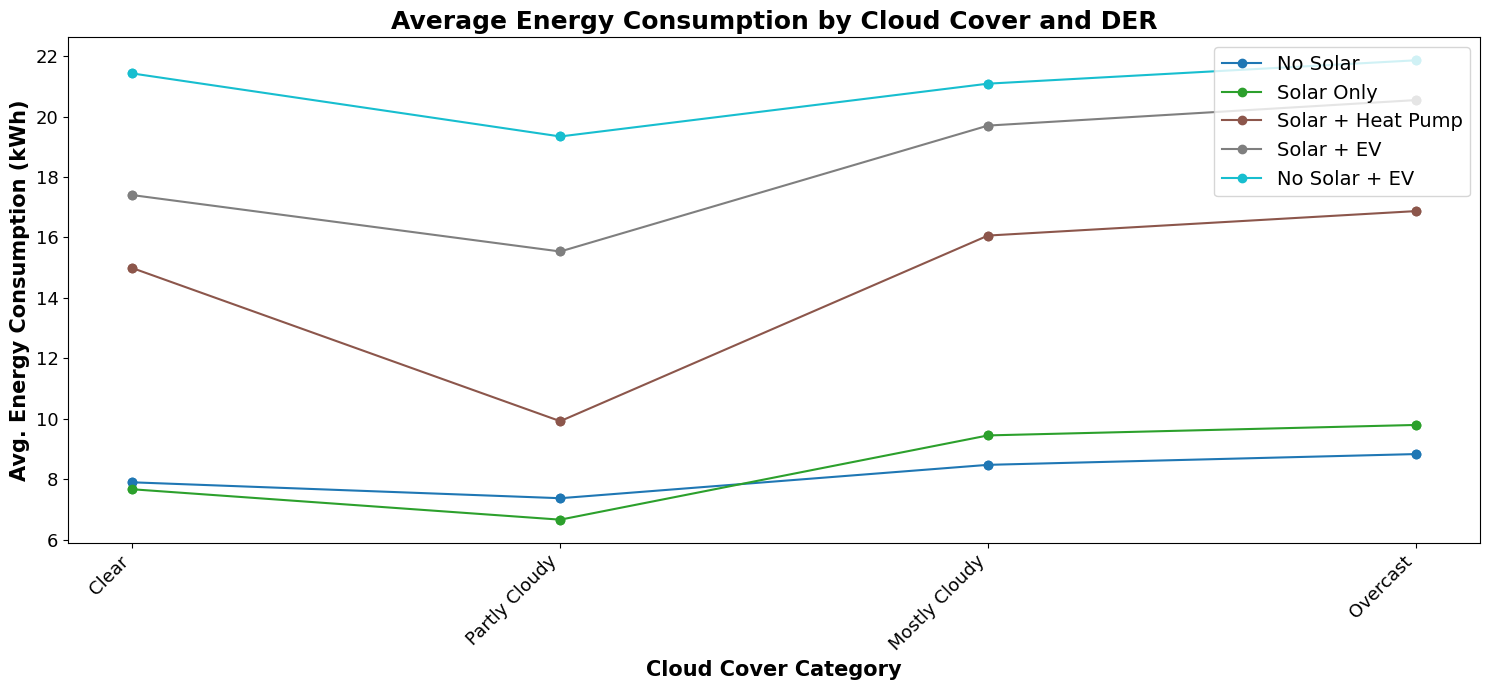

In [136]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# 1. Assign temperature categories in final_merged_with_ders
# Define precipitation bins and labels
cloudcover_bins = [0, 31.31, 50.93, 69.6, 100]
cloudcover_labels = ['Clear', 'Partly Cloudy', 'Mostly Cloudy', 'Overcast']
final_merged_with_ders['Cloudcover_Category'] = pd.cut(final_merged_with_ders['cloud_cover'], bins=cloudcover_bins, labels=cloudcover_labels)

#List of allowed DER combos, ensure they match column names in summary_temp
allowed_der_combos = [
    "DER_Combination_No_Solar",
    "DER_Combination_Solar_Only",
    "DER_Combination_Solar_plus_Heat_Pump",
    "DER_Combination_Solar_plus_EV",
    "DER_Combination_No_Solar_plus_EV"
]

# Filter columns (check if they exist)
existing_cols = [col for col in allowed_der_combos if col in precip_summary.columns]
summary_filtered = precip_summary[existing_cols]

# Define the order of temperature categories for plotting
temp_order = ['Clear', 'Partly Cloudy', 'Mostly Cloudy', 'Overcast']
existing_order = [cat for cat in temp_order if cat in precip_summary['Cloudcover_Category'].values]
others = [cat for cat in precip_summary['Cloudcover_Category'].values if cat not in temp_order]
plot_order = existing_order + others

labels_list = [
    "No Solar",
    "Solar Only",
    "Solar + Heat Pump",
    "Solar + EV",
    "No Solar + EV"
]

# Plot
colors = cm.get_cmap('tab10', len(existing_cols))
plt.figure(figsize=(15, 7))
for idx, der in enumerate(existing_cols):
    if der in precip_summary.columns:
        yvals = precip_summary.set_index('Cloudcover_Category').loc[plot_order][der].values
        plt.plot(
            plot_order,
            yvals,
            marker='o',
            linestyle='-',
            label=labels_list[idx],
            color=colors(idx)
        )
        for i, val in enumerate(yvals):
            if val > 0:
                plt.scatter(plot_order[i], val, color=colors(idx), zorder=3)



plt.xlabel('Cloud Cover Category', fontsize=15, fontweight='bold')
plt.ylabel('Avg. Energy Consumption (kWh)', fontsize=15, fontweight='bold')
plt.title('Average Energy Consumption by Cloud Cover and DER', fontsize=18, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=13)
plt.yticks(fontsize=13)
plt.legend(loc='upper right', fontsize=14)
plt.tight_layout()
plt.show()


# Investigate Weahter Outlier in Detail

In [251]:
final_merged

,Date,temperature_2m_i,relative_humidity_2m_i,precipitation_i,wind_speed_10m_i,cloud_cover_i,Weather_Outlier_Day,temperature_2m,relative_humidity_2m,precipitation,...,Day_Type,Energy_Outlier_Day,Day_of_Week_Name,School_Holiday_Name,Holiday_Name,Temp_Category,Precip_Category,Humidity_Category,Windspeed_Category,Cloudcover_Category
0,2022-01-01,0,0,0,0,1,1,11.950000,85.319515,0.008333,...,Holiday,0,Saturday,Christmas holiday,New Year's Day,Mild,No Rain,High,Strong,Mostly Cloudy
1,2022-01-02,0,0,0,0,1,1,11.545833,83.305570,0.312500,...,Weekend,0,Sunday,Christmas holiday,No Holiday,Mild,Light Rain,High,Strong,Mostly Cloudy
2,2022-01-05,0,0,0,0,1,1,4.137500,79.075873,0.166667,...,Weekday,0,Wednesday,Christmas holiday,No Holiday,Cold,Light Rain,High,Strong,Mostly Cloudy
3,2022-02-04,1,0,0,0,0,1,6.210417,84.229656,0.108333,...,Weekday,0,Friday,No School Holiday,No Holiday,Cold,Light Rain,High,Strong,Mostly Cloudy
4,2022-02-07,0,0,0,1,0,1,5.245833,71.389592,0.045833,...,Weekday,0,Monday,No School Holiday,No Holiday,Cold,No Rain,Moderate,Strong,Partly Cloudy
5,2022-02-10,0,0,0,0,1,1,5.527083,91.913268,0.120833,...,Weekday,0,Thursday,No School Holiday,No Holiday,Cold,Light Rain,Very High,Moderate,Overcast
6,2022-02-11,0,0,0,0,1,1,3.708333,79.253139,0.012500,...,Weekday,0,Friday,No School Holiday,No Holiday,Cold,No Rain,High,Fresh,Clear
7,2022-02-18,0,1,0,0,0,1,8.768750,73.633133,0.137500,...,Weekday,0,Friday,Carnival holiday,No Holiday,Mild,Light Rain,Moderate,Strong,Mostly Cloudy
8,2022-02-25,0,0,0,0,1,1,4.325000,72.653121,0.075000,...,Weekday,0,Friday,No School Holiday,No Holiday,Cold,No Rain,Moderate,Strong,Clear
9,2022-03-13,1,0,0,0,0,1,11.518750,65.225489,0.000000,...,Weekend,0,Sunday,No School Holiday,No Holiday,Mild,No Rain,Low,Strong,Overcast


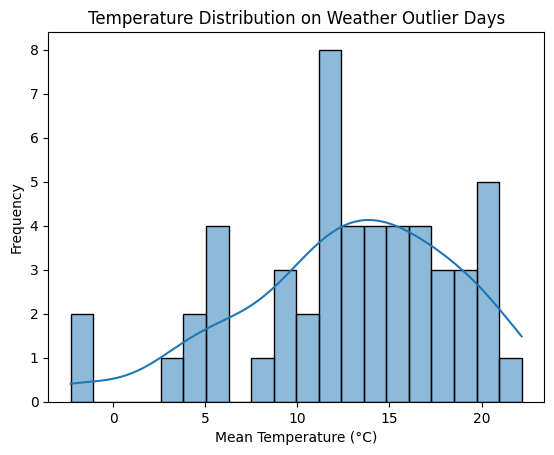

In [202]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter weather outliers
weather_outlier_days = final_merged[final_merged['Weather_Outlier_Day'] == 1]

# Plot distribution of temperature on weather outlier days
sns.histplot(weather_outlier_days['temperature_2m'], bins=20, kde=True)
plt.title('Temperature Distribution on Weather Outlier Days')
plt.xlabel('Mean Temperature (°C)')
plt.ylabel('Frequency')
plt.show()


In [64]:
# Convert 'Date' in daily_weather to datetime
daily_weather['day'] = pd.to_datetime(daily_weather['day'])

# Convert 'Date' in final_merged to datetime
final_merged['Date'] = pd.to_datetime(final_merged['Date'])

# Step 1: Rename 'day' to 'Date' in daily_weather
daily_weather2 = daily_weather.rename(columns={'day': 'Date'})

# Step 2: Remove specific rows
dates_to_remove = ['2023-01-01', '2021-12-31']
daily_weather2 = daily_weather2[~daily_weather2['Date'].isin(pd.to_datetime(dates_to_remove))]

# Step 3: Merge 'Weather_Outlier_Day' from final_merged into daily_weather based on 'Date'
# Select relevant column to merge
weather_outlier_info = final_merged[['Date', 'Weather_Outlier_Day']].drop_duplicates()

# Merge
daily_weather2 = daily_weather2.merge(
    weather_outlier_info,
    on='Date',
    how='left'
)

# Step 4: Fill NaN with 0
daily_weather2['Weather_Outlier_Day'] = daily_weather2['Weather_Outlier_Day'].fillna(0)

# Step 5: Convert 1.0 to 1
daily_weather2['Weather_Outlier_Day'] = daily_weather2['Weather_Outlier_Day'].astype(int)
daily_weather2

,Date,temperature_2m,relative_humidity_2m,precipitation,cloud_cover,wind_speed_10m,Weather_Outlier_Day
0,2022-01-01,11.950000,85.319515,0.008333,57.195836,16.741252,1
1,2022-01-02,11.545833,83.305570,0.312500,68.804169,25.140911,1
2,2022-01-03,8.816667,87.984144,0.179167,70.883335,22.997987,0
3,2022-01-04,6.627083,90.103062,0.229167,97.316668,14.128030,0
4,2022-01-05,4.137500,79.075873,0.166667,55.583333,21.068452,1
...,...,...,...,...,...,...,...
360,2022-12-27,5.256250,84.969415,0.012500,44.183334,20.171731,1
361,2022-12-28,9.079167,86.765895,0.212500,97.870833,30.359464,0
362,2022-12-29,8.875000,82.845296,0.050000,66.087500,29.935795,0
363,2022-12-30,8.895833,88.150897,0.225000,76.891667,26.497690,0


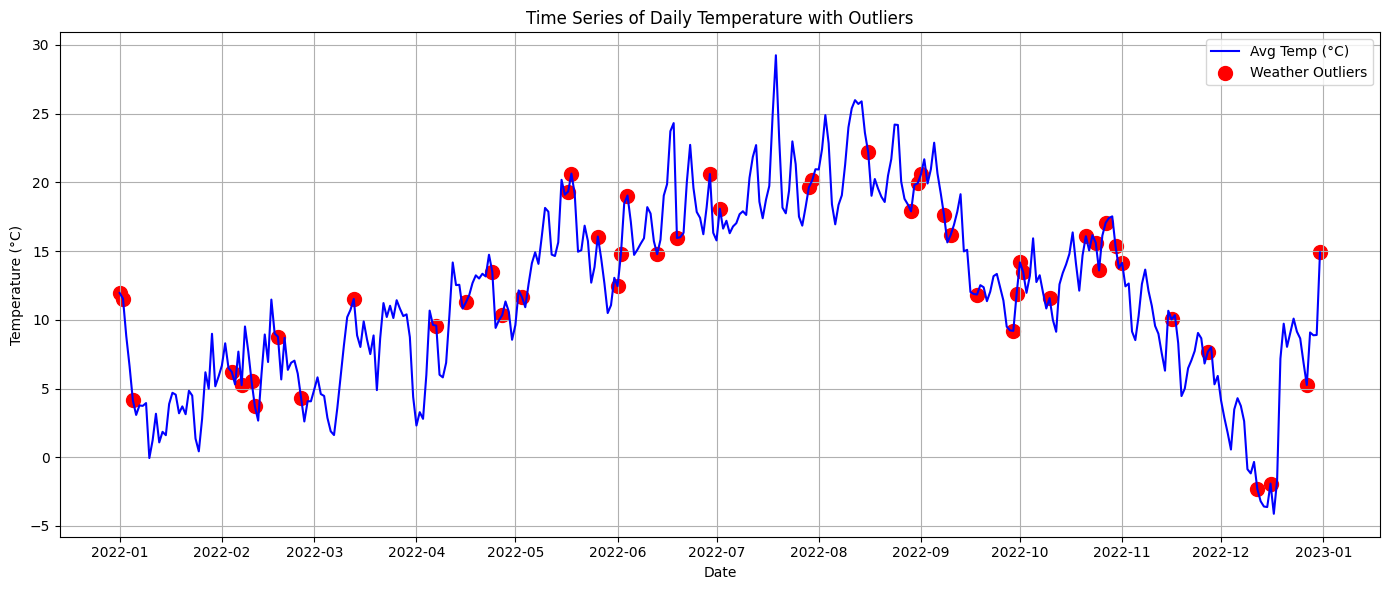

In [65]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Ensure 'Date' is datetime
daily_weather2['Date'] = pd.to_datetime(daily_weather2['Date'])

# Plot the temperature time series
plt.figure(figsize=(14, 6))
plt.plot(daily_weather2['Date'], daily_weather2['temperature_2m'], label='Avg Temp (°C)', color='blue')

# Mark weather outlier days
weather_outliers = daily_weather2[daily_weather2['Weather_Outlier_Day'] == 1]
plt.scatter(weather_outliers['Date'], weather_outliers['temperature_2m'], color='red', label='Weather Outliers', marker='o', s=100)

# # Mark energy outlier days
# # Assuming you have 'Energy_Outlier_Day' with 1/0 indicator in daily_weather2
# energy_outliers = daily_weather2[daily_weather2['Energy_Outlier_Day'] == 1]
# plt.scatter(energy_outliers['Date'], energy_outliers['temperature_2m'], color='orange', label='Energy Outliers', marker='x', s=100)

# Beautify the x-axis (dates)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Labels and title
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.title('Time Series of Daily Temperature with Outliers')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


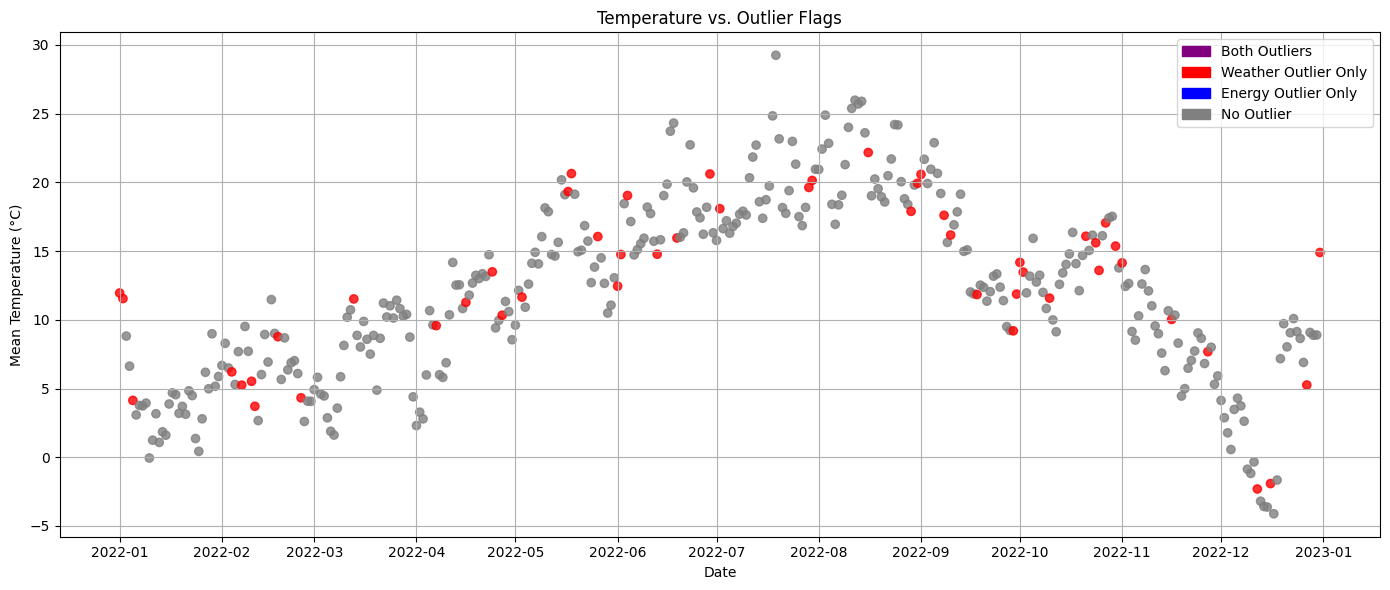

In [66]:
import matplotlib.pyplot as plt

# Make sure Date is datetime
daily_weather2['Date'] = pd.to_datetime(daily_weather2['Date'])

# Create a new column for outlier type
def classify_outlier(row):
    weather_outlier = row['Weather_Outlier_Day']
    energy_outlier = row.get('Energy_Outlier_Day', 0)  # default to 0 if not present
    
    if weather_outlier == 1 and energy_outlier == 1:
        return 'Both'
    elif weather_outlier == 1:
        return 'Weather Only'
    elif energy_outlier == 1:
        return 'Energy Only'
    else:
        return 'None'

# Assign outlier category
daily_weather2['Outlier_Type'] = daily_weather2.apply(classify_outlier, axis=1)

# Map categories to colors
color_map = {
    'Both': 'purple',
    'Weather Only': 'red',
    # 'Energy Only': 'blue',
    'None': 'gray'
}

colors = daily_weather2['Outlier_Type'].map(color_map)

# Plot
plt.figure(figsize=(14, 6))
plt.scatter(daily_weather2['Date'], daily_weather2['temperature_2m'], c=colors, alpha=0.8)

# Create custom legend
import matplotlib.patches as mpatches
legend_handles = [
    mpatches.Patch(color='purple', label='Both Outliers'),
    mpatches.Patch(color='red', label='Weather Outlier Only'),
    mpatches.Patch(color='blue', label='Energy Outlier Only'),
    mpatches.Patch(color='gray', label='No Outlier')
]

plt.legend(handles=legend_handles)
plt.xlabel('Date')
plt.ylabel('Mean Temperature (°C)')
plt.title('Temperature vs. Outlier Flags')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.grid(True)
plt.tight_layout()
plt.show()


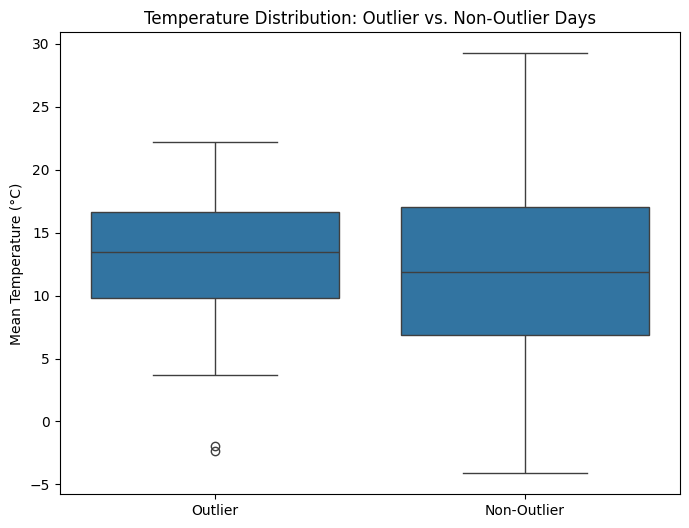

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a subset for plotting
data_for_plot = daily_weather2[['temperature_2m', 'Weather_Outlier_Day']].copy()

# Map outlier flag to labels
data_for_plot['Outlier_Status'] = data_for_plot['Weather_Outlier_Day'].map({1: 'Outlier', 0: 'Non-Outlier'})

# Plot boxplots
plt.figure(figsize=(8,6))
sns.boxplot(x='Outlier_Status', y='temperature_2m', data=data_for_plot)
plt.title('Temperature Distribution: Outlier vs. Non-Outlier Days')
plt.ylabel('Mean Temperature (°C)')
plt.xlabel('')
plt.show()


# Investigate 365 days view

In [148]:
final_merged_with_ders.columns

Index(['Date', 'temperature_2m_i', 'relative_humidity_2m_i', 'precipitation_i',
       'wind_speed_10m_i', 'cloud_cover_i', 'Weather_Outlier_Day',
       'temperature_2m', 'relative_humidity_2m', 'precipitation',
       'cloud_cover', 'wind_speed_10m', 'Volume_Consumption_kWh', 'Month',
       'Day_Type', 'Energy_Outlier_Day', 'Day_of_Week_Name',
       'School_Holiday_Name', 'Holiday_Name', 'Temp_Category',
       'Precip_Category', 'Humidity_Category', 'Windspeed_Category',
       'Cloudcover_Category', 'DER_Combination_No_Solar',
       'DER_Combination_No_Solar_+_EV', 'DER_Combination_Solar_+_EV',
       'DER_Combination_Solar_+_Heat_Pump', 'DER_Combination_Solar_Only'],
      dtype='object')

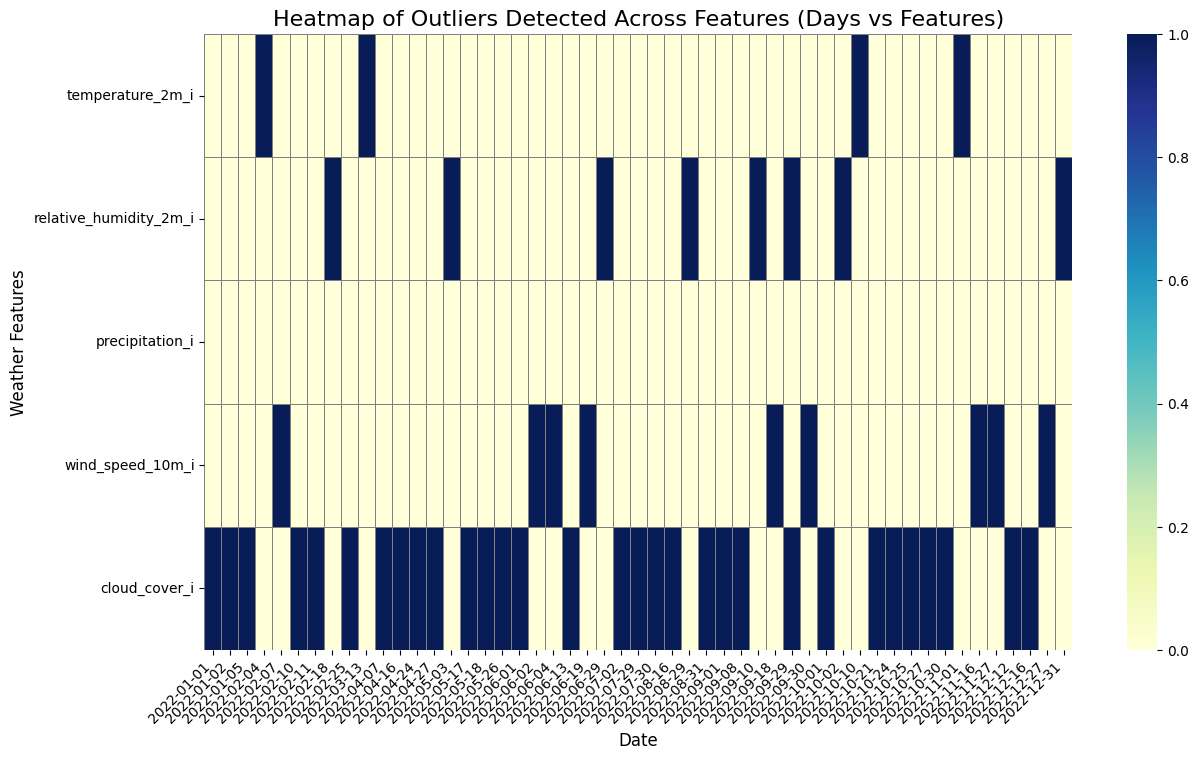

In [155]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select only columns ending with '_i', EXCLUDING 'Weather_Outlier_Day'
i_columns = [col for col in final_merged_with_ders.columns if col.endswith('_i') and col != 'Weather_Outlier_Day']

# Create a copy and convert 'Date' to only the date part (YYYY-MM-DD)
outlier_subset = final_merged_with_ders[['Date'] + i_columns].copy()
outlier_subset['Date'] = pd.to_datetime(outlier_subset['Date']).dt.date

# Set 'Date' as the index
outlier_subset.set_index('Date', inplace=True)

plt.figure(figsize=(14, 8))

sns.heatmap(
    outlier_subset.T,
    cmap="YlGnBu",
    cbar=True,
    linewidths=0.5,
    linecolor='gray',
    xticklabels=True,
    yticklabels=True
)

plt.title("Heatmap of Outliers Detected Across Features (Days vs Features)", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Weather Features", fontsize=12)
plt.xticks(rotation=45, ha='right')

plt.show()


I a fallowing dataset called; final_merged_with_ders, which is concentrated around showing all the outlier days based on weather, which means that the variable Weather_Outlier_Day is all equal to one, then I have other varaibles all ending with _i (e.g., temperature_2m_i) indicating weather this feature was the one that identified this day an outlier (so it is 0 or 1), additionally I have just same varaibles but this time without _i these are the mean indicaiton of the weather conditions for that day (e.g. temperature_2m, mean temperature), 
I have also School_Holiday_Name and Holiday_Name
additional you see a lot of varaibles starting with DER_Combination_  these refer to the mean average consumption given the DER (e.g., DER_Combination_No_Solar = mean average energy consumption where no-solar), 
also other variables (see tamble)
I want to make now an investigation on thison Weather_Outlier_Dau (i.e., full_dataset where outlierdays were identified based on the weather conditions), one time I make the fallowing graph;


/var/folders/f9/kb29rl2j2ds719xv7tc90db00000gp/T/ipykernel_27917/980902494.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_outlier_counts = outlier_subset.resample('M').sum().sum(axis=1)


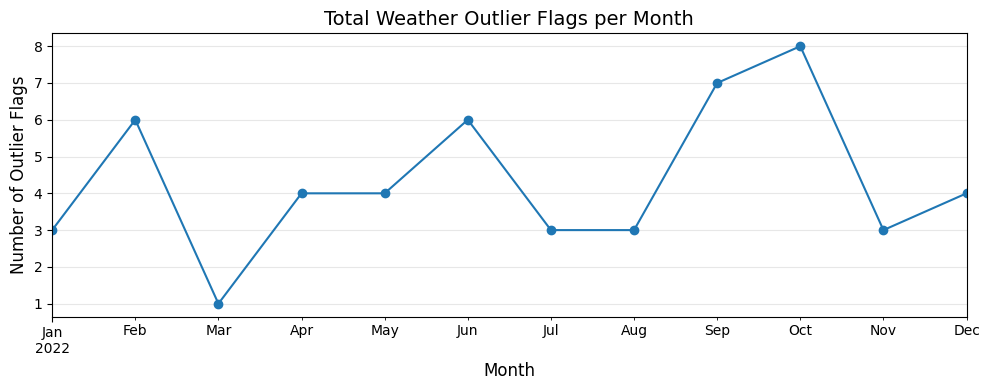

In [157]:
# Convert index to datetime if not already
outlier_subset.index = pd.to_datetime(outlier_subset.index)

# Group by month and sum
monthly_outlier_counts = outlier_subset.resample('M').sum().sum(axis=1)

plt.figure(figsize=(10, 4))
monthly_outlier_counts.plot(marker='o', linestyle='-')
plt.title('Total Weather Outlier Flags per Month', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of Outlier Flags', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


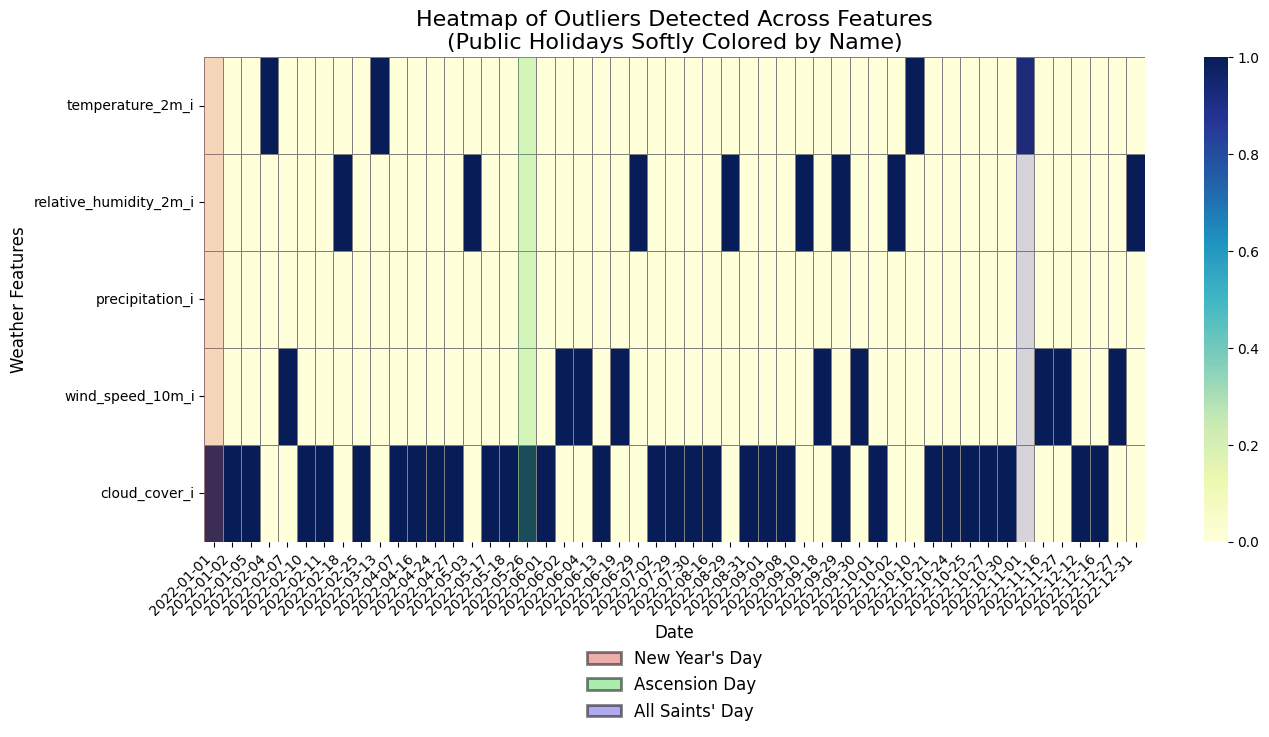

In [209]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import numpy as np

# Prepare data
i_columns = [col for col in final_merged_with_ders.columns if col.endswith('_i') and col != 'Weather_Outlier_Day']
outlier_subset = final_merged_with_ders[['Date'] + i_columns].copy()
outlier_subset['Date'] = pd.to_datetime(outlier_subset['Date']).dt.date
outlier_subset.set_index('Date', inplace=True)

# Get and align holiday names
holiday_names = final_merged_with_ders[['Date', 'Holiday_Name']].copy()
holiday_names['Date'] = pd.to_datetime(holiday_names['Date']).dt.date
holiday_names.set_index('Date', inplace=True)
holiday_names = holiday_names.reindex(outlier_subset.index)

# Identify unique, valid holiday names (excluding 'No Holiday' and blanks)
valid_holidays = holiday_names['Holiday_Name'].dropna()
valid_holidays = valid_holidays[valid_holidays.str.strip().str.lower() != 'no holiday']
unique_holidays = valid_holidays.unique()

# Assign each holiday a unique color from a color palette
holiday_palette = sns.color_palette("hls", len(unique_holidays))
holiday_color_dict = {name: color for name, color in zip(unique_holidays, holiday_palette)}

plt.figure(figsize=(14, 8))
ax = plt.gca()
sns.heatmap(
    outlier_subset.T,
    cmap="YlGnBu",
    cbar=True,
    linewidths=0.5,
    linecolor='gray',
    xticklabels=True,
    yticklabels=True,
    ax=ax
)

plt.title("Heatmap of Outliers Detected Across Features\n(Public Holidays Softly Colored by Name)", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Weather Features", fontsize=12)
plt.xticks(rotation=45, ha='right')

n_rows = len(i_columns)
legend_handles = []

# Draw filled rectangles and build legend for each unique holiday
holiday_seen = set()
for col_idx, date in enumerate(outlier_subset.index):
    holiday = holiday_names.iloc[col_idx]['Holiday_Name']
    if pd.notnull(holiday) and str(holiday).strip().lower() != 'no holiday':
        holiday = str(holiday).strip()
        color = holiday_color_dict.get(holiday, (0,0,0))
        rect = mpatches.Rectangle(
            (col_idx, 0),
            1,        # width
            n_rows,   # height
            linewidth=0,
            edgecolor=None,
            facecolor=color + (0.25,),  # transparent fill
            zorder=2
        )
        ax.add_patch(rect)
        # Add to legend only once per holiday
        if holiday not in holiday_seen:
            legend_handles.append(mpatches.Patch(edgecolor='black', facecolor=color, linewidth=2, label=holiday, alpha=0.5))
            holiday_seen.add(holiday)

# Custom legend: one per unique holiday, centered underneath
plt.legend(
    handles=legend_handles,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.4),
    fontsize=12,
    frameon=False,
    ncol=1 if len(legend_handles)<4 else 2  # dynamic columns for legend
)

plt.tight_layout()
plt.show()


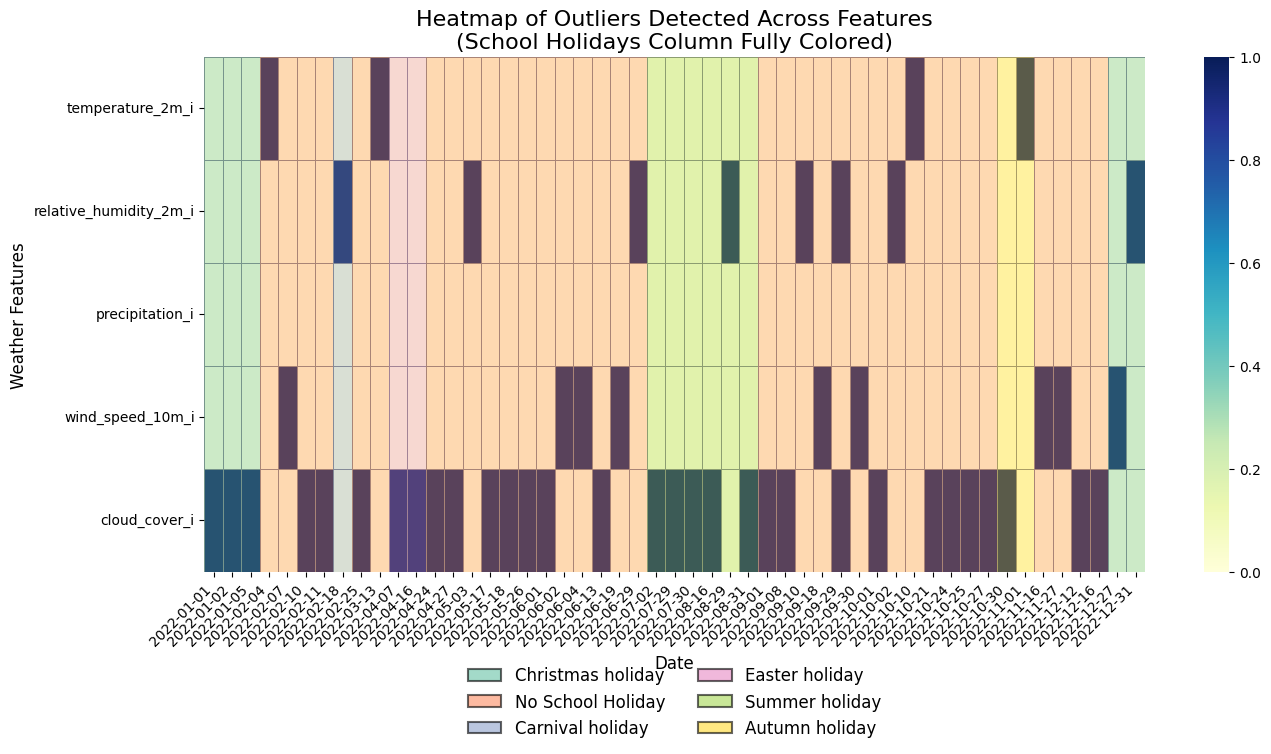

In [174]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd

# Prepare outlier data
i_columns = [col for col in final_merged_with_ders.columns if col.endswith('_i') and col != 'Weather_Outlier_Day']
outlier_subset = final_merged_with_ders[['Date'] + i_columns].copy()
outlier_subset['Date'] = pd.to_datetime(outlier_subset['Date']).dt.date
outlier_subset.set_index('Date', inplace=True)

# Align school holiday names
school_names = final_merged_with_ders[['Date', 'School_Holiday_Name']].copy()
school_names['Date'] = pd.to_datetime(school_names['Date']).dt.date
school_names.set_index('Date', inplace=True)
school_names = school_names.reindex(outlier_subset.index)

# Identify unique, valid school holidays (excluding 'No Holiday' and blanks)
valid_schools = school_names['School_Holiday_Name'].dropna()
valid_schools = valid_schools[valid_schools.str.strip().str.lower() != 'no holiday']
unique_schools = valid_schools.unique()

# Assign colors to each school holiday
school_palette = sns.color_palette("Set2", len(unique_schools))
school_color_dict = {name: color for name, color in zip(unique_schools, school_palette)}

plt.figure(figsize=(14, 8))
ax = plt.gca()

# --- First: the heatmap ---
sns.heatmap(
    outlier_subset.T,
    cmap="YlGnBu",
    cbar=True,
    linewidths=0.5,
    linecolor='gray',
    xticklabels=True,
    yticklabels=True,
    ax=ax
)

plt.title("Heatmap of Outliers Detected Across Features\n(School Holidays Column Fully Colored)", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Weather Features", fontsize=12)
plt.xticks(rotation=45, ha='right')

n_rows = len(i_columns)
legend_handles = []
school_seen = set()

# --- Now: Fill columns for each school holiday ---
for col_idx, date in enumerate(outlier_subset.index):
    school = school_names.iloc[col_idx]['School_Holiday_Name']
    if pd.notnull(school) and str(school).strip().lower() != 'no holiday':
        school = str(school).strip()
        color = school_color_dict.get(school, (0,0,0))
        # Fill rectangle for that column
        rect = mpatches.Rectangle(
            (col_idx, 0),
            1, n_rows,
            linewidth=0,
            edgecolor=None,
            facecolor=color + (0.335,),  # Set alpha for transparency
            zorder=2
        )
        ax.add_patch(rect)
        if school not in school_seen:
            legend_handles.append(mpatches.Patch(edgecolor='black', facecolor=color, linewidth=1.5, label=school, alpha=0.6))
            school_seen.add(school)

# --- School holiday legend under the plot
plt.legend(
    handles=legend_handles,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.35),
    fontsize=12,
    frameon=False,
    ncol=1 if len(legend_handles) < 4 else 2
)

plt.tight_layout()
plt.show()


In [178]:
final_merged_with_ders

,Date,temperature_2m_i,relative_humidity_2m_i,precipitation_i,wind_speed_10m_i,cloud_cover_i,Weather_Outlier_Day,temperature_2m,relative_humidity_2m,precipitation,...,Temp_Category,Precip_Category,Humidity_Category,Windspeed_Category,Cloudcover_Category,DER_Combination_No_Solar,DER_Combination_No_Solar_+_EV,DER_Combination_Solar_+_EV,DER_Combination_Solar_+_Heat_Pump,DER_Combination_Solar_Only
0,2022-01-01,0,0,0,0,1,1,11.950000,85.319515,0.008333,...,Mild,No Rain,High,NaN,Mostly Cloudy,9.352903,19.909509,20.368167,16.713376,10.611333
1,2022-01-02,0,0,0,0,1,1,11.545833,83.305570,0.312500,...,Mild,Light Rain,High,NaN,Mostly Cloudy,9.963760,21.413888,21.719530,19.608249,11.901827
2,2022-01-05,0,0,0,0,1,1,4.137500,79.075873,0.166667,...,Cold,Light Rain,High,NaN,Mostly Cloudy,10.047632,24.013961,26.891650,29.351898,13.619346
3,2022-02-04,1,0,0,0,0,1,6.210417,84.229656,0.108333,...,Cold,Light Rain,High,NaN,Mostly Cloudy,9.114580,24.495833,25.177513,26.058920,12.168277
4,2022-02-07,0,0,0,1,0,1,5.245833,71.389592,0.045833,...,Cold,No Rain,Moderate,NaN,Partly Cloudy,9.037841,22.703072,22.475864,21.787913,10.366313
5,2022-02-10,0,0,0,0,1,1,5.527083,91.913268,0.120833,...,Cold,Light Rain,Very High,NaN,Overcast,9.052799,23.083090,23.295824,25.378102,12.027619
6,2022-02-11,0,0,0,0,1,1,3.708333,79.253139,0.012500,...,Cold,No Rain,High,NaN,Clear,8.974003,22.963283,21.816280,23.670425,10.627330
7,2022-02-18,0,1,0,0,0,1,8.768750,73.633133,0.137500,...,Mild,Light Rain,Moderate,NaN,Mostly Cloudy,8.791240,23.555875,22.910391,22.576679,11.617897
8,2022-02-25,0,0,0,0,1,1,4.325000,72.653121,0.075000,...,Cold,No Rain,Moderate,NaN,Clear,8.885959,25.539252,21.513149,23.518395,10.025172
9,2022-03-13,1,0,0,0,0,1,11.518750,65.225489,0.000000,...,Mild,NaN,Low,NaN,Overcast,9.235460,20.373651,18.574683,12.906337,7.754123


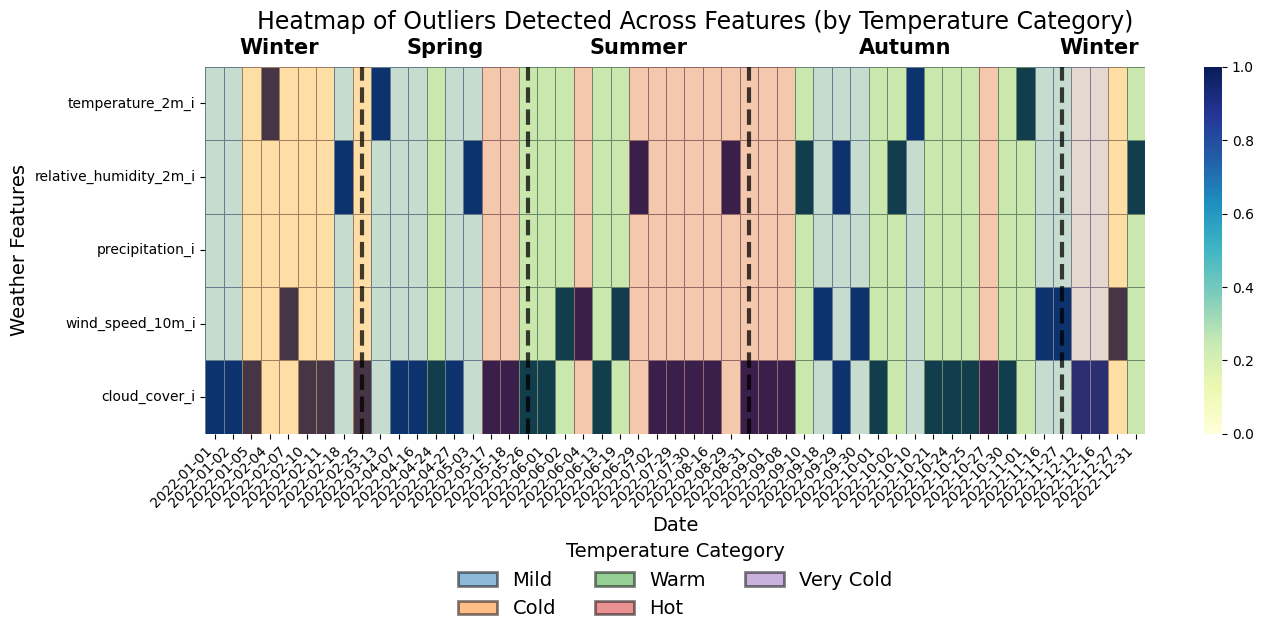

In [244]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd

# PREPARE DATA
i_columns = [col for col in final_merged_with_ders.columns if col.endswith('_i') and col != 'Weather_Outlier_Day']
outlier_subset = final_merged_with_ders[['Date'] + i_columns].copy()
outlier_subset['Date'] = pd.to_datetime(outlier_subset['Date']).dt.date
outlier_subset.set_index('Date', inplace=True)

# TEMP CATEGORY
temp_cat = final_merged_with_ders[['Date', 'Temp_Category']].copy()
temp_cat['Date'] = pd.to_datetime(temp_cat['Date']).dt.date
temp_cat.set_index('Date', inplace=True)
temp_cat = temp_cat.reindex(outlier_subset.index)

valid_cats = temp_cat['Temp_Category'].dropna().unique()
temp_palette = sns.color_palette("tab10", len(valid_cats))
temp_color_dict = {name: color for name, color in zip(valid_cats, temp_palette)}

# SEASON PER DATE
def get_season(date):
    if date.month in [12, 1, 2]:
        return 'Winter'
    elif date.month in [3, 4, 5]:
        return 'Spring'
    elif date.month in [6, 7, 8]:
        return 'Summer'
    elif date.month in [9, 10, 11]:
        return 'Autumn'

dates_sorted = pd.Series(outlier_subset.index).sort_values()
seasons = [get_season(pd.Timestamp(d)) for d in dates_sorted]

# SEASON INTERVALS
season_intervals = []
prev_season = seasons[0]
start_idx = 0
for idx, season in enumerate(seasons[1:], 1):
    if season != prev_season:
        season_intervals.append({'season': prev_season, 'start': start_idx, 'end': idx - 1})
        start_idx = idx
        prev_season = season
season_intervals.append({'season': prev_season, 'start': start_idx, 'end': len(seasons) - 1})

transition_indices = [s['end'] + 0.5 for s in season_intervals[:-1]]

plt.figure(figsize=(14, 8))
ax = plt.gca()

sns.heatmap(
    outlier_subset.T,
    cmap="YlGnBu",
    cbar=True,
    linewidths=0.5,
    linecolor='gray',
    xticklabels=True,
    yticklabels=True,
    ax=ax
)

# --- TITLE (move it up) ---
plt.suptitle("Heatmap of Outliers Detected Across Features (by Temperature Category)", fontsize=17, y=0.96)

plt.xlabel("Date", fontsize=14)
plt.ylabel("Weather Features", fontsize=14)
plt.xticks(rotation=45, ha='right')

n_rows = len(i_columns)
legend_handles = []
cat_seen = set()

# TEMP CATEGORY RECTANGLES
for col_idx, date in enumerate(outlier_subset.index):
    tc = temp_cat.iloc[col_idx]['Temp_Category']
    if pd.notnull(tc):
        tc = str(tc).strip()
        color = temp_color_dict.get(tc, (0, 0, 0))
        rect = mpatches.Rectangle(
            (col_idx, 0),
            1, n_rows,
            linewidth=0,
            edgecolor=None,
            facecolor=color + (0.25,),
            zorder=2
        )
        ax.add_patch(rect)
        if tc not in cat_seen:
            legend_handles.append(mpatches.Patch(edgecolor='black', facecolor=color, linewidth=2, label=tc, alpha=0.5))
            cat_seen.add(tc)

# --- SEASON BOUNDARY LINES (thick!) ---
for idx in transition_indices:
    ax.axvline(x=idx, color='black', linestyle='--', lw=3, alpha=0.75, zorder=5)

# --- CENTERED, BOLD SEASON LABELS (closer to heatmap) ---
yloc = -0.12  # <--- make this less negative to bring closer to the heatmap!
for s in season_intervals:
    center = (s['start'] + s['end']) / 2
    ax.text(
        center, yloc,
        s['season'],
        fontsize=15, fontweight='bold',
        ha='center', va='bottom', color='black',
        zorder=10, clip_on=False
    )

plt.legend(
    handles=legend_handles,
    title='Temperature Category',
    title_fontsize=14,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.55),
    fontsize=14,
    frameon=False,
    ncol=1 if len(legend_handles) < 4 else 3
)

plt.tight_layout()
plt.show()



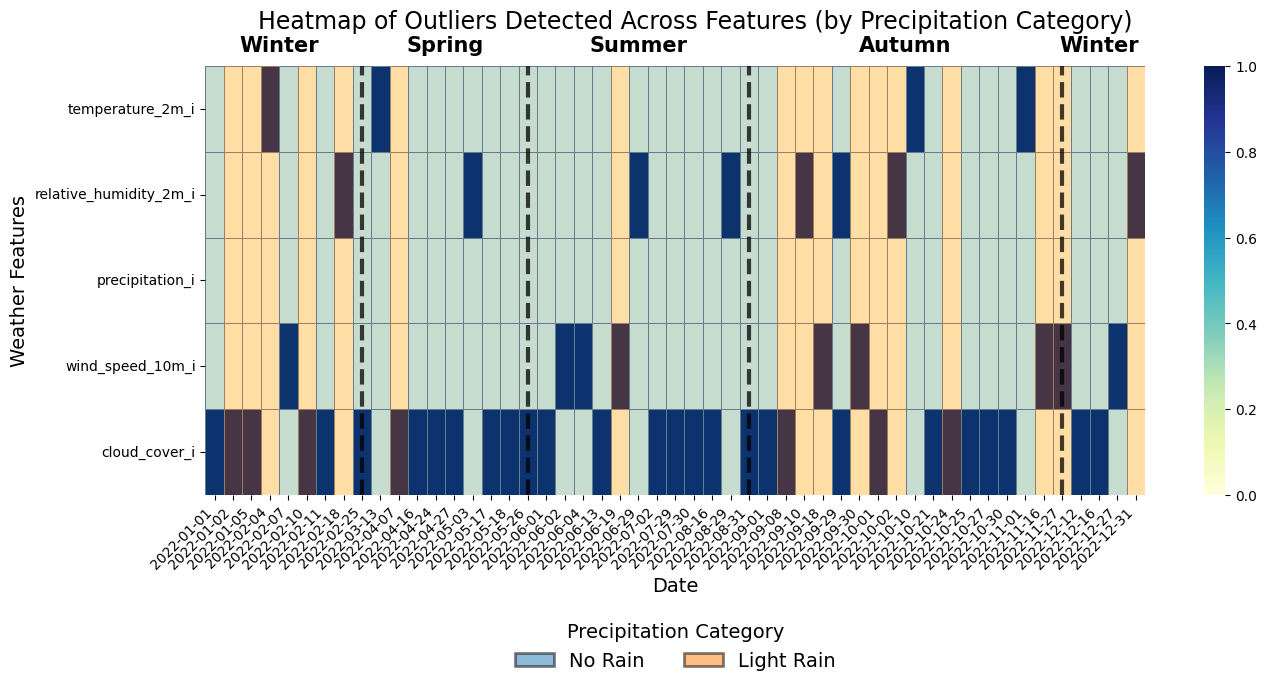

In [243]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd

# Prepare data
i_columns = [col for col in final_merged_with_ders.columns if col.endswith('_i') and col != 'Weather_Outlier_Day']
outlier_subset = final_merged_with_ders[['Date'] + i_columns].copy()
outlier_subset['Date'] = pd.to_datetime(outlier_subset['Date']).dt.date
outlier_subset.set_index('Date', inplace=True)

# Align Precip_Category
percip_cat = final_merged_with_ders[['Date', 'Precip_Category']].copy()
percip_cat['Date'] = pd.to_datetime(percip_cat['Date']).dt.date
percip_cat.set_index('Date', inplace=True)
percip_cat = percip_cat.reindex(outlier_subset.index)

valid_cats = percip_cat['Precip_Category'].dropna().unique()
cat_palette = sns.color_palette("tab10", len(valid_cats))
cat_color_dict = {name: color for name, color in zip(valid_cats, cat_palette)}

# ======= SEASON LABELS AND INTERVALS =======
def get_season(date):
    if date.month in [12, 1, 2]:
        return 'Winter'
    elif date.month in [3, 4, 5]:
        return 'Spring'
    elif date.month in [6, 7, 8]:
        return 'Summer'
    elif date.month in [9, 10, 11]:
        return 'Autumn'

dates_sorted = pd.Series(outlier_subset.index).sort_values()
seasons = [get_season(pd.Timestamp(d)) for d in dates_sorted]

season_intervals = []
prev_season = seasons[0]
start_idx = 0
for idx, season in enumerate(seasons[1:], 1):
    if season != prev_season:
        season_intervals.append({'season': prev_season, 'start': start_idx, 'end': idx - 1})
        start_idx = idx
        prev_season = season
season_intervals.append({'season': prev_season, 'start': start_idx, 'end': len(seasons) - 1})

transition_indices = [s['end'] + 0.5 for s in season_intervals[:-1]]

plt.figure(figsize=(14, 8))
ax = plt.gca()

sns.heatmap(
    outlier_subset.T,
    cmap="YlGnBu",
    cbar=True,
    linewidths=0.5,
    linecolor='gray',
    xticklabels=True,
    yticklabels=True,
    ax=ax
)

# More compact title placement
plt.suptitle("Heatmap of Outliers Detected Across Features (by Precipitation Category)", fontsize=17, y=0.96)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Weather Features", fontsize=14)
plt.xticks(rotation=45, ha='right')

n_rows = len(i_columns)
legend_handles = []
cat_seen = set()

# Fill rectangles for Precip_Category with transparency
for col_idx, date in enumerate(outlier_subset.index):
    pc = percip_cat.iloc[col_idx]['Precip_Category']
    if pd.notnull(pc):
        pc = str(pc).strip()
        color = cat_color_dict.get(pc, (0, 0, 0))
        rect = mpatches.Rectangle(
            (col_idx, 0),
            1, n_rows,
            linewidth=0,
            edgecolor=None,
            facecolor=color + (0.25,),
            zorder=2
        )
        ax.add_patch(rect)
        if pc not in cat_seen:
            legend_handles.append(
                mpatches.Patch(edgecolor='black', facecolor=color, linewidth=2, label=pc, alpha=0.5)
            )
            cat_seen.add(pc)

# --- SEASON BOUNDARY LINES (thick dashed!) ---
for idx in transition_indices:
    ax.axvline(x=idx, color='black', linestyle='--', lw=3, alpha=0.75, zorder=5)

# --- CENTERED, BOLD SEASON LABELS ---
yloc = -0.12  # Bring closer to map; tweak if desired
for s in season_intervals:
    center = (s['start'] + s['end']) / 2
    ax.text(
        center, yloc,
        s['season'],
        fontsize=15, fontweight='bold',
        ha='center', va='bottom', color='black',
        zorder=10, clip_on=False
    )

plt.legend(
    handles=legend_handles,
    title='Precipitation Category',
    title_fontsize=14,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.45),
    fontsize=14,
    frameon=False,
    ncol=2 if len(legend_handles) < 4 else 3
)

plt.tight_layout()
plt.show()


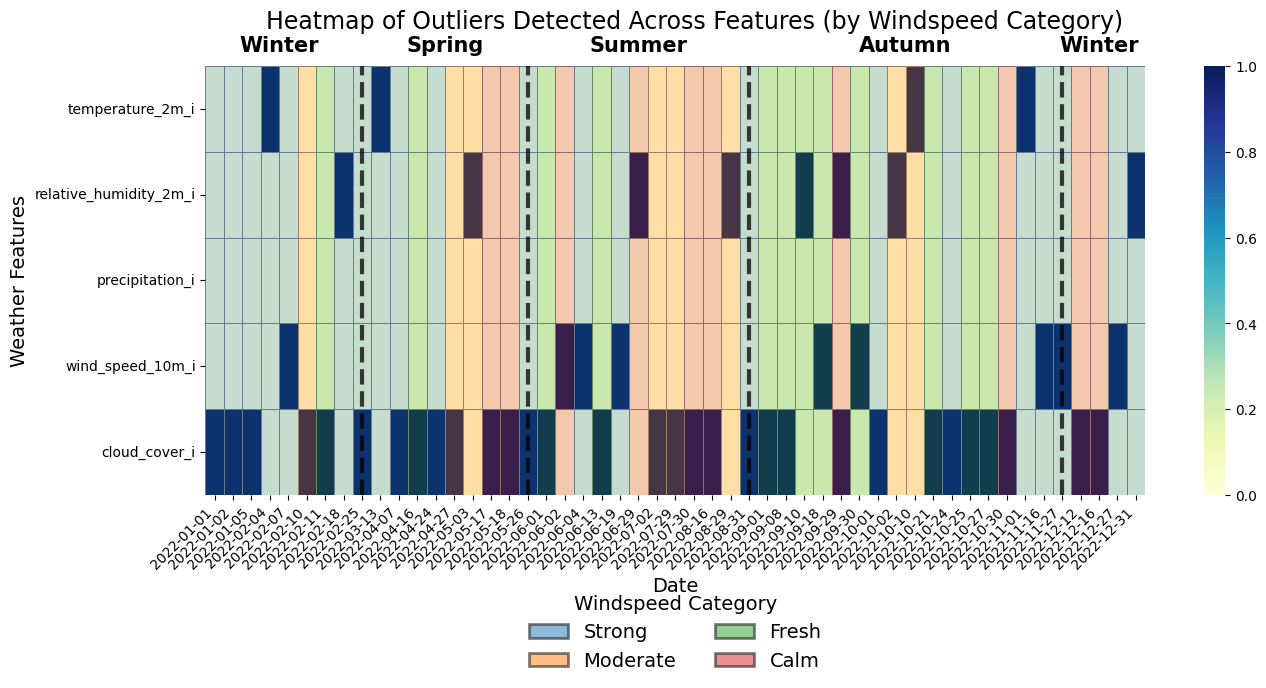

In [249]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd

# Prepare data
i_columns = [col for col in final_merged_with_ders.columns if col.endswith('_i') and col != 'Weather_Outlier_Day']
outlier_subset = final_merged_with_ders[['Date'] + i_columns].copy()
outlier_subset['Date'] = pd.to_datetime(outlier_subset['Date']).dt.date
outlier_subset.set_index('Date', inplace=True)

# Align Windspeed_Category with the heatmap index
wind_cat = final_merged_with_ders[['Date', 'Windspeed_Category']].copy()
wind_cat['Date'] = pd.to_datetime(wind_cat['Date']).dt.date
wind_cat.set_index('Date', inplace=True)
wind_cat = wind_cat.reindex(outlier_subset.index)

# Identify unique, valid Windspeed_Category values
valid_cats = wind_cat['Windspeed_Category'].dropna().unique()
cat_palette = sns.color_palette("tab10", len(valid_cats))
cat_color_dict = {name: color for name, color in zip(valid_cats, cat_palette)}

# ======= SEASON LABELS AND INTERVALS =======
def get_season(date):
    if date.month in [12, 1, 2]:
        return 'Winter'
    elif date.month in [3, 4, 5]:
        return 'Spring'
    elif date.month in [6, 7, 8]:
        return 'Summer'
    elif date.month in [9, 10, 11]:
        return 'Autumn'

dates_sorted = pd.Series(outlier_subset.index).sort_values()
seasons = [get_season(pd.Timestamp(d)) for d in dates_sorted]

season_intervals = []
prev_season = seasons[0]
start_idx = 0
for idx, season in enumerate(seasons[1:], 1):
    if season != prev_season:
        season_intervals.append({'season': prev_season, 'start': start_idx, 'end': idx - 1})
        start_idx = idx
        prev_season = season
season_intervals.append({'season': prev_season, 'start': start_idx, 'end': len(seasons) - 1})

transition_indices = [s['end'] + 0.5 for s in season_intervals[:-1]]

plt.figure(figsize=(14, 8))
ax = plt.gca()

# Draw the heatmap
sns.heatmap(
    outlier_subset.T,
    cmap="YlGnBu",
    cbar=True,
    linewidths=0.5,
    linecolor='gray',
    xticklabels=True,
    yticklabels=True,
    ax=ax
)

plt.suptitle("Heatmap of Outliers Detected Across Features (by Windspeed Category)", fontsize=17, y=0.96)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Weather Features", fontsize=14)
plt.xticks(rotation=45, ha='right')

n_rows = len(i_columns)
legend_handles = []
cat_seen = set()

# Fill rectangles for each valid Windspeed_Category with transparency
for col_idx, date in enumerate(outlier_subset.index):
    wc = wind_cat.iloc[col_idx]['Windspeed_Category']
    if pd.notnull(wc):
        wc = str(wc).strip()
        color = cat_color_dict.get(wc, (0, 0, 0))
        rect = mpatches.Rectangle(
            (col_idx, 0),
            1, n_rows,
            linewidth=0,
            edgecolor=None,
            facecolor=color + (0.25,),  # Soft fill with alpha
            zorder=2
        )
        ax.add_patch(rect)
        if wc not in cat_seen:
            legend_handles.append(mpatches.Patch(edgecolor='black', facecolor=color, linewidth=2, label=wc, alpha=0.5))
            cat_seen.add(wc)

# --- SEASON BOUNDARY LINES (thick dashed!) ---
for idx in transition_indices:
    ax.axvline(x=idx, color='black', linestyle='--', lw=3, alpha=0.75, zorder=5)

# --- CENTERED, BOLD SEASON LABELS ---
yloc = -0.12  # Bring season names tight above the heatmap
for s in season_intervals:
    center = (s['start'] + s['end']) / 2
    ax.text(
        center, yloc,
        s['season'],
        fontsize=15, fontweight='bold',
        ha='center', va='bottom', color='black',
        zorder=10, clip_on=False
    )

plt.legend(
    handles=legend_handles,
    title='Windspeed Category',
    title_fontsize=14,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.45),
    fontsize=14,
    frameon=False,
    ncol=1 if len(legend_handles) < 4 else 2
)

plt.tight_layout()
plt.show()


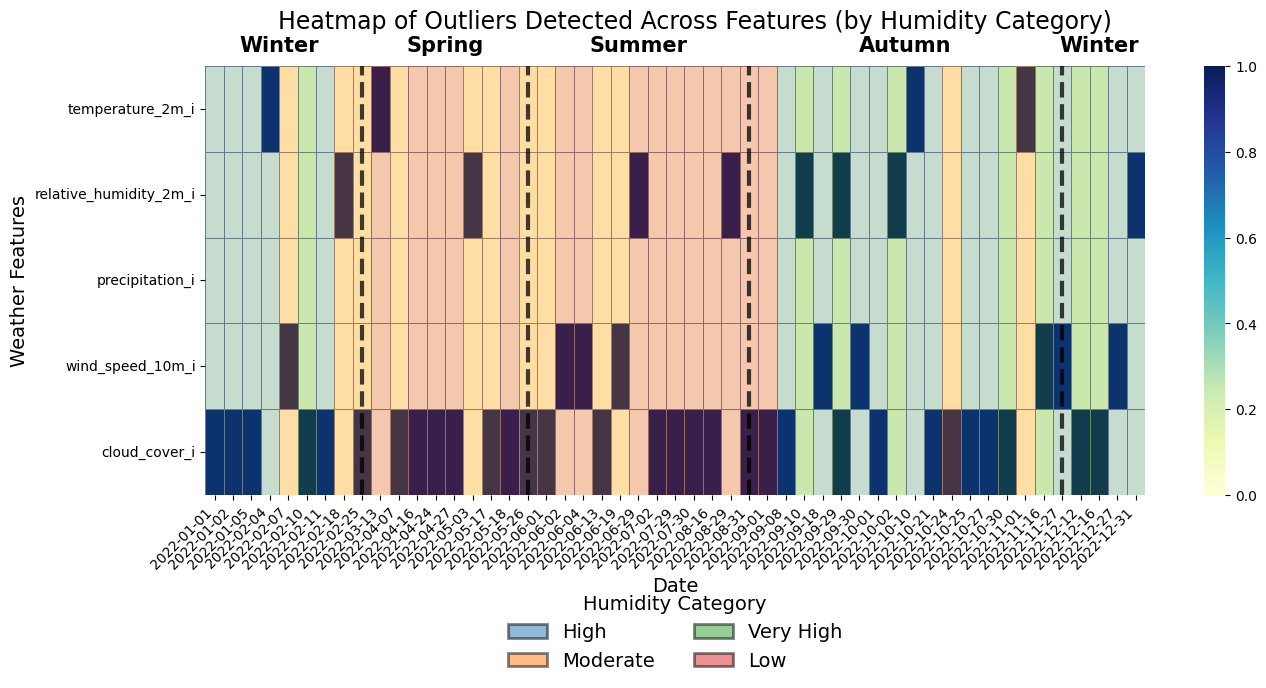

In [248]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd

# Prepare outlier data
i_columns = [col for col in final_merged_with_ders.columns if col.endswith('_i') and col != 'Weather_Outlier_Day']
outlier_subset = final_merged_with_ders[['Date'] + i_columns].copy()
outlier_subset['Date'] = pd.to_datetime(outlier_subset['Date']).dt.date
outlier_subset.set_index('Date', inplace=True)

# Align Humidity_Category with the heatmap index
hum_cat = final_merged_with_ders[['Date', 'Humidity_Category']].copy()
hum_cat['Date'] = pd.to_datetime(hum_cat['Date']).dt.date
hum_cat.set_index('Date', inplace=True)
hum_cat = hum_cat.reindex(outlier_subset.index)

# Identify unique, valid Humidity_Category values
valid_cats = hum_cat['Humidity_Category'].dropna().unique()
cat_palette = sns.color_palette("tab10", len(valid_cats))
cat_color_dict = {name: color for name, color in zip(valid_cats, cat_palette)}

# ======= SEASON LABELS AND INTERVALS =======
def get_season(date):
    if date.month in [12, 1, 2]:
        return 'Winter'
    elif date.month in [3, 4, 5]:
        return 'Spring'
    elif date.month in [6, 7, 8]:
        return 'Summer'
    elif date.month in [9, 10, 11]:
        return 'Autumn'

dates_sorted = pd.Series(outlier_subset.index).sort_values()
seasons = [get_season(pd.Timestamp(d)) for d in dates_sorted]

season_intervals = []
prev_season = seasons[0]
start_idx = 0
for idx, season in enumerate(seasons[1:], 1):
    if season != prev_season:
        season_intervals.append({'season': prev_season, 'start': start_idx, 'end': idx - 1})
        start_idx = idx
        prev_season = season
season_intervals.append({'season': prev_season, 'start': start_idx, 'end': len(seasons) - 1})

transition_indices = [s['end'] + 0.5 for s in season_intervals[:-1]]

plt.figure(figsize=(14, 8))
ax = plt.gca()

# Draw the heatmap
sns.heatmap(
    outlier_subset.T,
    cmap="YlGnBu",
    cbar=True,
    linewidths=0.5,
    linecolor='gray',
    xticklabels=True,
    yticklabels=True,
    ax=ax
)

plt.suptitle("Heatmap of Outliers Detected Across Features (by Humidity Category)", fontsize=17, y=0.96)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Weather Features", fontsize=14)
plt.xticks(rotation=45, ha='right')

n_rows = len(i_columns)
legend_handles = []
cat_seen = set()

# Fill rectangles for each valid Humidity_Category with transparency
for col_idx, date in enumerate(outlier_subset.index):
    hc = hum_cat.iloc[col_idx]['Humidity_Category']
    if pd.notnull(hc):
        hc = str(hc).strip()
        color = cat_color_dict.get(hc, (0, 0, 0))
        rect = mpatches.Rectangle(
            (col_idx, 0),
            1, n_rows,
            linewidth=0,
            edgecolor=None,
            facecolor=color + (0.25,),  # Soft fill with alpha
            zorder=2
        )
        ax.add_patch(rect)
        if hc not in cat_seen:
            legend_handles.append(mpatches.Patch(edgecolor='black', facecolor=color, linewidth=2, label=hc, alpha=0.5))
            cat_seen.add(hc)

# --- SEASON BOUNDARY LINES (thick dashed!) ---
for idx in transition_indices:
    ax.axvline(x=idx, color='black', linestyle='--', lw=3, alpha=0.75, zorder=5)

# --- CENTERED, BOLD SEASON LABELS ---
yloc = -0.12  # Keep season names snuggly above the heatmap!
for s in season_intervals:
    center = (s['start'] + s['end']) / 2
    ax.text(
        center, yloc,
        s['season'],
        fontsize=15, fontweight='bold',
        ha='center', va='bottom', color='black',
        zorder=10, clip_on=False
    )

plt.legend(
    handles=legend_handles,
    loc='lower center',
    title='Humidity Category',
    title_fontsize=14,
    bbox_to_anchor=(0.5, -0.45),
    fontsize=14,
    frameon=False,
    ncol=1 if len(legend_handles) < 4 else 2
)

plt.tight_layout()
plt.show()


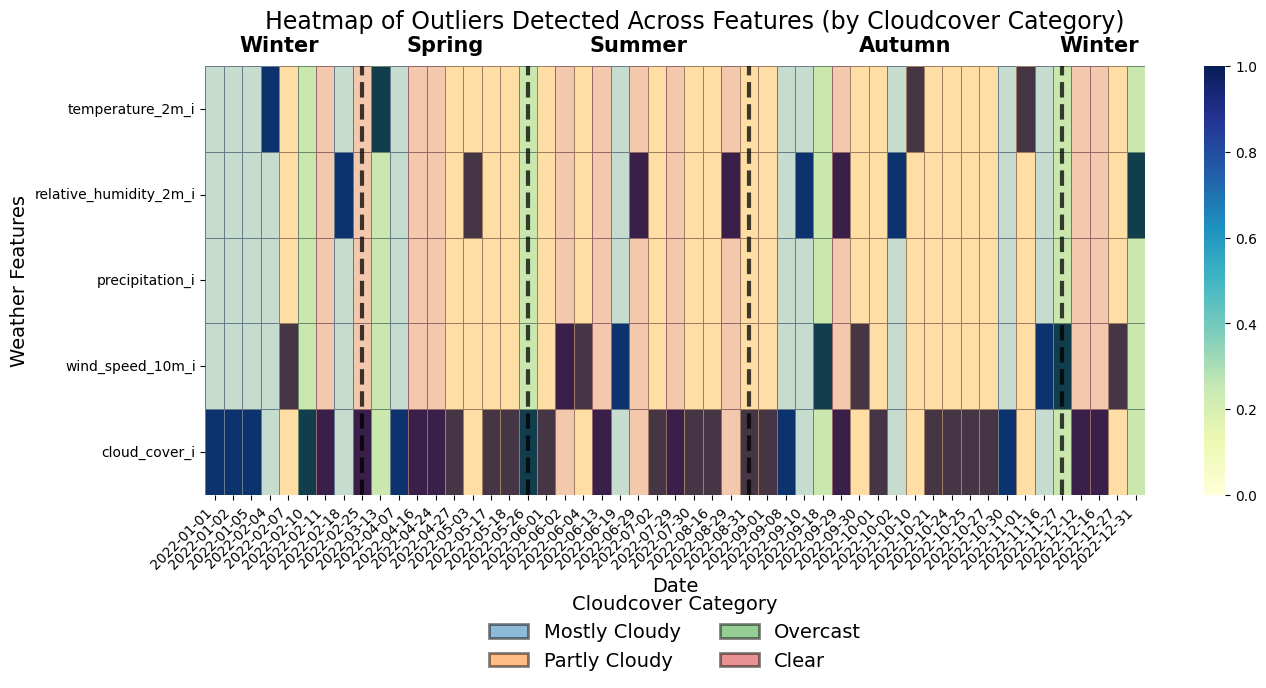

In [250]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd

# Prepare outlier data
i_columns = [col for col in final_merged_with_ders.columns if col.endswith('_i') and col != 'Weather_Outlier_Day']
outlier_subset = final_merged_with_ders[['Date'] + i_columns].copy()
outlier_subset['Date'] = pd.to_datetime(outlier_subset['Date']).dt.date
outlier_subset.set_index('Date', inplace=True)

# Align Cloudcover_Category with the heatmap index
cloud_cat = final_merged_with_ders[['Date', 'Cloudcover_Category']].copy()
cloud_cat['Date'] = pd.to_datetime(cloud_cat['Date']).dt.date
cloud_cat.set_index('Date', inplace=True)
cloud_cat = cloud_cat.reindex(outlier_subset.index)

# Identify unique, valid Cloudcover_Category values
valid_cats = cloud_cat['Cloudcover_Category'].dropna().unique()
cat_palette = sns.color_palette("tab10", len(valid_cats))
cat_color_dict = {name: color for name, color in zip(valid_cats, cat_palette)}

# ======= SEASON LABELS AND INTERVALS =======
def get_season(date):
    if date.month in [12, 1, 2]:
        return 'Winter'
    elif date.month in [3, 4, 5]:
        return 'Spring'
    elif date.month in [6, 7, 8]:
        return 'Summer'
    elif date.month in [9, 10, 11]:
        return 'Autumn'

dates_sorted = pd.Series(outlier_subset.index).sort_values()
seasons = [get_season(pd.Timestamp(d)) for d in dates_sorted]

season_intervals = []
prev_season = seasons[0]
start_idx = 0
for idx, season in enumerate(seasons[1:], 1):
    if season != prev_season:
        season_intervals.append({'season': prev_season, 'start': start_idx, 'end': idx - 1})
        start_idx = idx
        prev_season = season
season_intervals.append({'season': prev_season, 'start': start_idx, 'end': len(seasons) - 1})

transition_indices = [s['end'] + 0.5 for s in season_intervals[:-1]]

plt.figure(figsize=(14, 8))
ax = plt.gca()

# Draw the heatmap
sns.heatmap(
    outlier_subset.T,
    cmap="YlGnBu",
    cbar=True,
    linewidths=0.5,
    linecolor='gray',
    xticklabels=True,
    yticklabels=True,
    ax=ax
)

plt.suptitle("Heatmap of Outliers Detected Across Features (by Cloudcover Category)", fontsize=17, y=0.96)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Weather Features", fontsize=14)
plt.xticks(rotation=45, ha='right')

n_rows = len(i_columns)
legend_handles = []
cat_seen = set()

# Fill rectangles for each valid Cloudcover_Category with transparency
for col_idx, date in enumerate(outlier_subset.index):
    cc = cloud_cat.iloc[col_idx]['Cloudcover_Category']
    if pd.notnull(cc):
        cc = str(cc).strip()
        color = cat_color_dict.get(cc, (0, 0, 0))
        rect = mpatches.Rectangle(
            (col_idx, 0),
            1, n_rows,
            linewidth=0,
            edgecolor=None,
            facecolor=color + (0.25,),  # Soft fill with alpha
            zorder=2
        )
        ax.add_patch(rect)
        if cc not in cat_seen:
            legend_handles.append(mpatches.Patch(edgecolor='black', facecolor=color, linewidth=2, label=cc, alpha=0.5))
            cat_seen.add(cc)

# --- SEASON BOUNDARY LINES (thick dashed!) ---
for idx in transition_indices:
    ax.axvline(x=idx, color='black', linestyle='--', lw=3, alpha=0.75, zorder=5)

# --- CENTERED, BOLD SEASON LABELS ---
yloc = -0.12  # Consistent placement above the heatmap
for s in season_intervals:
    center = (s['start'] + s['end']) / 2
    ax.text(
        center, yloc,
        s['season'],
        fontsize=15, fontweight='bold',
        ha='center', va='bottom', color='black',
        zorder=10, clip_on=False
    )

plt.legend(
    handles=legend_handles,
    title='Cloudcover Category',
    title_fontsize=14,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.45),
    fontsize=14,
    frameon=False,
    ncol=1 if len(legend_handles) < 4 else 2
)

plt.tight_layout()
plt.show()


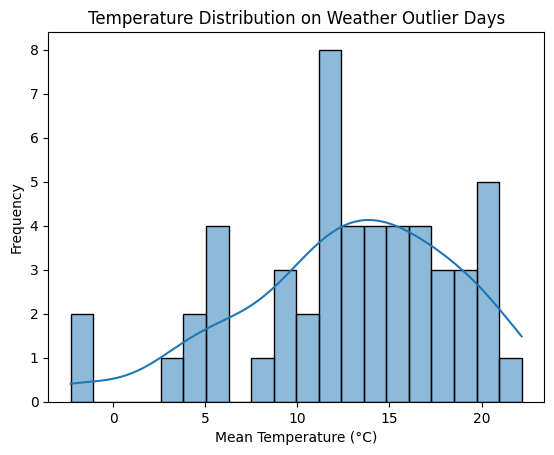

In [203]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter weather outliers
weather_outlier_days = final_merged[final_merged['Weather_Outlier_Day'] == 1]

# Plot distribution of temperature on weather outlier days
sns.histplot(weather_outlier_days['temperature_2m'], bins=20, kde=True)
plt.title('Temperature Distribution on Weather Outlier Days')
plt.xlabel('Mean Temperature (°C)')
plt.ylabel('Frequency')
plt.show()


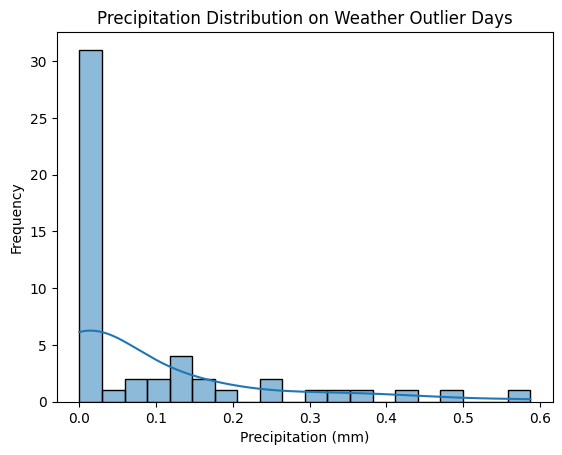

In [252]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter weather outliers
weather_outlier_days = final_merged[final_merged['Weather_Outlier_Day'] == 1]

# Plot distribution of temperature on weather outlier days
sns.histplot(weather_outlier_days['precipitation'], bins=20, kde=True)
plt.title('Precipitation Distribution on Weather Outlier Days')
plt.xlabel('Precipitation (mm)')
plt.ylabel('Frequency')
plt.show()


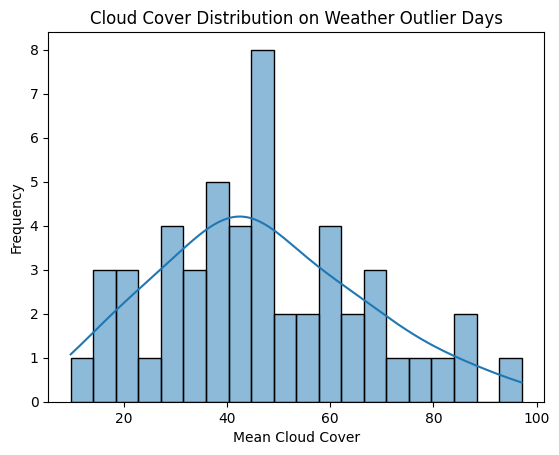

In [256]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter weather outliers
weather_outlier_days = final_merged[final_merged['Weather_Outlier_Day'] == 1]

# Plot distribution of temperature on weather outlier days
sns.histplot(weather_outlier_days['cloud_cover'], bins=20, kde=True)
plt.title('Cloud Cover Distribution on Weather Outlier Days')
plt.xlabel('Mean Cloud Cover')
plt.ylabel('Frequency')
plt.show()


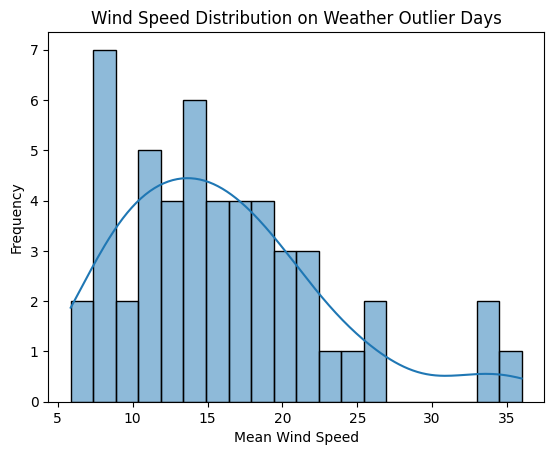

In [257]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter weather outliers
weather_outlier_days = final_merged[final_merged['Weather_Outlier_Day'] == 1]

# Plot distribution of temperature on weather outlier days
sns.histplot(weather_outlier_days['wind_speed_10m'], bins=20, kde=True)
plt.title('Wind Speed Distribution on Weather Outlier Days')
plt.xlabel('Mean Wind Speed')
plt.ylabel('Frequency')
plt.show()


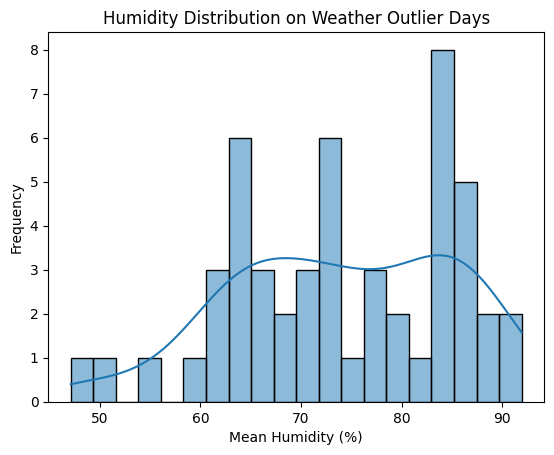

In [258]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter weather outliers
weather_outlier_days = final_merged[final_merged['Weather_Outlier_Day'] == 1]

# Plot distribution of temperature on weather outlier days
sns.histplot(weather_outlier_days['relative_humidity_2m'], bins=20, kde=True)
plt.title('Humidity Distribution on Weather Outlier Days')
plt.xlabel('Mean Humidity (%)')
plt.ylabel('Frequency')
plt.show()


In [259]:
final_merged_with_ders

,Date,temperature_2m_i,relative_humidity_2m_i,precipitation_i,wind_speed_10m_i,cloud_cover_i,Weather_Outlier_Day,temperature_2m,relative_humidity_2m,precipitation,...,Temp_Category,Precip_Category,Humidity_Category,Windspeed_Category,Cloudcover_Category,DER_Combination_No_Solar,DER_Combination_No_Solar_+_EV,DER_Combination_Solar_+_EV,DER_Combination_Solar_+_Heat_Pump,DER_Combination_Solar_Only
0,2022-01-01,0,0,0,0,1,1,11.950000,85.319515,0.008333,...,Mild,No Rain,High,Strong,Mostly Cloudy,9.352903,19.909509,20.368167,16.713376,10.611333
1,2022-01-02,0,0,0,0,1,1,11.545833,83.305570,0.312500,...,Mild,Light Rain,High,Strong,Mostly Cloudy,9.963760,21.413888,21.719530,19.608249,11.901827
2,2022-01-05,0,0,0,0,1,1,4.137500,79.075873,0.166667,...,Cold,Light Rain,High,Strong,Mostly Cloudy,10.047632,24.013961,26.891650,29.351898,13.619346
3,2022-02-04,1,0,0,0,0,1,6.210417,84.229656,0.108333,...,Cold,Light Rain,High,Strong,Mostly Cloudy,9.114580,24.495833,25.177513,26.058920,12.168277
4,2022-02-07,0,0,0,1,0,1,5.245833,71.389592,0.045833,...,Cold,No Rain,Moderate,Strong,Partly Cloudy,9.037841,22.703072,22.475864,21.787913,10.366313
5,2022-02-10,0,0,0,0,1,1,5.527083,91.913268,0.120833,...,Cold,Light Rain,Very High,Moderate,Overcast,9.052799,23.083090,23.295824,25.378102,12.027619
6,2022-02-11,0,0,0,0,1,1,3.708333,79.253139,0.012500,...,Cold,No Rain,High,Fresh,Clear,8.974003,22.963283,21.816280,23.670425,10.627330
7,2022-02-18,0,1,0,0,0,1,8.768750,73.633133,0.137500,...,Mild,Light Rain,Moderate,Strong,Mostly Cloudy,8.791240,23.555875,22.910391,22.576679,11.617897
8,2022-02-25,0,0,0,0,1,1,4.325000,72.653121,0.075000,...,Cold,No Rain,Moderate,Strong,Clear,8.885959,25.539252,21.513149,23.518395,10.025172
9,2022-03-13,1,0,0,0,0,1,11.518750,65.225489,0.000000,...,Mild,No Rain,Low,Strong,Overcast,9.235460,20.373651,18.574683,12.906337,7.754123


In [260]:
import os
save_dir = os.path.join("/Users/agetman/Desktop/Twork/energyThesis/data/from_V1")
os.makedirs(save_dir, exist_ok=True)
final_merged_with_ders.to_pickle(os.path.join(save_dir,"df_weather_outlier_detailed.pkl"))
print(f"DataFrame saved to {save_dir} with all data types preserved")

DataFrame saved to /Users/agetman/Desktop/Twork/energyThesis/data/from_V1 with all data types preserved
